In [1]:
import pandas as pd
import os
#import pyproj as pj # for reliable gps
# or from pyproj import Geod (and remove the pj when executing the functionality)
from pyproj import Geod, Proj
import numpy as np # for reliable gps
from collections import Counter # for reliable gps
import datetime as dt # called in staticMethods # for reliable gps and for depth halfTime
import sys
#import geopandas as gpd # for geometry column for reliable gps # install first GDAL, then fiona and then geopandas
import matplotlib.pyplot as plt #produces maps and diagrams

# for sunset and sunrise time calculation python library
# Additional Locations
import astral
from astral.sun import sun

# timezone aware datetime
import pytz

In [2]:
# staticMethodFunctions
def basedNamesForCsv(lastEntryRowDF, selfDfNameString, selfTurtleTag, selfSpecificFileName=""):
    for value in enumerate(lastEntryRowDF):
        #print(value[1][0])
        lastDate = value[1][0]
        date = dt.datetime.strptime(lastDate, "%Y.%m.%d")
        stringDate = date.strftime("%Y") + "_" + date.strftime("%b")
        print(f"The Last Entry in the Dataframe for {selfTurtleTag} is from: ")
        print(stringDate)
        # Give the CSV a Name based on this values above
        # name = allGpsDf_tag_xxxxx_until_lastdate
        cvsName = selfDfNameString + selfSpecificFileName + "_Tag_" + selfTurtleTag + "_" + stringDate +".csv"
        print(f"The Name for the {selfDfNameString} CSV for the turtleData {selfTurtleTag} is: ")
        print(cvsName)
        print('--------------')
        return cvsName 

def calculateDistance(geodRef, lon1, lat1, lon2, lat2):
    # # compute forward and back azimuths, plus distance
    az12,az21,dist = geodRef.inv(lon1, lat1, lon2, lat2) #Take the second row and the first row on the count. it shoul give 3 values, but I only need the dist.
    # f"{az12:.3f} {az21:.3f} {dist:.3f}"        
    return dist #Put the dist inside the distances variable once empty.

def convertUnixTimeFromString(timeString):
    return dt.datetime.strptime(timeString, '%Y.%m.%d %H:%M:%S').timestamp() #[i] is the position in an array

def stringIntoDate(timeString):
    return dt.datetime.strptime(timeString, '%Y.%m.%d %H:%M:%S')

def calculateSpeed(d, t1, t2):
    speed = d / (t2 - t1)
    return speed

def checkIfDfHasBeenSavedAndSaveDf(folderToSaveItems, folderToSave, dataframe, stringDfName):
    filesInResultsFolder = []       
    for file in folderToSaveItems:
        filesInResultsFolder.append(file)    
    print(filesInResultsFolder)
    if not filesInResultsFolder:
        print(f"The filename {stringDfName} is not yet in the folder... saving csv")
        pathToFilePlusCsvName = os.path.join(folderToSave, stringDfName)
        dataframe.to_csv(pathToFilePlusCsvName, index=False)
        print(f"{stringDfName} has been saved in the results folder!")
    elif stringDfName in filesInResultsFolder:
        print(f"The CSV {stringDfName} has already been saved in the results folder")
    else:
        print(f"The filename {stringDfName} is not yet in the folder... saving csv")
        pathToFilePlusCsvName = os.path.join(folderToSave, stringDfName)
        dataframe.to_csv(pathToFilePlusCsvName, index=False)
        print(f"{stringDfName} has been saved in the results folder!")
    print('--------------')

def checkIfJsonHasBeenSavedAndSaveJson(folderToSaveItems, folderToSave, dataframe, stringJsonName):
    JsonInResultsFolder = []
    for Json in folderToSaveItems:
        JsonInResultsFolder.append(Json) 
    print(JsonInResultsFolder)
    if not JsonInResultsFolder:
        print(f"The filename {stringJsonName} is not yet in the folder... saving json")
        pathToFilePlusJsonName = os.path.join(folderToSave, stringJsonName)
        out = dataframe.to_json(orient="table")
        with open(pathToFilePlusJsonName, 'w') as f:
            f.write(out)
        print(f"{stringJsonName} has been saved in the results folder!")
    elif stringJsonName in JsonInResultsFolder:
        print(f"The CSV {stringJsonName} has already been saved in the results folder")
    else:
        print(f"The filename {stringJsonName} is not yet in the folder... saving json")
        pathToFilePlusJsonName = os.path.join(folderToSave, stringJsonName)
        out = dataframe.to_json(orient="table")
        with open(pathToFilePlusJsonName, 'w') as f:
            f.write(out)
        print(f"{stringJsonName} has been saved in the results folder!")
    print('--------------')

def convertUnixTimeFromString(timeString):
    return dt.datetime.strptime(timeString, '%Y.%m.%d %H:%M:%S').timestamp() #[i] is the position in an array

def convertToStringFromUnixTime(unixSeconds):
    return dt.datetime.fromtimestamp(unixSeconds).strftime('%Y.%m.%d %H:%M:%S')

def createPoint(gps1, gps2, depth):
    
    #Calcolo Percentuale depth in base al tempo
    #print("How many time has passed between 2 points of GPS")
    print(gps1.acquisitionStartTime)
    print(gps2.acquisitionStartTime)
    unixTimeGPS1 = convertUnixTimeFromString(gps1.acquisitionStartTime)
    unixTimeGPS2 = convertUnixTimeFromString(gps2.acquisitionStartTime)
    totalTime = unixTimeGPS2 - unixTimeGPS1
    #print(totalTime)

    #------------------Calculations with acquisition time, not with halftime depth---------------    
    unixTimeAcquisitionTimeDepth = convertUnixTimeFromString(depth.acquisitionTime)
    #print("Depth Acquisition Time")
    #print(depth.acquisitionTime)
    depthTime = unixTimeAcquisitionTimeDepth - unixTimeGPS1
    depthTimePercent = (100*depthTime)/totalTime
    #-------------------------------------------
    
    #------------------half depth---------------
    # halfDepthTime = depth.halfTime - unixTimeGPS1 # maybe use the totalTime variable here
    # halfDepthTimePercent = (100*halfDepthTime)/totalTime
    # print("If using the depth.halfTime - unixTimeGPS1")
    # print("the diff between depth half acquisition time and gps1 acquisition time")
    # print(halfDepthTimePercent)
    #-------------------------------------------
    
    #Sottrazione vettori -----------------------
    #print("calculating diff between lon and lat of gps 1 and gps 2")
    vectorDiff = Point(gps2.longitude-gps1.longitude, gps2.latitude-gps1.latitude)
    #print("DIFF:" + str(vectorDiff.x) + " - " + str(vectorDiff.y))
    
    #Calcolo del modulo del vettore differenza
    modulovectorDiff = np.sqrt((vectorDiff.x**2) + (vectorDiff.y**2))
    
    #Normalizzazione vettore differenza, di lunghezza 1
    normalizedVector = Point( vectorDiff.x/modulovectorDiff, vectorDiff.y/modulovectorDiff)
    
    #Calcolo lunghezza vettore Depth
    #print("Calcolo lunghezza vettore Depth")
    depthVectorLength = ( modulovectorDiff*depthTimePercent)/100
    #print(depthVectorLength)
    
    #---------------------- half depth----------
    # #Calcolo lunghezza vettore Half depth
    # print("Calcolo lunghezza vettore Half Depth")
    # halfDepthVectorLength = ( modulovectorDiff*halfDepthTimePercent)/100
    # print(halfDepthVectorLength)
    #-------------------------------------------
    
    #Calcolo del vettore depth, sull'origine
    #print("Calcolo del vettore depth, sull'origine")
    depthVector = Point(normalizedVector.x * depthVectorLength, normalizedVector.y * depthVectorLength)
    #print(depthVector)
    
    #---------------------half depth------------
    # #Calcolo del vettore Half depth, sull'origine
    # print("Calcolo del vettore Half depth, sull'origine")
    # halfDepthVector = Point(normalizedVector.x * halfDepthVectorLength, normalizedVector.y * halfDepthVectorLength)
    # print(halfDepthVector)
    #-------------------------------------------
    
    #Calcolo finale del punto depth (somma del punto gps1 + vettore depth calcolato)
    #print("Calcolo finale del punto depth (somma del punto gps1 + vettore depth calcolato")
    depthPoint = Point(gps1.longitude + depthVector.x, gps1.latitude+depthVector.y)
    #print(depthPoint)
    
    #---------------------half depth------------
    # #Calcolo finale del punto depth (somma del punto gps1 + vettore depth calcolato)
    # print("Calcolo finale del punto half depth (somma del punto gps1 + vettore half depth calcolato")
    # halfDepthPoint = Point(gps1.longitude + halfDepthVector.x, gps1.latitude+halfDepthVector.y)
    # print(halfDepthPoint)
    #-------------------------------------------
    #print("my point of acquisition time depth")
    #print(str(depthPoint.x) + " - " + str(depthPoint.y))
    # print("my point of half time depth")
    # print(str(halfDepthPoint.x) + " - " + str(halfDepthPoint.y))
    
    # If I want to return the HalfTimeDepth I need to put in return below: halfDepthPoint
    # If I want to return the AquisitionTimeDepth I need to put in return below: depthPoint
    return depthPoint

# function to help transform the percentages in the graph in normal values
def autopct_format(values):
    def my_format(pct):
        total= sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d} ({p:.2f}%)'.format(v=val, p=pct)
    return my_format

def lowerStringAndReplace(string):
    new_string = string.lower()
    return  new_string.replace(" ", "_")

def checkIfGraphHasBeenSavedAndSaveGraph(folderToSaveItems, folderToSave, plt, graphTitle):
    GraphsInResultsFolder = []
    for file in folderToSaveItems:
        if file.endswith('.png'):
            GraphsInResultsFolder.append(file) 
    print(GraphsInResultsFolder)
    if not GraphsInResultsFolder:
        print(f"The Graph {graphTitle} is not yet in the folder... saving graph")
        pathToFilePlusGraphName = os.path.join(folderToSave, graphTitle)
        plt.savefig(pathToFilePlusGraphName + '.png', dpi=300)
        print(f"{graphTitle} has been saved in the results folder!")
    elif graphTitle + '.png' in GraphsInResultsFolder:
        print(f"The Graph {graphTitle} has already been saved in the results folder")
    else:
        print(f"The Graph {graphTitle} is not yet in the folder... saving graph")
        pathToFilePlusGraphName = os.path.join(folderToSave, graphTitle)
        plt.savefig(pathToFilePlusGraphName + '.png', dpi=300)
        print(f"{graphTitle} has been saved in the results folder!")
    print('--------------')


def pieCompareTwoData(group1, group2, labels ,startangle, colors, title, folderToSaveItems, folderToSave):
    plt.figure(figsize=(7,7))
    plt.pie([group1, group2], #labels=labels, 
        autopct= autopct_format([group1,group2]), shadow=True, 
        startangle=startangle, colors=colors, pctdistance=0.6, explode=[0,.1])
    plt.title(title, fontsize=18) #bbox={'facecolor':'0.9', 'pad':5})
    #titleToSaveFig = title.rsplit(' ', 10)[0]
    titleToSaveFig = lowerStringAndReplace(title) + "_graph"
    #print("TITLE TO SAVE THE FIGURES")
    plt.legend(labels, loc="lower right", fontsize=16)#loc="best")
    print(titleToSaveFig)
    checkIfGraphHasBeenSavedAndSaveGraph(folderToSaveItems, folderToSave, plt, titleToSaveFig)
    #plt.savefig(os.path.join(folderToSave, titleToSaveFig + '.png'), dpi=300)
    #plt.savefig(titleToSaveFig + '.png', dpi=300)
    #plt.show()

# def drawFixAttemptGraph(df, columnName, group1, group2, title, folderToSave):
#     fig, ax = plt.subplots(figsize=(10,4))
#     for key, grp in df.groupby([columnName]):
#         ax.plot(grp[group1], grp[group2], label=key)
#     ax.legend()
#     titleToSaveFig = lowerStringAndReplace(title) + "_graph"
#     plt.savefig(os.path.join(folderToSave, titleToSaveFig + '.png'), dpi=300)

# def drawFixAttemptGraph(dataset1, dataset2, title, folderToSave):
#     fig = pd.crosstab(dataset1, dataset2).plot(kind='bar', figsize=(7,6), fontsize=14).get_figure()
#     titleToSaveFig = lowerStringAndReplace(title) + "_graph"
#     fig.savefig(os.path.join(folderToSave, titleToSaveFig + '.png'), dpi=300)
#     #dataset.plot(kind=bar)

# def drawFixAttemptGraph(dataset1, dataset2, title, folderToSave):
#     bar_width = 0.4
#     bar_height = 1
#     # Initialize the vertical-offset for the stacked bar chart.
#     y_offset = np.zeros(2)#len(columns))
#     fig, ax = plt.subplots(2)
#     #plt.xlabel('categories')
#     plt.ylabel('quantity')
#     #print("--------------------HERE")
#     #plt.bar(width=bar_width, height=bar_height, bottom=y_offset)
#     plt.bar(width=bar_width, height=bar_height, x='categories')
#     #dict1 = dict(zip(dataset1.array, dataset1.axes[0]))
#     #print(f"{dict1}--------------dict 01")
#     #dict2 = dict(zip(dataset2.array, dataset2.axes[0]))
#     #print(f"{dict2}--------------dict 02")
#     #print(dataset1.array) #[2832, 173, 6, 204]
#     #print(dataset1.axes) # [Index(['Resolved QFP', 'Resolved QFP (Uncertain)', 'Succeeded', 'Unresolved QFP']  
#     ax[0].plot(dataset1.axes[0], dataset1.array)
#     ax[1].plot(dataset2.axes[0], dataset2.array)
#     titleToSaveFig = lowerStringAndReplace(title) + "_graph"
#     fig.savefig(os.path.join(folderToSave, titleToSaveFig + '.png'), dpi=300)

# def drawFixAttemptGraph(x1, y1, x2, y2, title, folderToSave):
#     fig, ax = plt.subplots(nrows=2,ncols=1)
#     plt.xlabel('categories')
#     plt.ylabel('quantity')
#     #print(dataset1.array) #[2832, 173, 6, 204]
#     #print(dataset1.axes) # [Index(['Resolved QFP', 'Resolved QFP (Uncertain)', 'Succeeded', 'Unresolved QFP']  
#     ax[0].plot(x1, y1)
#     ax[1].plot(x2, y2)
#     titleToSaveFig = lowerStringAndReplace(title) + "_graph"
#     fig.savefig(os.path.join(folderToSave, titleToSaveFig + '.png'), dpi=300)

# def drawFixAttemptGraph(df1, df2, title, folderToSave):
#     fig = plt.figure(figsize=(8,7))
#     subplot1 = fig.add_subplot(1,2,1)
#     subplot1.plot(df1)
#     subplot2 = fig.add_subplot(2,4,2)
#     subplot2.plot(df2)
#     fig.suptitle(title)
#     titleToSaveFig = lowerStringAndReplace(title) + "_graph"
#     fig.savefig(os.path.join(folderToSave, titleToSaveFig + '.png'), dpi=300)

# def drawFixAttemptGraph(dataset, title, folderToSave):
#     fig = plt.figure(figsize=(8,7))
#     #fig = dataset.plot()
#     #fig.sort_values(['GPS Fix Attempt'], ascending=False).plot(kind='barh'), #y='GPS Fix Attempt', x='GPS Fix Attempt')
#     fig.plot(kind='barh')#, y='GPS Fix Attempt', x='GPS Fix Attempt')
#     #fig.suptitle(title)
#     titleToSaveFig = lowerStringAndReplace(title) + "_graph"
#     fig.savefig(os.path.join(folderToSave, titleToSaveFig + '.png'), dpi=300)

# def drawBarFixAttemptGraph(dataset1, dataset2, title, folderToSave):
#     fig = plt.figure(figsize=(8,7))
#     subplot1 = fig.add_subplot()
#     subplot1.plot(dataset1.array, dataset1.axes[0])
#     subplot2 = fig.add_subplot()
#     subplot2.plot(dataset2.array, dataset2.axes[0])    
#     fig.suptitle(title)
#     titleToSaveFig = lowerStringAndReplace(title) + "_bar_graph"
#     fig.savefig(os.path.join(folderToSave, titleToSaveFig + '.png'), dpi=300)

# def drawBarFixAttemptGraph(fixDf, title, folderToSave):
#     plot = fixDf.plot(kind='bar')
#     print("--------------------HERE")
#     fig = plot.get_figure()
#     titleToSaveFig = lowerStringAndReplace(title) + "_bar_chart "
#     fig.savefig(os.path.join(folderToSave, titleToSaveFig + '.png'), dpi=300)

def drawBarFixAttemptGraph(fixDf, title, turtleTag, folderToSaveItems, folderToSave):
    red = "#ff001e"
    green = "#26ed1f"
    plt.figure(figsize=(16,10))
    #colors = ['Blue', 'Yellow', 'Red', 'Green']
    
    # draw percentages in the graph
    graph = plt.bar(x=fixDf.index, height=fixDf["Filtered QFP"], align='center', data=fixDf)
    #graph = plt.bar(fixDf.Format, fixDf["Filtered QFP"], colors=colors)
    # draw title on the graph
    titleComplement = turtleTag + " Transmitter Tag Data"
    graphTitle = plt.title(title[1:] + "\n- " + titleComplement, fontsize=18)
    print(graphTitle)

    totals = fixDf["Overall Recorded QFP"]
    greenBars = [i/ j *100 for i, j in zip(fixDf["Mantained QFP"], totals)] # percentage
    orangeBars = [i/ j *100 for i, j in zip(fixDf["Filtered QFP"], totals)] # percentage
    #print(greenBars)
    #print(orangeBars)

    # draw percentages in the graph
    i = 0
    for p in graph:
        width = p.get_width()
        #height = p.get_heigth()
        x, y = p.get_xy()

        # the y is the height of the percentages text in the bar
        plt.text(x+width/2, y+orangeBars[i]*1.01, str(fixDf['Filtered % of Overall'][i])+'%', ha='center', weight='bold')
        plt.text(x+width/2, y+95*1.01, str(fixDf['Mantained % of Overall'][i])+'%', ha='center', weight='bold')
        #print("___________________________________________")
        #print(orangeBars[i]) # percentage value of each column in the bar graph for the filtered data
        #print(greenBars[i]) # percentage value of each column in the bar graph for the mantained data
        i+=1

    barWidth = 0.85
    names = fixDf.index
    # Create orange Bars
    plt.bar(names, orangeBars, color = red, #edgecolor='white', 
        width=barWidth, label="Filtered \nOver-speed \nerrors")
    # Create green Bars
    plt.bar(names, greenBars, bottom=orangeBars, color = green, #edgecolor='white', 
        width=barWidth, label="Reliable \nGPS \nlocations")    

    # Custom x axis
    #plt.xticks(fixDf.shape[0], names)
    plt.xticks(names)
    plt.xlabel("QFP Categories", fontsize=14)
    plt.ylabel("Overall %", fontsize=14)
    # Add a legend
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    titleToSaveFig = lowerStringAndReplace(title) + "_bar_chart"
    #plt.savefig(os.path.join(folderToSave, titleToSaveFig + '.png'), dpi=300)
    checkIfGraphHasBeenSavedAndSaveGraph(folderToSaveItems, folderToSave, plt, titleToSaveFig)

    # #df = fixDf.iloc[:, 0:2]
    # #df = fixDf.index
    # #print(df)
    # fixDf.plot(x =fixDf.index, kind='barh',stacked=True, title=title[1:], mark_right=True)
    # df_rel = fixDf[fixDf.columns[1:]]
    # print(df_rel)

def stringDateFormatToDaySuntime(acqTime): # 2020.08.12 03:33:54 to 2020, 08, 12
    datePlusTime = acqTime
    #print(datePlusTime) # 2020.08.12 03:33:54
    date = dt.datetime.strptime(datePlusTime, "%Y.%m.%d %H:%M:%S")
    #print(date) # 2020-08-12 03:33:54
    myDataFormat = str(date).replace("-", ", ")[:-9] # 2020, 08, 12 03:33:54 # [:-9] = 2020, 08, 12
    #print(myDataFormat) # '2020, 08, 12'
    separeString = myDataFormat.split(", ")
    #print(separeString) # ['2020', '08', '12']
    stringIntoInt = [int(num) for num in separeString]
    #print(stringIntoInt) # we have a list [2020, 7, 9]
    year = stringIntoInt[0]
    #print(year)
    month = stringIntoInt[1]
    #print(month)
    day = stringIntoInt[2]
    #print(day)
    thatDate = dt.date(year, month, day) # string to day
    return thatDate

def additionalLocationsSunInfoAstral(latitude, longitude, thatDate):
    sunObserver = astral.Observer(latitude,longitude, 0) #, tzinfo=<UTC>
    s = sun(observer=sunObserver, date=thatDate)
    #print(sunObserver)
    #print(s)
    for key in [
        'dawn', # datetime.datetime(2020, 8, 12, 3, 40, 39, 410554, tzinfo=<UTC>
        'dusk', 
        'noon', 
        'sunrise', 
        'sunset' 
        ]:        
        #print(f'{key:10s}:', s[key])
        #print(key)
        if key == 'dawn':
            #print("--------- There is lightness after: ")
            #print(f'{key:10s}:', s[key])
            dawn = s[key]
            #print("see dawn") 
            #print(dawn)
        elif key == 'dusk':
            #print("--------- There is darkness after: ")
            #print(f'{key:10s}:', s[key])
            dusk = s[key]
            #print("see dusk") 
            #print(dusk)
        else:
            break
    #print(dawn) # 2020-08-12 03:40:39.410554+00:00
    #print(dusk) # 2020-08-12 18:21:12.184868+00:00
    return dawn, dusk

def addUTCtimezoneToDatetime(datetimeUnaware):
    timeZoneAware = datetimeUnaware.replace(tzinfo=pytz.UTC)
    #print(timeZoneAware) # 2020-08-12 03:02:44+00:00
    #print("--------- timeZoneAware ABOVE: ")
    return timeZoneAware

def extractYearAndMonthfromtheDate(dateString):
    acqTime = dateString
    #print(acqTime) # 2020.08.12 03:33:54
    splitDatetime = acqTime.split(" ", 1) # Split into "2020.08.12" and "03:33:54"
    justDate = splitDatetime[0]
    #print(justDate)
    # # Create date object in given time format yyyy-mm-dd
    myDate = dt.datetime.strptime(justDate, "%Y.%m.%d")
    #print(myDate)
    #print('Month: ', myDate.month) # To Get month from date
    #print('Year: ', myDate.year) # To Get month from year
    return myDate

def createDictOfElementsInList(list):
    #for x in list:
        #print(x)
    # Creating an empty dict
    yearsDict = dict()
    
    # Iterating the elements in list
    i = 1
    while i < len(list):
        for x in list:
            yearsDict[i] = x
            i+=1
    print(yearsDict)
    return yearsDict

# yearsOfResearch
def firstYear(yearDf):
    # first division of the dataframe is in yearDf
    #print(yearDf)
    firstYearDf = pd.DataFrame(yearDf)
    return firstYearDf
def secondYear(yearDf):
    #print(yearDf)
    secondYearDf = pd.DataFrame(yearDf)
    return secondYearDf
def thirdYear(yearDf):
    #print(yearDf)
    thirdYearDf = pd.DataFrame(yearDf)
    return thirdYearDf
def fourthYear(yearDf):
    #print(yearDf)
    fourthYearDf = pd.DataFrame(yearDf)
    return fourthYearDf
def fifthYear(yearDf):
    #print(yearDf)
    fifthYearDf = pd.DataFrame(yearDf)
    return fifthYearDf
    
def noLight():
    return False
def light():
    return True

def january(boolLight, nightList, dayList, distanceValue):
    print("1 month")
    if boolLight == False:
        print(f"january nigth")
        nightList.append(distanceValue)
    else:
        print(f"january day")
        dayList.append(distanceValue)
    distanceInMetresAtNight = sum(nightList)
    distanceInMetresInDay = sum(dayList)
    print(f"{distanceInMetresAtNight} january total distance at nigth")
    print(f"{distanceInMetresInDay} january total distance in day")
    return nightList, dayList

def february(boolLight, nightList, dayList, distanceValue):
    print("2 month")
    if boolLight == False:
        print(f"february nigth")
        nightList.append(distanceValue)
    else:
        print(f"february day")
        dayList.append(distanceValue)
    distanceInMetresAtNight = sum(nightList)
    distanceInMetresInDay = sum(dayList)
    print(f"{distanceInMetresAtNight} february total distance at nigth")
    print(f"{distanceInMetresInDay} february total distance in day")
    return nightList, dayList

def march(boolLight, nightList, dayList, distanceValue):
    print("3 month")
    if boolLight == False:
        print(f"march nigth")
        nightList.append(distanceValue)
    else:
        print(f"march day")
        dayList.append(distanceValue)
    distanceInMetresAtNight = sum(nightList)
    distanceInMetresInDay = sum(dayList)
    print(f"{distanceInMetresAtNight} march total distance at nigth")
    print(f"{distanceInMetresInDay} march total distance in day")
    return nightList, dayList

def april(boolLight, nightList, dayList, distanceValue):
    print("4 month")
    if boolLight == False:
        print(f"april nigth")
        nightList.append(distanceValue)
    else:
        print(f"april day")
        dayList.append(distanceValue)
    distanceInMetresAtNight = sum(nightList)
    distanceInMetresInDay = sum(dayList)
    print(f"{distanceInMetresAtNight} april total distance at nigth")
    print(f"{distanceInMetresInDay} april total distance in day")
    return nightList, dayList

def may(boolLight, nightList, dayList, distanceValue):
    print("5 month")
    if boolLight == False:
        print(f"may nigth")
        nightList.append(distanceValue)
    else:
        print(f"may day")
        dayList.append(distanceValue)
    distanceInMetresAtNight = sum(nightList)
    distanceInMetresInDay = sum(dayList)
    print(f"{distanceInMetresAtNight} may total distance at nigth")
    print(f"{distanceInMetresInDay} may total distance in day")
    return nightList, dayList

def june(boolLight, nightList, dayList, distanceValue):
    print("6 month")
    if boolLight == False:
        print(f"june nigth")
        nightList.append(distanceValue)
    else:
        print(f"june day")
        dayList.append(distanceValue)
    distanceInMetresAtNight = sum(nightList)
    distanceInMetresInDay = sum(dayList)
    print(f"{distanceInMetresAtNight} june total distance at nigth")
    print(f"{distanceInMetresInDay} june total distance in day")
    return nightList, dayList

def july(boolLight, nightList, dayList, distanceValue):
    print("7 month")
    if boolLight == False:
        print(f"july nigth")
        nightList.append(distanceValue)
    else:
        print(f"july day")
        dayList.append(distanceValue)
    distanceInMetresAtNight = sum(nightList)
    distanceInMetresInDay = sum(dayList)
    print(f"{distanceInMetresAtNight} july total distance at nigth")
    print(f"{distanceInMetresInDay} july total distance in day")
    return nightList, dayList

def august(boolLight, nightList, dayList, distanceValue):
    print("8 month")
    if boolLight == False:
        print(f"august nigth")
        nightList.append(distanceValue)
    else:
        print(f"august day")
        dayList.append(distanceValue)
    distanceInMetresAtNight = sum(nightList)
    distanceInMetresInDay = sum(dayList)
    print(f"{distanceInMetresAtNight} august total distance at nigth")
    print(f"{distanceInMetresInDay} august total distance in day")
    return nightList, dayList

def september(boolLight, nightList, dayList, distanceValue):
    print("9 month")
    if boolLight == False:
        print(f"september nigth")
        nightList.append(distanceValue)
    else:
        print(f"september day")
        dayList.append(distanceValue)
    distanceInMetresAtNight = sum(nightList)
    distanceInMetresInDay = sum(dayList)
    print(f"{distanceInMetresAtNight} september total distance at nigth")
    print(f"{distanceInMetresInDay} september total distance in day")
    return nightList, dayList

def october(boolLight, nightList, dayList, distanceValue):
    print("10 month")
    if boolLight == False:
        print(f"october nigth")
        nightList.append(distanceValue)
    else:
        print(f"october day")
        dayList.append(distanceValue)
    distanceInMetresAtNight = sum(nightList)
    distanceInMetresInDay = sum(dayList)
    print(f"{distanceInMetresAtNight} october total distance at nigth")
    print(f"{distanceInMetresInDay} october total distance in day")
    return nightList, dayList

def november(boolLight, nightList, dayList, distanceValue):
    print("11 month")
    if boolLight == False:
        print(f"november nigth")
        nightList.append(distanceValue)
    else:
        print(f"november day")
        dayList.append(distanceValue)
    distanceInMetresAtNight = sum(nightList)
    distanceInMetresInDay = sum(dayList)
    print(f"{distanceInMetresAtNight} november total distance at nigth")
    print(f"{distanceInMetresInDay} november total distance in day")
    return nightList, dayList

def december(boolLight, nightList, dayList, distanceValue):
    print("12 month")
    if boolLight == False:
        print(f"december nigth")
        nightList.append(distanceValue)
    else:
        print(f"december day")
        dayList.append(distanceValue)
    distanceInMetresAtNight = sum(nightList)
    distanceInMetresInDay = sum(dayList)
    print(f"{distanceInMetresAtNight} december total distance at nigth")
    print(f"{distanceInMetresInDay} december total distance in day")
    return nightList, dayList

In [3]:
class ColumnReferences:
    GPS_RELIABLE_ID = 0
    GPS_All_GPS_ID = 1
    GPS_ACQUISITION_TIME = 2
    GPS_ACQUISITION_START_TIME = 3
    GPS_GPS_FIX_TIME = 4
    GPS_GPS_FIX_ATTEMPT = 5
    GPS_LATITUDE = 6
    GPS_LONGITUDE = 7
    GPS_DISTANCE = 8
    GPS_TIME_S = 9
    GPS_SPEED = 10
    GPS_TIME_H = 11

    DEPTH_DEPTH_ID = 0
    DEPTH_NOGPS_ID = 1
    DEPTH_ACQUISITION_TIME = 2
    DEPTH_ACQUISITION_START_TIME = 3
    DEPTH_UNDERWATER_PERCENTAGE = 4
    DEPTH_DIVE_COUNT = 5
    DEPTH_AVERAGE_DIVE_DURATION = 6
    DEPTH_MAXIMUM_DIVE_DURATION = 7
    DEPTH_MAXIMUM_DIVE_DEPTH = 8
    DEPTH_PERCENTAGE_LAYER1 = 9
    DEPTH_PERCENTAGE_LAYER2 = 10
    DEPTH_PERCENTAGE_LAYER3 = 11
    DEPTH_PERCENTAGE_LAYER4 = 12
    DEPTH_PERCENTAGE_LAYER5 = 13
    DEPTH_PERCENTAGE_LAYER6 = 14
    DEPTH_PERCENTAGE_LAYER7 = 15
    DEPTH_PERCENTAGE_LAYER8 = 16
    DEPTH_PERCENTAGE_LAYER9 = 17
    DEPTH_PERCENTAGE_LAYER10 = 18
    DEPTH_DIVE_COUNT_LAYER1 =  19
    DEPTH_DIVE_COUNT_LAYER2 = 20
    DEPTH_DIVE_COUNT_LAYER3 = 21
    DEPTH_DIVE_COUNT_LAYER4 = 22
    DEPTH_DIVE_COUNT_LAYER5 = 23
    DEPTH_DIVE_COUNT_LAYER6 = 24
    DEPTH_DIVE_COUNT_LAYER7 = 25
    DEPTH_DIVE_COUNT_LAYER8 = 26
    DEPTH_DIVE_COUNT_LAYER9 = 27
    DEPTH_DIVE_COUNT_LAYER10 = 28

In [4]:
class DepthInfo:
    """Commom Depth class for all turtle's data """
    
    def __init__(self, npEntry):
        self.depth_id = npEntry[ColumnReferences.DEPTH_DEPTH_ID]
        self.nogps_id = npEntry[ColumnReferences.DEPTH_NOGPS_ID]
        self.acquisitionTime = npEntry[ColumnReferences.DEPTH_ACQUISITION_TIME]
        self.acquisitionTimeString = convertUnixTimeFromString(self.acquisitionTime)
        self.acquisitionStartTime = npEntry[ColumnReferences.DEPTH_ACQUISITION_START_TIME]
        self.underwaterPercentage = npEntry[ColumnReferences.DEPTH_UNDERWATER_PERCENTAGE]
        self.diveCount = npEntry[ColumnReferences.DEPTH_DIVE_COUNT]
        self.averageDiveDuration = npEntry[ColumnReferences.DEPTH_AVERAGE_DIVE_DURATION]
        self.maximumDiveDuration = npEntry[ColumnReferences.DEPTH_MAXIMUM_DIVE_DURATION]
        self.maximumDiveDepth = npEntry[ColumnReferences.DEPTH_MAXIMUM_DIVE_DEPTH]
        self.percentageLayer1 = npEntry[ColumnReferences.DEPTH_PERCENTAGE_LAYER1]
        self.percentageLayer2 = npEntry[ColumnReferences.DEPTH_PERCENTAGE_LAYER2]
        self.percentageLayer3 = npEntry[ColumnReferences.DEPTH_PERCENTAGE_LAYER3]
        self.percentageLayer4 = npEntry[ColumnReferences.DEPTH_PERCENTAGE_LAYER4]
        self.percentageLayer5 = npEntry[ColumnReferences.DEPTH_PERCENTAGE_LAYER5]
        self.percentageLayer6 = npEntry[ColumnReferences.DEPTH_PERCENTAGE_LAYER6]
        self.percentageLayer7 = npEntry[ColumnReferences.DEPTH_PERCENTAGE_LAYER7]
        self.percentageLayer8 = npEntry[ColumnReferences.DEPTH_PERCENTAGE_LAYER8]
        self.percentageLayer9 = npEntry[ColumnReferences.DEPTH_PERCENTAGE_LAYER9]
        self.percentageLayer10 = npEntry[ColumnReferences.DEPTH_PERCENTAGE_LAYER10]
        self.diveCountLayer1 = npEntry[ColumnReferences.DEPTH_DIVE_COUNT_LAYER1]
        self.diveCountLayer2 = npEntry[ColumnReferences.DEPTH_DIVE_COUNT_LAYER2]
        self.diveCountLayer3 = npEntry[ColumnReferences.DEPTH_DIVE_COUNT_LAYER3]
        self.diveCountLayer4 = npEntry[ColumnReferences.DEPTH_DIVE_COUNT_LAYER4]
        self.diveCountLayer5 = npEntry[ColumnReferences.DEPTH_DIVE_COUNT_LAYER5]
        self.diveCountLayer6 = npEntry[ColumnReferences.DEPTH_DIVE_COUNT_LAYER6]
        self.diveCountLayer7 = npEntry[ColumnReferences.DEPTH_DIVE_COUNT_LAYER7]
        self.diveCountLayer8 = npEntry[ColumnReferences.DEPTH_DIVE_COUNT_LAYER8]
        self.diveCountLayer9 = npEntry[ColumnReferences.DEPTH_DIVE_COUNT_LAYER9]
        self.diveCountLayer10 = npEntry[ColumnReferences.DEPTH_DIVE_COUNT_LAYER10]
        #self.halfTime = (convertUnixTimeFromString(self.acquisitionTime) + convertUnixTimeFromString(self.acquisitionStartTime))/2
        self.x = None
        self.y = None
        self.coordinates = None

In [5]:
class GPSInfo:
    """Commom GPS class for all turtle's data """

    def __init__(self, npEntry):
        self.reliable_id = npEntry[ColumnReferences.GPS_RELIABLE_ID]
        self.allGpsId = npEntry[ColumnReferences.GPS_All_GPS_ID]
        self.acquisitionTime = npEntry[ColumnReferences.GPS_ACQUISITION_TIME]
        self.acquisitionStartTime = npEntry[ColumnReferences.GPS_ACQUISITION_START_TIME]
        self.gpsFixTime = npEntry[ColumnReferences.GPS_GPS_FIX_TIME]
        self.gpsFixAttempt = npEntry[ColumnReferences.GPS_GPS_FIX_ATTEMPT]
        self.latitude = npEntry[ColumnReferences.GPS_LATITUDE]
        self.longitude = npEntry[ColumnReferences.GPS_LONGITUDE]
        self.distance = npEntry[ColumnReferences.GPS_DISTANCE]
        self.timeS = npEntry[ColumnReferences.GPS_TIME_S]
        self.speed = npEntry[ColumnReferences.GPS_SPEED]
        self.timeH = npEntry[ColumnReferences.GPS_TIME_H]

In [6]:
class RelativeGroupData:

    def __init__(self):
        self.gps1 = None #initialized with None value
        self.gps2 = None
        self.depths = []
    def addDepth(self,depth):
        self.depths.append(depth)

In [7]:
class Point:

    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.GPSRowData = None
        self.DEPTHRowData = None

In [8]:
# To run with terminal OR jupyter notebook:
ASSETS_FOLDER = "assets"
ASSETS_FOLDER_ITENS = os.listdir(ASSETS_FOLDER)# ("assets")

DATACLEANINGRESULTS_FOLDER = "dataCleaningResults"
DATACLEANINGRESULTS_FOLDER_ITENS = os.listdir(DATACLEANINGRESULTS_FOLDER)# ("data_analysis/dataCleaningResults")

In [9]:
# Coordinate Reference Systems
# http://epsg.io/4326
crs = 'EPSG:4326'
ellps = 'WGS84'
proj4 = '+proj=longlat +datum=WGS84 +no_defs '

TAG_TURTLE_1 = '710333a'
DATE_TAG_TURTLE_1 = '2020.07.09'
TIME_TAG_TURTLE_1 = '23:00:09'

TAG_TURTLE_2 = '710348a'
DATE_TAG_TURTLE_2 = '2020.08.12'
TIME_TAG_TURTLE_2 = '02:00:11'

INITIAL_TAG_DIGITS = '7103'

# Replace spaces in filenames with underlines
def replace_space_with_underline(file_name):
    return file_name.replace(" ", "_")

# Convert excel files into csv
def converting_excel_file_into_csv_file(folder_obj, file):        
    # read excel   
    df_xlsx = pd.read_excel(os.path.join(folder_obj, file))
    # change file format
    file_in_csv = file.replace(".xlsx", ".csv")
    # transform excel to csv file with path to store the CSV file
    df_xlsx.to_csv(os.path.join(folder_obj, file_in_csv), index = False)

# def converting_csv_file_into_json_file(folder, csvFileName):
#     # remove everything (the format) after the dot of csv file to give a name to the json file
#     fileNameWithoutFormat = csvFileName.split('.', 1)[0]
#     jsonFileName = fileNameWithoutFormat + '.json'
#     print('- json file name = ' + jsonFileName)
#     print('- csv file name = ' + csvFileName)

#     data = {}
#     #open and read the csv
#     with open(os.path.join(folder ,csvFileName)) as csvFormat:
#         csvReader = csv.DictReader(csvFormat)
#         # Convert each row into a dictionary
#         # and add it to data
#         line_count = 0
#         for row in csvReader:
#             # Assuming a column named 'id' to
#             # be the primary key
#             # id = rows[0]
#             # data[id] = rows
#             if line_count == 0:
#                 columns = ", ".join(row)
#                 print(f'Column names: {columns}')
#                 print(type(columns))
#                 headers = columns.split(", ")
#                 print(headers)
#                 #data[]
#                 #line_count += 1
#             # else:
#             #     if row:
#             #         print(f'{row[0]}, {row[1]}, {row[2]}.')
#             #         line_count +1
#          #print(f'Processed {line_count} lines')

#     # create a json file and write the data on it
#     with open(os.path.join(folder ,jsonFileName), 'w') as jsonFormat:
#         #make it more readable
#         jsonFormat.write(json.dumps(data, indent=4))
#         return jsonFileName

# Check if some excel file has not been converted into csv yet
def check_for_excel_files():
    all_my_files = []
    n = 0
    for file in ASSETS_FOLDER_ITENS:
        # put all the file names in the same format
        file = replace_space_with_underline(file).lower()
        all_my_files.append(file)    
    # Create a copy of list
    for file in all_my_files[:]:
        if file.endswith('.xlsx'):
            print('- Excel file = ' + file)
            file_name = file.split('.', 1)[0] # remove everything (the format) after the dot
            # remove the excel file from my all_my_files list
            all_my_files.remove(file)            
            # check if another file with the same name in the folder exists
            if any(file_name in word for word in all_my_files):            
                print(f"-- Excellent! We've already converted the excel file \'{file_name}\' into csv file")
            else:
                print(f'-- Oh No! The excel file \'{file_name}\' has been not converted. Converting it into csv file...')
                # Call function "Convert excel files into csv"
                converting_excel_file_into_csv_file(ASSETS_FOLDER, file)
                file_in_csv = file.replace(".xlsx", ".csv") 
                all_my_files.append(file_in_csv)
                print('---> ' + file_in_csv + ' has been created!')                
    # Updated all_my_files List
    print('--- CSV files in the assets folder: ', all_my_files)

def getTurtlesData():
    split_char = '_'
    csvs = []        
    turtlesData = []
    #turtleDfs = []
    for file in ASSETS_FOLDER_ITENS:
        if file.endswith('.csv'):
            # put all the file names in the same format
            csv_string_filename = replace_space_with_underline(file).lower()
            filename_splitted = csv_string_filename.split(split_char)                        
            for word in filename_splitted:
                if word.startswith(INITIAL_TAG_DIGITS):
                    csvs.append(file)
                    #currentFileCsv = ASSETS_FOLDER + '\\' + file
                    # to work on server:
                    currentFileCsv = ASSETS_FOLDER + '/' + file
                    print('--------------')
                    print("Found TAG ("+ word +") in filename , check if tag is already associated with an object...")
                    #--------------------                                
                    foundTurtleData = None
                    # check inside the list if the turtle has already been created with that tag (word)
                    for obj in turtlesData:
                        if obj.getTag() == word:
                            foundTurtleData = obj
                            break    
                    #--------------------                                    
                    if foundTurtleData == None:
                        print("Instance for TAG ("+ word +") NOT found! Creating a new instance...")
                        # create a TurtleData obj with the turtle tag
                        foundTurtleData = TurtleData(word)
                        turtlesData.append(foundTurtleData)
                        print("Instance for TAG ("+ word +") CREATED!")
                    else:
                        print("Instance for TAG ("+ word +") ALREADY EXISTS, skipping object creation!")
                        print('--------------')
                    # for the instances turtleData objs in the list (for each turtle tag):
                    foundTurtleData.addDataFromCsv(currentFileCsv)                    

    return turtlesData

def checkInstancesAndItsDfs(turtlesData):
    print('Created instances for Obj turtleData: ')
    for turtleData in turtlesData:        
        print(turtleData.getTag())
    print('--------------')
    print('Created Dataframes: ')
    i = 0
    for turtleData in turtlesData: 
        print(f'turtlesData[{i}].df')
        print(turtleData.turtleTag)
        print(turtleData.df)
        print('--------------')
        i+=1

def getNoGpsDataframes(turtlesData):
    for turtleData in turtlesData:
        turtleData.giveNoGpsDf()
        
def displayNoGpsDf(turtlesData):
    i = 0
    for turtleData in turtlesData:
        print(f'turtlesData[{i}].noGpsDf')
        print(turtleData.turtleTag)
        print(turtleData.noGpsDf)

def createNoGpsDfCsvNameForEachInstance(turtlesData):
    # create a AllGpsDf's name for each turtleData
    for turtleData in turtlesData:
        turtleData.generateNoGpsDfCsvName()

def checkIfNoGpsDfHasBeenSaved(turtlesData):
    for turtleData in turtlesData:
        turtleData.saveNoGpsDfData()

def getAllGpsDataframes(turtlesData):
    for turtleData in turtlesData:
        turtleData.giveAllGpsDf()

def displayAllGpsDf(turtlesData):
    i = 0
    for turtleData in turtlesData:
        print(f'turtlesData[{i}].allGpsDf')
        print(turtleData.turtleTag)
        print(turtleData.allGpsDf)

def createAllGpsDfCsvNameForEachInstance(turtlesData):
    # create a AllGpsDf's name for each turtleData
    for turtleData in turtlesData:
        turtleData.generateAllGpsDfCsvName()

def checkIfAllGpsDfHasBeenSaved(turtlesData):
    for turtleData in turtlesData:
        turtleData.saveAllGpsDfData()

def assignTagDayDatetimeToEachInstance(turtlesData):
    notFoundTurtleTagDatetime = False
    for turtleData in turtlesData:
        if turtleData.getTag() == TAG_TURTLE_1:
            turtleData.assignTagTurtleDayDatetime(DATE_TAG_TURTLE_1, TIME_TAG_TURTLE_1)
        elif turtleData.getTag() == TAG_TURTLE_2:
            turtleData.assignTagTurtleDayDatetime(DATE_TAG_TURTLE_2, TIME_TAG_TURTLE_2)
        else:
            notFoundTurtleTagDatetime = True
            print("Attention!")
            print(f"{turtleData.turtleTag} has not a Tag Datetime yet!")
        # for obj in Class, print its tagDatetime
        print("For obj in Class, print its tagDatetime")
        print(turtleData.tagDatetime)
    if not notFoundTurtleTagDatetime:
        print("Tag Datetime for all instances assign!")
    
def getAllCleanedGpsDataframes(turtlesData):
    for turtleData in turtlesData:
        turtleData.giveAllCleanedGpsDf()

def createAllCleanedGpsDfCsvNameForEachInstance(turtlesData):
    # create a allCleanedGpsDf's name for each turtleData
    for turtleData in turtlesData:
        turtleData.generateAllCleanedGpsDfCsvName()

def checkIfAllCleanedGpsDfHasBeenSaved(turtlesData):
    for turtleData in turtlesData:
        turtleData.saveAllCleanedGpsDfData()

def giveCoordinateReferenceSystemCrs(turtlesData):
    for turtleData in turtlesData:
        turtleData.assignCoordinateReferenceSystemCrs(crs, ellps, proj4)

def getReliableAndNoReliableGpsDataframes(turtlesData):
    for turtleData in turtlesData:
        turtleData.giveReliableGpsDfAndNoReliableGps()

def createReliableGpsDfCsvNameForEachInstance(turtlesData):
    # create a reliableGpsDf's name for each turtleData
    for turtleData in turtlesData:
        turtleData.generateReliableGpsDfCsvName()

def checkIfReliableGpsDfHasBeenSaved(turtlesData):
    for turtleData in turtlesData:
        turtleData.saveReliableGpsData()

def createNoReliableGpsDfCsvNameForEachInstance(turtlesData):
    # create a noReliableGpsDf's name for each turtleData
    for turtleData in turtlesData:
        turtleData.generateNoReliableGpsDfCsvName()

def checkIfNoReliableGpsDfHasBeenSaved(turtlesData):
    for turtleData in turtlesData:
        turtleData.saveNoReliableGpsData()
    
def getRemainingDataDataframes(turtlesData):
    for turtleData in turtlesData:
        turtleData.giveRemainingDataDf()

def createRemainingDataDfCsvNameForEachInstance(turtlesData):
    # create a AllGpsDf's name for each turtleData
    for turtleData in turtlesData:
        turtleData.generateRemainingDataDfCsvName()

def checkIfRemainingDataDfHasBeenSaved(turtlesData):
    for turtleData in turtlesData:
        turtleData.saveRemainingDataDf()

def getDepthDataDataframes(turtlesData):
    for turtleData in turtlesData:
        turtleData.giveDepthDataDf()

def createdepthDataDfCsvNameForEachInstance(turtlesData):
    # create a reliableGpsDf's name for each turtleData
    for turtleData in turtlesData:
        turtleData.generateDepthDataDfCsvName()

def checkIfdepthDataDfHasBeenSaved(turtlesData):
    for turtleData in turtlesData:
        turtleData.saveDepthDataDf()
#
def getLines(turtlesData):
    #for turtleData in turtlesData:
        #turtleData.createLinesWithoutProjection()
        # add color to points on plot
    for turtleData in turtlesData:
        if turtleData.getTag() == TAG_TURTLE_1:
            turtleData.createLinesWithoutProjection('red')
        elif turtleData.getTag() == TAG_TURTLE_2:
            turtleData.createLinesWithoutProjection('green')

def getProjLines(turtlesData):
    #for turtleData in turtlesData:
        #turtleData.convertCoordinatesIntoMapProjection()
        # add color to points on plot
    for turtleData in turtlesData:
        if turtleData.getTag() == TAG_TURTLE_1:
            turtleData.convertCoordinatesIntoMapProjection('red')
        elif turtleData.getTag() == TAG_TURTLE_2:
            turtleData.convertCoordinatesIntoMapProjection('green')

def askCrs(turtlesData):
    for turtleData in turtlesData:
        turtleData.viewTheCoordinateReferenceSystemCrsAssociated()

def askGpsArray(turtlesData):
    for turtleData in turtlesData:
        turtleData.viewGpsArrays()

def depthPointsFromAcquisitionTime(turtlesData):
    for turtleData in turtlesData:
        turtleData.createDepthPointFromGpsDataByAcquisitionTime()

def getDepthDataDataframesWithApproxCoordinates(turtlesData):
    for turtleData in turtlesData:
        turtleData.giveDepthDataDfWithApproxCoordinates()

def createdepthDataDfWithCoordCsvNameForEachInstance(turtlesData):
    # create a depthDataWithApprxCoordDf's name for each turtleData
    for turtleData in turtlesData:
        turtleData.generateDepthDataDfWithApproxCoordinatesCsvName()

def checkIfdepthDataDfWithCoordHasBeenSaved(turtlesData):
    for turtleData in turtlesData:
        turtleData.saveDepthDataDfWithApproxCoordinates()

def getProjDepthLines(turtlesData):
    for turtleData in turtlesData:
        if turtleData.getTag() == TAG_TURTLE_1:
            turtleData.convertApproxDepthCoordinatesIntoMapProjection('black')
        elif turtleData.getTag() == TAG_TURTLE_2:
            turtleData.convertApproxDepthCoordinatesIntoMapProjection('yellow')

def askDepthArray(turtlesData):
    for turtleData in turtlesData:
        turtleData.viewDepthArrays()

def dTypes(turtlesData):
    for turtleData in turtlesData:
        turtleData.printDTypes()

#____________________
# def makeJson(turtlesData):
#     csvFiles = []
#     jsonFiles = []
#     for fileName in DATACLEANINGRESULTS_FOLDER_ITENS:
#         if fileName == :
    # csvFiles = []
    # jsonFiles = []
    # for file in DATACLEANINGRESULTS_FOLDER_ITENS:
    #     if file.endswith('.csv'):
    #         csvFiles.append(file)
    # # Create a copy of list
    # for csvFileName in csvFiles[:]:       
    #     # remove the csv file from my csvFiles list
    #     csvFiles.remove(csvFileName)

    #     if any(csvFileName in word for word in csvFiles):
    #         print(f"-- Excellent! We've already converted the csv file \'{csvFileName}\' into json file")
    #     else:
    #         print(f'-- Oh No! The csv file \'{csvFileName}\' has been not converted. Converting it into json file...')
    #         # Call function "Convert csv files into json"
    #         jsonFileName = converting_csv_file_into_json_file(DATACLEANINGRESULTS_FOLDER, csvFileName)
    #         jsonFiles.append(jsonFileName)
    #         print('---> ' + jsonFileName + ' has been created!')                
    # # Updated all_my_files List
    # print('--- json files in the dataResults folder: ', csvFiles)

#____________________
def getJson(turtlesData):
    for turtleData in turtlesData:
        #get gps json from df
        turtleData.generateGpsDataJsonName()
        turtleData.saveGpsDataDfToJson()

        #get depth json from df
        turtleData.generateDepthDataJsonName()
        turtleData.saveDepthDataDfToJson()

def getAmountOfDataObtained(turtlesData):
    for turtleData in turtlesData:
        turtleData.assignAmountOfDataObtained()

def seeGraphs(turtlesData):
    i = 0
    for turtleData in turtlesData:
        i+=1
        turtleData.drawGraphs(i)

def getDawnAndDuskTimesBasedOnCoordinates(turtlesData):
    for turtleData in turtlesData:
        turtleData.dawnAndDuskTimesBasedOnCoordinates()
        turtleData.generateReliableGpsDfWithSkyIlluminationCsvName()
        turtleData.saveReliableGpsDfWithSkyIllumination()
        turtleData.dawnAndDuskTimesBasedOnDepthDataCoordinates()
        turtleData.generateDepthDataReliableGpsDfWithSkyIlluminationCsvName()
        turtleData.saveDepthDataReliableGpsDfWithSkyIllumination()

def getGPSDfSeparatedByMonth(turtlesData):
    for turtleData in turtlesData:
        turtleData.calculatingDistanceByLightsAndMonths()

In [10]:
class TurtleData:
    """Commom base class for all turtle's data """

    C1 = 'Acquisition Time'
    C2 ='Acquisition Start Time'
    C3 ='Iridium CEP Radius'
    C4 ='Iridium Latitude'
    C5 ='Iridium Longitude'
    C6 ='GPS Fix Time'
    C7 ='GPS Fix Attempt'
    C8 ='GPS Latitude'
    C9 ='GPS Longitude'
    C10 ='GPS UTM Zone'
    C11 ='GPS UTM Northing'
    C12 ='GPS UTM Easting'
    C13 ='GPS Altitude'
    C14 ='GPS Horizontal Error'
    C15 ='GPS Horizontal Dilution'
    C16 ='GPS Satellite Bitmap'
    C17 ='GPS Satellite Count'
    C18 ='Underwater Percentage'
    C19 ='Dive Count'
    C20 ='Average Dive Duration'
    C21 ='Dive Duration Standard Deviation'
    C22 ='Maximum Dive Duration'
    C23 ='Maximum Dive Depth'
    C24 ='Duration Limit 1 Dive Count'
    C25 ='Duration Limit 2 Dive Count'
    C26 ='Duration Limit 3 Dive Count'
    C27 ='Duration Limit 4 Dive Count'
    C28 ='Duration Limit 5 Dive Count'
    C29 ='Duration Limit 6 Dive Count'
    C30 ='Layer 1 Percentage'
    C31 ='Layer 2 Percentage'
    C32 ='Layer 3 Percentage'
    C33 ='Layer 4 Percentage'
    C34 ='Layer 5 Percentage'
    C35 ='Layer 6 Percentage'
    C36 ='Layer 7 Percentage'
    C37 ='Layer 8 Percentage'
    C38 ='Layer 9 Percentage'
    C39 ='Layer 10 Percentage'
    C40 ='Layer 1 Dive Count'
    C41 ='Layer 2 Dive Count'
    C42 ='Layer 3 Dive Count'
    C43 ='Layer 4 Dive Count'
    C44 ='Layer 5 Dive Count'
    C45 ='Layer 6 Dive Count'
    C46 ='Layer 7 Dive Count'
    C47 ='Layer 8 Dive Count'
    C48 ='Layer 9 Dive Count'
    C49 ='Layer 10 Dive Count'
    C50 ='Temperature'
    C51 ='Satellite Uplink'
    C52 ='Receive Time'
    C53 ='Repetition Count'
    C54 ='Low Voltage'
    C55 ='Mortality'
    C56 ='Saltwater Failsafe'
    C57 ='Iridium Command'
    C58 ='Schedule Set'
    C59 ='Diagnostic Dive Data'
    C60 ='Predeployment Data'
    C61 ='Error'
    
    # COLUMN ID NAME
    # Access using TurtleData. before
    #ID_RAWDATA_COLUMN_NAME = "Raw Data ID"
    ID_ALLGPSDF_COLUMN_NAME = "All GPS's Track ID"
    ID_RELIABLE_COLUMN_NAME = 'Reliable Speed ID'
    ID_NORELIABLE_COLUMN_NAME = 'Removed GPS by Speed'
    ID_NOGPSDATA_COLUMN_NAME = 'No GPS Data ID'
    ID_REMAININGDATA_COLUMN_NAME = 'Remaining Data ID'
    ID_DEPTHDATA_COLUMN_NAME = 'Depth Data ID'
    LONG_DEPTHDATA_COLUMN_NAME = 'Approx Depth AQ Time Longitude'
    LAT_DEPTHDATA_COLUMN_NAME = 'Approx Depth AQ Time Latitude'

    col_names = list([
        C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, 
        C11, C12, C13, C14, C15, C16, C17, C18, C19, C20, 
        C21, C22, C23, C24, C25, C26, C27, C28, C29, C30, 
        C31, C32, C33, C34, C35, C36, C37, C38, C39, C40, 
        C41, C42, C43, C44, C45, C46, C47, C48, C49, C50, 
        C51, C52, C53, C54, C55, C56, C57, C58, C59, C60, 
        C61
    ])
    gps_col_names = list([
        C1, C2, C6, C7, C8, C9
    ])
    principal_depth_col_names = list([
        ID_NOGPSDATA_COLUMN_NAME, C1, C2, C18, C19, C20, C22, C23, C30, C31, C32, C33, C34, C35, C36, 
        C37, C38, C39, C40, C41, C42, C43, C44, C45, C46, C47, C48, C49
    ])

    def __init__(self, tag):
        
        # To run with terminal OR jupyter notebook:
        self.ASSETS_FOLDER = "assets"
        self.ASSETS_FOLDER_ITENS = os.listdir(self.ASSETS_FOLDER)# ("assets")

        self.DATACLEANINGRESULTS_FOLDER = "dataCleaningResults"
        self.DATACLEANINGRESULTS_FOLDER_ITENS = os.listdir(self.DATACLEANINGRESULTS_FOLDER)# ("data_analysis/dataCleaningResults")

        self.turtleTag = tag
        self.tagDate = ""
        self.tagTime = ""
        self.tagDatetime = ""
        self.df = pd.DataFrame()
        #self.noGpsDf = {"dataframe": pd.DataFrame(), "stringDfName": ""}
        self.noGpsDf = pd.DataFrame()
        self.noGpsDfCsvName = ""
        self.allGpsDf = pd.DataFrame()
        self.allGpsDfCsvName = ""
        #self.allGpsDf2019 = pd.DataFrame()
        self.allCleanedGpsDf = pd.DataFrame()
        self.allCleanedGpsDfCsvName = ""
        self.totalGpsCoordReceived = None
        self.allSentFixCategoriesDict = {}
        self.noReliableGpsDf = pd.DataFrame()
        self.noReliableGpsDfCsvName = ""
        self.totalnoReliableGpsCoord = None
        self.deletedFixCategoriesDict = {}
        self.reliableGpsDf = pd.DataFrame()
        self.reliableGpsDfCsvName = ""
        self.totalReliableGpsCoord = None
        self.usedFixCategoriesDict = {}
        self.fixCategoriesDf = pd.DataFrame()
        self.reliableGpsDfWithSkyIllumination = pd.DataFrame()
        self.reliableGpsDfWithSkyIlluminationCsvName = ""
        self.remainingDataDf = pd.DataFrame()
        self.remainingDataDfCsvName = ""
        self.depthDataDf = pd.DataFrame()
        self.depthDataDfCsvName = ""
        self.depthDataWithApprxCoordDf = pd.DataFrame()
        self.depthDataWithApprxCoordDfCsvName = ""
        self.depthDataWithApprxCoordDfWithSkyIllumination = pd.DataFrame()
        self.depthDataWithApprxCoordDfWithSkyIlluminationCsvName = ""
        self.crs = ""
        self.ellps = ""
        self.proj4 = ""
        # reliableGpsDF lat, lon and acquisition time into numpy array for faster calculations
        self.xlonGps_np = np.array([])
        self.xlatGps_np = np.array([])
        self.acquisitionTime_np = np.array([])
        self.acquisitionTimeDepthData_np = np.array([])
        self.pointsList = []
        self.depthApproxLongs = []
        self.depthApproxLats = []
        self.xlonDepth_np = np.array([])
        self.xlatDepth_np = np.array([])
        #self.gps1 = None #initialized with None value
        #self.gps2 = None
        #self.depths = []
        #self.GPSRowData = None
        #self.DEPTHRowData = None
        self.gpsDataJsonName = ""
        self.depthDataJsonName = ""
        # Create a new set to puth set of years present in the data
        self.setOfResearchYearsGPS = set()
        self.setOfResearchYearsDepth = set()
        

    def addDataFromCsv(self, filename):
        temporaryDf = pd.read_csv(filename, skiprows=23, names=TurtleData.col_names)        
        self.df = self.df.append(temporaryDf, ignore_index=True)
        self.df.sort_values("Acquisition Time", inplace = True)

        #### Create new column for the raw data df ID
        # rawDataId = self.df.index + 1
        # self.df.insert(0, TurtleData.ID_RAWDATA_COLUMN_NAME, rawDataId)
        # print('DF WITH NEW ID COLUMN')
        # print(self.df)
        # print(' End of Df ^')
        # print('--------------')

    def getTag(self):
        return self.turtleTag

    def getDf(self):        
        return self.df
    
    def giveNoGpsDf(self):
        # Clean Data, filtering 'no GPS Data' from 'GPS Data'
        # Filtering rows that do not contain GPS information
        temporaryNoGPSData = self.df.copy()
        temporaryNoGPSData = (temporaryNoGPSData[~temporaryNoGPSData['GPS Latitude'].notna()])
        temporaryNoGPSData.reset_index(drop=True, inplace=True) # reset index        
        print('Temporary No GPS df is temporaryNoGPSData')
        print(temporaryNoGPSData)
        self.noGpsDf = self.noGpsDf.append(temporaryNoGPSData, ignore_index=True)
        #### Create new column for the new rows ID
        newid = self.noGpsDf.index + 1
        self.noGpsDf.insert(0, TurtleData.ID_NOGPSDATA_COLUMN_NAME, newid)
        print('No GPS df WITH NEW ID COLUMN')
        print(self.noGpsDf)
        print(' End of NO GPS Df ^')
        print('--------------')
    
    def generateNoGpsDfCsvName(self):
        # Last entry:
        lastEntry = self.noGpsDf['Acquisition Time'].tail(1)
        #print(lastEntry)
        # separing date from time in that column
        lastEntry = pd.Series([[y for y in x.split()] for x in lastEntry])
        # assign the Name in the Class Variable
        self.noGpsDfCsvName = basedNamesForCsv(lastEntry, "noGpsDf", self.turtleTag)        
    
    def saveNoGpsDfData(self):
        return checkIfDfHasBeenSavedAndSaveDf(self.DATACLEANINGRESULTS_FOLDER_ITENS, self.DATACLEANINGRESULTS_FOLDER , self.noGpsDf, self.noGpsDfCsvName)

    def giveAllGpsDf(self):
        # see all the columns in the df
        #print(self.df.columns)
        # see one column at a time        
        temporaryAllGpsDf = self.df.copy()
        print(TurtleData.gps_col_names)
        tempList = TurtleData.gps_col_names.copy()
        for c in temporaryAllGpsDf.columns:
            print(c)            
            if c not in tempList:
                temporaryAllGpsDf.drop(c, inplace=True, axis=1)
            else:
                tempList.remove(c)
        if tempList:
            print("Colummn Data missing in!")
        else:
            print("The dataframe contains all the GPS columns")

        print('-----TEMPORARY DF with NaN values ---------')
        print(temporaryAllGpsDf)        
        #### Eliminate those GPS's null (NaN) rows from the dataframe
        temporaryAllGpsDf.drop(temporaryAllGpsDf[~temporaryAllGpsDf['GPS Latitude'].notna()].index, inplace=True)
        temporaryAllGpsDf.reset_index(drop=True, inplace=True) # reset index
        print('-----SAME TEMPORARY DF without NaN values, BUT WITH DUPLICATED ROWS ---------')
        print(temporaryAllGpsDf)
        print('--------------')
        duplicateRowsTemporaryAllGpsDf = temporaryAllGpsDf
        duplicateRowsTemporaryAllGpsDf = duplicateRowsTemporaryAllGpsDf.drop_duplicates(
            [
                'Acquisition Time','Acquisition Start Time', 'GPS Fix Time', 'GPS Fix Attempt', 'GPS Latitude', 'GPS Longitude'
            ], keep='first'
        )
        print(duplicateRowsTemporaryAllGpsDf)
        print(duplicateRowsTemporaryAllGpsDf.iloc[13:19,1])
        print(f"Without duplicated rows, the dataframe has now {len(duplicateRowsTemporaryAllGpsDf.index)} rows")
        # Drop same aquisition time that is giving us error in the calculation of distances and speeds
        duplicateRowsTemporaryAllGpsDf = duplicateRowsTemporaryAllGpsDf.drop_duplicates(['Acquisition Time'], keep='first')
        print(duplicateRowsTemporaryAllGpsDf)
        print(duplicateRowsTemporaryAllGpsDf.iloc[13:19,1])
        print("The lines where we had the same acquisition time")
        print(duplicateRowsTemporaryAllGpsDf.iloc[23:29,1])
        print(f"Without duplicated acquisition times, the dataframe has now {len(duplicateRowsTemporaryAllGpsDf.index)} rows")
        print("The df without duplicated rows and Without duplicated acquisition times is the duplicateRowsTemporaryDf")
        print('--------------')
        print('-----SAME TEMPORARY DF without DUPLICATED ROWS ---------')
        print(duplicateRowsTemporaryAllGpsDf)
        self.allGpsDf = self.allGpsDf.append(duplicateRowsTemporaryAllGpsDf, ignore_index=True)
        print(self.allGpsDf)
        ####Create a column for id GPS points to the left
        trackId = self.allGpsDf.index + 1
        self.allGpsDf.insert(0, TurtleData.ID_ALLGPSDF_COLUMN_NAME, trackId)        
        print(self.allGpsDf)        
        print(' End of all GPS Df ^')
        print('--------------')    
    
    def generateAllGpsDfCsvName(self):
        # Last entry:
        lastEntry = self.allGpsDf['Acquisition Time'].tail(1)
        #print(lastEntry)
        # separing date from time in that column
        lastEntry = pd.Series([[y for y in x.split()] for x in lastEntry])
        #print(lastEntry)
        # assign the Name in the Class Variable
        self.allGpsDfCsvName = basedNamesForCsv(lastEntry, "allGpsDf", self.turtleTag)        

    def saveAllGpsDfData(self):
        return checkIfDfHasBeenSavedAndSaveDf(self.DATACLEANINGRESULTS_FOLDER_ITENS, self.DATACLEANINGRESULTS_FOLDER , self.allGpsDf, self.allGpsDfCsvName)
    
    def assignTagTurtleDayDatetime(self, TagDate, TagTime):
        '''
        the Date and Time of the turtle's Tag Day
        '''
        self.tagDate = TagDate
        self.tagTime = TagTime
        self.tagDatetime = self.tagDate + " " + self.tagTime
    
    def giveAllCleanedGpsDf(self):
        # without 2019 date and without duplicate rows
        precedentYearRowsTemporaryDf = self.allGpsDf.copy()
        print(f"Before cleaning, the AllGpsDf called: {self.allGpsDfCsvName}, contained {len(precedentYearRowsTemporaryDf.index)} rows")
        #### Eliminate those 2019 data rows from the dataframe
        ### example: df = df[~df['c'].astype(str).str.startswith('1')]
        print(f"Removing 2019 data from the {self.allGpsDfCsvName}")
        precedentYearRowsTemporaryDf.drop(precedentYearRowsTemporaryDf[precedentYearRowsTemporaryDf['Acquisition Time'].astype(str).str.startswith('2019')].index, inplace=True)
        precedentYearRowsTemporaryDf.reset_index(drop=True, inplace=True) # reset index
        #print(precedentYearRowsTemporaryDf)
        print(f"After removing 2019 data, the AllGpsDf called: {self.allGpsDfCsvName}, contained {len(precedentYearRowsTemporaryDf.index)} rows")
        ### Eliminate duplicate rows
        # Select duplicate rows except first occurrence based on all columns
        ## example of Selection by Position, to see example duplicated rows ----------------------------------
        ## df.iloc[row_indexer,column_indexer]
        print('--------------')
        duplicateRowsTemporaryDf = precedentYearRowsTemporaryDf
        duplicateRowsTemporaryDf = duplicateRowsTemporaryDf.drop_duplicates(
            [
                'Acquisition Time','Acquisition Start Time', 'GPS Fix Time', 'GPS Fix Attempt', 'GPS Latitude', 'GPS Longitude'
            ], keep='first'
        )
        print(duplicateRowsTemporaryDf)
        print(duplicateRowsTemporaryDf.iloc[13:19,1])
        print(f"Without duplicated rows, the dataframe has now {len(duplicateRowsTemporaryDf.index)} rows")
        # Drop same aquisition time that is giving us error in the calculation of distances and speeds
        duplicateRowsTemporaryDf = duplicateRowsTemporaryDf.drop_duplicates(['Acquisition Time'], keep='first')
        print(duplicateRowsTemporaryDf)
        print(duplicateRowsTemporaryDf.iloc[13:19,1])
        print("The lines where we had the same acquisition time")
        print(duplicateRowsTemporaryDf.iloc[23:29,1])
        print(f"Without duplicated acquisition times, the dataframe has now {len(duplicateRowsTemporaryDf.index)} rows")
        print("The df without duplicated rows and Without duplicated acquisition times is the duplicateRowsTemporaryDf")
        print('--------------')
        #### Eliminate test date before its Turtle tag day Datetime
        print("Excluding date BEFORE TAG DAY DATETIME")
        testDateRowsTemporaryDf = duplicateRowsTemporaryDf
        #print(testDateRowsTemporaryDf[testDateRowsTemporaryDf['Acquisition Time'].astype(str).str.startswith(self.tagDatetime)])
        ## listing days before
        print(testDateRowsTemporaryDf[testDateRowsTemporaryDf['Acquisition Time'] < self.tagDatetime])
        ## dropping them
        testDateRowsTemporaryDf.drop(testDateRowsTemporaryDf[testDateRowsTemporaryDf['Acquisition Time'] < self.tagDatetime].index, inplace=True)
        print("TEST -------------- TEST ------- TEST")
        print(self.tagDatetime)
        print(testDateRowsTemporaryDf)
        print(f"Without days before turtle tag day, the dataframe has now {len(testDateRowsTemporaryDf.index)} rows")
        print("The df without duplicated rows, without duplicated acquisition times and without days before turtle tag is the testDateRowsTemporaryDf")
        print('--------------')
        print("ALL THE DF THAT IS GONNA BE SAVE IN ALL CLEANED GPS DATAFRAME")
        print("Saving this temporary df into the allCleanedGpsDf...")
        self.allCleanedGpsDf = self.allCleanedGpsDf.append(testDateRowsTemporaryDf, ignore_index=True)
        print(self.allCleanedGpsDf)
        print(self.allCleanedGpsDf.iloc[13:19,1])
        print("The df without duplicated rows is now the self.allCleanedGpsDf")
        print('------- END -------')

    def generateAllCleanedGpsDfCsvName(self):
        # Last entry:
        lastEntry = self.allCleanedGpsDf['Acquisition Time'].tail(1)
        #print(lastEntry)
        # separing date from time in that column
        lastEntry = pd.Series([[y for y in x.split()] for x in lastEntry])
        #print(lastEntry)
        # assign the Name in the Class Variable
        self.allCleanedGpsDfCsvName = basedNamesForCsv(lastEntry, "allCleanedGpsDf", self.turtleTag)

    def saveAllCleanedGpsDfData(self):
        return checkIfDfHasBeenSavedAndSaveDf(self.DATACLEANINGRESULTS_FOLDER_ITENS, self.DATACLEANINGRESULTS_FOLDER , self.allCleanedGpsDf, self.allCleanedGpsDfCsvName)

    def assignCoordinateReferenceSystemCrs(self, crsEpsgCode, ellpsForGeod, proj4ForProj):
        self.crs = crsEpsgCode
        self.ellps = ellpsForGeod
        self.proj4 = proj4ForProj

    def giveReliableGpsDfAndNoReliableGps(self):
        '''
        Remove GPS Errors by Angular velocity/Rotational speed 
        (degree per second)
        Geod Object for Calculations is used as objec to calculate 
        distances between points expressed in lat/lon (in degree)
        Choosing a Reference Ellipsoid - distance in degree more 
        accurate than a spherical method
        '''
        removingGpsErrorsTemporaryDf = self.allCleanedGpsDf.copy()
        #print(gpsErrorsTemporaryDf)
        geod = Geod(ellps=self.ellps)
        ## Converting data to a NumPy array.        
        latitudes = removingGpsErrorsTemporaryDf[['GPS Latitude']].to_numpy() 
        longitudes = removingGpsErrorsTemporaryDf[['GPS Longitude']].to_numpy()
        acquisitionTimes = removingGpsErrorsTemporaryDf[['Acquisition Time']].to_numpy()

        distances = []
        tripTimes = []
        speeds = []
        remSpeeds = []
        pointsToRemove = []        
        
        distances.append(0)
        tripTimes.append(0)
        speeds.append(0)

        i=1
        while i < (len(latitudes)):
            foundS = False
            previous = i-1
            D = 0
            S = 100
            while (S > 1.111) and (i < len(latitudes)):
                D = calculateDistance(geod, longitudes[previous], latitudes[previous], longitudes[i], latitudes[i])
                t1 = convertUnixTimeFromString(acquisitionTimes[previous,0])
                t2 = convertUnixTimeFromString(acquisitionTimes[i,0])
                S = calculateSpeed(D,t1,t2)
                #print(f" D = {D}")
                #print('dist: %.3f' % D)
                #print(f" S = {S}")
                #print('S: %.3f' % S)
                if(S > 1.111):
                    remSpeeds.append(S)
                    #print(f"remSpeeds List: {remSpeeds}")                    
                    pointsToRemove.append(acquisitionTimes[i,0])
                    #print(pointsToRemove)                    
                    i+=1
                else:
                    foundS = True
            if(foundS):
                distances.append(D)
                tripTimes.append(t2-t1)
                speeds.append(S)
            i+=1
        print(self.turtleTag)
        print("Length of pointsToRemove List: ")
        print(len(pointsToRemove))
        print(f"remSpeeds List: {remSpeeds}")
        #---------
        print('--------------')        
        print(pointsToRemove)
        ### Cond = Points with speed > than 4km/h to be removed from the df (removingGpsErrorsTemporaryDf)
        ### Cond 2 = Points with speed > than 4km/h to be keep in the df (keepingGpsErrorsTemporaryDf)

        ### TO CREATE A DF WITHOUT SPEED ERRORS = Cond *        
        cond = removingGpsErrorsTemporaryDf['Acquisition Time'].isin(pointsToRemove)
        print('BEFORE DROP - removingGpsErrorsTemporaryDf')
        print(len(removingGpsErrorsTemporaryDf))
        removingGpsErrorsTemporaryDf.drop(removingGpsErrorsTemporaryDf[cond].index, inplace = True)
        print('AFTER DROP - removingGpsErrorsTemporaryDf')
        print(len(removingGpsErrorsTemporaryDf))        
        
        ### TO CREATE A DF JUST WITH THE SPEED ERRORS = Cond 2 *
        keepingGpsErrorsTemporaryDf = self.allCleanedGpsDf.copy()
        ##for index, rows in Time_df.head().iterrows():
         ##if(rows["Total Time"] < 6.00 ):
             ##Time_df.loc[index,"Code"] = 1
        print('BEFORE KEEPING GPS POINTS WITH SPEED > 4KM/H in the keepingGpsErrorsTemporaryDf')
        print(len(keepingGpsErrorsTemporaryDf))
        wrongSpeedPoints = []
        for indexes, rows in keepingGpsErrorsTemporaryDf.iterrows():
            if(rows['Acquisition Time'] in pointsToRemove):
                wrongSpeedPoints.append(rows)
        print(wrongSpeedPoints)
        print(len(wrongSpeedPoints))

        wrongSpeedDf = pd.DataFrame(wrongSpeedPoints)
        wrongSpeedDf.reset_index(drop=True, inplace=True)
        print("TEST AS DATAFRAME wrongSpeedPoints")
        print(wrongSpeedDf)
        print(len(wrongSpeedDf))
        # ---------------------------------------------------
        ### CREATING NEW COLUMNS FOR BOTH DATAFRAMES AND SAVE THEM INTO A SELF DF
        ### 1 - self.reliableGpsDf         
        removingGpsErrorsTemporaryDf['Distance (m)'] = distances        
        removingGpsErrorsTemporaryDf['Time (s)'] = tripTimes
        removingGpsErrorsTemporaryDf['Speed m/s'] = speeds
        removingGpsErrorsTemporaryDf['Time (h)'] = pd.to_timedelta(removingGpsErrorsTemporaryDf['Time (s)'], unit='s') # Add a Column with the Time passed from on Point to another in hours
        print('BEFORE CHANGES - FROM INT TO FLOAT')
        print(type(removingGpsErrorsTemporaryDf.loc[0, 'Distance (m)']))        
        # # # Removing Square brackets From values in the 'Distance (m)' and 'Speed m/s' Columns
        # # #remove brackets of the values in Columns        
        removingGpsErrorsTemporaryDf = removingGpsErrorsTemporaryDf.astype({"Distance (m)":'float', "Speed m/s":'float'}) 
        # # #removingGpsErrorsTemporaryDf['Distance (m)'] = removingGpsErrorsTemporaryDf['Distance (m)'].str[0] #remove the brackets of the values in the column
        # # #removingGpsErrorsTemporaryDf['Speed m/s'] = removingGpsErrorsTemporaryDf['Speed m/s'].str[0] #remove the brackets of the values in the column	        
        print('AFTER CHANGES - FROM INT TO FLOAT')
        print(type(removingGpsErrorsTemporaryDf.loc[0, 'Distance (m)']))        
        print("removingGpsErrorsTemporaryDf With new columns")
        print(removingGpsErrorsTemporaryDf)
        print(removingGpsErrorsTemporaryDf.dtypes)        
        print('--------------')        
        # # # Create a ID Column on the Left for the Reliable Tracked Points 
        speedTrackedPoints = removingGpsErrorsTemporaryDf.index + 1
        removingGpsErrorsTemporaryDf.insert(0, TurtleData.ID_RELIABLE_COLUMN_NAME, speedTrackedPoints)        
        print("removingGpsErrorsTemporaryDf With ID column")
        print(removingGpsErrorsTemporaryDf)
        print(removingGpsErrorsTemporaryDf.dtypes)        
        print('--------------')        
        self.reliableGpsDf = self.reliableGpsDf.append(removingGpsErrorsTemporaryDf, ignore_index=True)        
        print("Assign the Reliable GPS DF into self")
        print(self.reliableGpsDf)
        print(self.reliableGpsDf.dtypes)        
        print('--------------')
        # ---------------------------------------------------

        ### 2 - self.noReliableGpsDf        
        wrongSpeedDf['Speeds > 1,11111 m/s'] = remSpeeds
        print('BEFORE CHANGES - FROM INT TO FLOAT')
        print(type(wrongSpeedDf.loc[0, "Speeds > 1,11111 m/s"]))        
        # # # Removing Square brackets From values in the 'Speeds > 1,11111 m/s' Columns
        # # #remove brackets of the values in Columns        
        wrongSpeedDf = wrongSpeedDf.astype({"Speeds > 1,11111 m/s":'float'}) 
        # # #wrongSpeedDf['Speeds > 1,11111 m/s'] = wrongSpeedDf['Speeds > 1,11111 m/s'].str[0] #remove the brackets of the values in the column	        
        print('AFTER CHANGES - FROM INT TO FLOAT')
        print(type(wrongSpeedDf.loc[0, "Speeds > 1,11111 m/s"]))        
        print("wrongSpeedDf With new columns")
        print(wrongSpeedDf)
        print(wrongSpeedDf.dtypes)        
        print('--------------')
        
        # # # Create a ID Column on the Left for the NO Reliable Tracked Points 
        speedTrackedPoints = wrongSpeedDf.index + 1
        wrongSpeedDf.insert(0, TurtleData.ID_NORELIABLE_COLUMN_NAME, speedTrackedPoints)        
        print("wrongSpeedDf With ID column")
        print(wrongSpeedDf)
        print(wrongSpeedDf.dtypes)        
        print('--------------')        
        self.noReliableGpsDf = self.noReliableGpsDf.append(wrongSpeedDf, ignore_index=True)        
        print("Assign the NO Reliable GPS DF into self")
        print(self.noReliableGpsDf)
        print(self.noReliableGpsDf.dtypes)        
        print('--------------')
    
    def generateReliableGpsDfCsvName(self):
        # Last entry:
        lastEntry = self.reliableGpsDf['Acquisition Time'].tail(1)
        #print(lastEntry)
        # separing date from time in that column
        lastEntry = pd.Series([[y for y in x.split()] for x in lastEntry])
        #print(lastEntry)
        # assign the Name in the Class Variable
        self.reliableGpsDfCsvName = basedNamesForCsv(lastEntry, "reliableGpsDf", self.turtleTag, "_bySpeed")

    def saveReliableGpsData(self):
        return checkIfDfHasBeenSavedAndSaveDf(self.DATACLEANINGRESULTS_FOLDER_ITENS, self.DATACLEANINGRESULTS_FOLDER , self.reliableGpsDf, self.reliableGpsDfCsvName)
     
    def generateNoReliableGpsDfCsvName(self):
        # Last entry:
        lastEntry = self.noReliableGpsDf['Acquisition Time'].tail(1)
        #print(lastEntry)
        # separing date from time in that column
        lastEntry = pd.Series([[y for y in x.split()] for x in lastEntry])
        #print(lastEntry)
        # assign the Name in the Class Variable
        self.noReliableGpsDfCsvName = basedNamesForCsv(lastEntry, "noReliableGpsDf", self.turtleTag, "_bySpeed")
    
    def saveNoReliableGpsData(self):
        return checkIfDfHasBeenSavedAndSaveDf(self.DATACLEANINGRESULTS_FOLDER_ITENS, self.DATACLEANINGRESULTS_FOLDER , self.noReliableGpsDf, self.noReliableGpsDfCsvName)
    
    ## Remaining Data = No GPS and No Depth data
    def giveRemainingDataDf(self):        
        temporaryDfRemainingData = self.noGpsDf.copy()
        temporaryDfRemainingData = (temporaryDfRemainingData[~temporaryDfRemainingData['Dive Count'].notna()])        
        temporaryDfRemainingData.reset_index(drop=True, inplace=True) # reset index        
        print('Temporary No GPS AND NO DEPTH df is temporaryDfRemainingData')
        print(temporaryDfRemainingData)

        ##blankcolumns removed
        temporaryDfRemainingData = temporaryDfRemainingData.dropna(axis=1, how='all') # dropping all columns where are completely empty. '=' the equal signal means to say pandas, I want to modify the copy no the view
        temporaryDfRemainingData.reset_index(drop=True, inplace=True) # reset index 
        #temporaryDfRemainingData.drop(TurtleData.ID_NOGPSDATA_COLUMN_NAME, axis=1, inplace=True) # remove entire rows or columns based on their name.
        #print("----------without new id column and blank columns-----------")
        print("----------without blank columns-----------")
        print(temporaryDfRemainingData)
        print(f"Before cleaning, the remainingDataDf called: {self.remainingDataDfCsvName}, contained {len(temporaryDfRemainingData.index)} rows")
        print('--------------')
        duplicateRowsRemainingDataTemporaryDf = temporaryDfRemainingData
        duplicateRowsRemainingDataTemporaryDf = duplicateRowsRemainingDataTemporaryDf.drop_duplicates(
            [
                'Acquisition Time','Acquisition Start Time', 'Iridium CEP Radius', 'Iridium Latitude', 'Iridium Longitude', 'Temperature', 
                'Satellite Uplink', 'Receive Time', 'Repetition Count', 'Low Voltage', 'Saltwater Failsafe', 'Schedule Set', 'Diagnostic Dive Data'
            ], keep='first'
        )
        print(duplicateRowsRemainingDataTemporaryDf)
        print(duplicateRowsRemainingDataTemporaryDf.iloc[59:69,1])
        print(f"Without duplicated rows, the dataframe has now {len(duplicateRowsRemainingDataTemporaryDf.index)} rows")
        
        #### Eliminate test date before its Turtle tag day Datetime
        print("Excluding date BEFORE TAG DAY DATETIME")
        testDateRowsRemainingDataTemporaryDf = duplicateRowsRemainingDataTemporaryDf
        #print(testDateRowsTemporaryDf[testDateRowsTemporaryDf['Acquisition Time'].astype(str).str.startswith(self.tagDatetime)])
        ## listing days before
        print(testDateRowsRemainingDataTemporaryDf[testDateRowsRemainingDataTemporaryDf['Acquisition Time'] < self.tagDatetime])
        ## dropping them
        testDateRowsRemainingDataTemporaryDf.drop(testDateRowsRemainingDataTemporaryDf[testDateRowsRemainingDataTemporaryDf['Acquisition Time'] < self.tagDatetime].index, inplace=True)
        print("TEST -------------- TEST ------- TEST")
        print(self.tagDatetime)
        print(testDateRowsRemainingDataTemporaryDf)
        testDateRowsRemainingDataTemporaryDf.reset_index(drop=True, inplace=True) #reset index
        print('--------reset index------')
        print(testDateRowsRemainingDataTemporaryDf)
        print(f"Without days before turtle tag day, the dataframe has now {len(testDateRowsRemainingDataTemporaryDf.index)} rows")
        print("The df without duplicated rows and without days before turtle tag is the testDateRowsRemainingDataTemporaryDf")
        print('--------------')
        print("ALL THE DF THAT IS GONNA BE SAVE IN remainingDataDf DATAFRAME")
        print("Saving this temporary df into the remainingDataDf...")
        self.remainingDataDf = self.remainingDataDf.append(testDateRowsRemainingDataTemporaryDf, ignore_index=True)
        print(self.remainingDataDf)
        print(self.remainingDataDf.iloc[59:69,1])
        print("The df without duplicated rows is now the self.remainingDataDf")

        #### Create new column for the new rows ID
        noDepthNoGpsId = self.remainingDataDf.index + 1
        self.remainingDataDf.insert(0, TurtleData.ID_REMAININGDATA_COLUMN_NAME, noDepthNoGpsId)
        print('No REMAINING DATA df WITH NEW ID COLUMN')
        print(self.remainingDataDf)
        print(' End of REMAINING DATA Df ^')
        print('--------------')
    
    def generateRemainingDataDfCsvName(self):
        # Last entry:
        lastEntry = self.remainingDataDf['Acquisition Time'].tail(1)
        #print(lastEntry)
        # separing date from time in that column
        lastEntry = pd.Series([[y for y in x.split()] for x in lastEntry])
        #print(lastEntry)
        # assign the Name in the Class Variable
        self.remainingDataDfCsvName = basedNamesForCsv(lastEntry, "remainingDataDf", self.turtleTag)        

    def saveRemainingDataDf(self):
        return checkIfDfHasBeenSavedAndSaveDf(self.DATACLEANINGRESULTS_FOLDER_ITENS, self.DATACLEANINGRESULTS_FOLDER , self.remainingDataDf, self.remainingDataDfCsvName)
    # -------- end of Remaining Data

    def giveDepthDataDf(self): # depthDataDf
        ### DEPTH DATA
        temporaryDfDepthData = self.noGpsDf.copy()
        # List of columns that contains depth data on the original df
        # principal_depth_col_names
        columnsTempList = TurtleData.principal_depth_col_names.copy()
        for c in temporaryDfDepthData.columns:
            if c not in columnsTempList:
                # if it is not the column I'm looking for, drop it.
                temporaryDfDepthData.drop(c, inplace=True, axis=1)
            else:
                #remove the column for the list. This help me to know if the is missing some column I need in the rawdata
                columnsTempList.remove(c)            
        print(temporaryDfDepthData)
        print('-----------------------')
        # if remains some column in this list, means that this column is missing on the rawdata
        if columnsTempList:
            print("Some data is missing!")        
        ## eliminate those Depth's null (NaN) rows from the dataframe
        ## eliminate all the rows that are not Dive informations
        temporaryDfDepthData.drop(temporaryDfDepthData[~temporaryDfDepthData['Dive Count'].notna()].index, inplace=True)
        temporaryDfDepthData.reset_index(drop=True, inplace=True) #reset index
        print(temporaryDfDepthData)
        print(temporaryDfDepthData.dtypes)
        #--------------------------
        #converting number to percentage in layer columns
        #df.sport = df.sport.apply(lambda x: 'ball sport' if 'ball' in x else x)

        temporaryDfDepthData['Underwater Percentage'] = temporaryDfDepthData['Underwater Percentage'].apply(lambda x: str(x).replace('%', '') if '%' in str(x) else "%.3f" %float(x*100))
        temporaryDfDepthData['Layer 1 Percentage'] = temporaryDfDepthData['Layer 1 Percentage'].apply(lambda x: str(x).replace('%', '') if '%' in str(x) else "%.3f" %float(x*100))
        temporaryDfDepthData['Layer 2 Percentage'] = temporaryDfDepthData['Layer 2 Percentage'].apply(lambda x: str(x).replace('%', '') if '%' in str(x) else "%.3f" %float(x*100))
        temporaryDfDepthData['Layer 3 Percentage'] = temporaryDfDepthData['Layer 3 Percentage'].apply(lambda x: str(x).replace('%', '') if '%' in str(x) else "%.3f" %float(x*100))
        temporaryDfDepthData['Layer 4 Percentage'] = temporaryDfDepthData['Layer 4 Percentage'].apply(lambda x: str(x).replace('%', '') if '%' in str(x) else "%.3f" %float(x*100))
        temporaryDfDepthData['Layer 5 Percentage'] = temporaryDfDepthData['Layer 5 Percentage'].apply(lambda x: str(x).replace('%', '') if '%' in str(x) else "%.3f" %float(x*100))
        temporaryDfDepthData['Layer 6 Percentage'] = temporaryDfDepthData['Layer 6 Percentage'].apply(lambda x: str(x).replace('%', '') if '%' in str(x) else "%.3f" %float(x*100))
        temporaryDfDepthData['Layer 7 Percentage'] = temporaryDfDepthData['Layer 7 Percentage'].apply(lambda x: str(x).replace('%', '') if '%' in str(x) else "%.3f" %float(x*100))
        temporaryDfDepthData['Layer 8 Percentage'] = temporaryDfDepthData['Layer 8 Percentage'].apply(lambda x: str(x).replace('%', '') if '%' in str(x) else "%.3f" %float(x*100))
        temporaryDfDepthData['Layer 9 Percentage'] = temporaryDfDepthData['Layer 9 Percentage'].apply(lambda x: str(x).replace('%', '') if '%' in str(x) else "%.3f" %float(x*100))
        temporaryDfDepthData['Layer 10 Percentage'] = temporaryDfDepthData['Layer 10 Percentage'].apply(lambda x: str(x).replace('%', '') if '%' in str(x) else "%.3f" %float(x*100))

        print(temporaryDfDepthData)

        #Changing data type of multiple columns 
        #df['Percent'] = df['Grade'].astype(str) + '%'

        temporaryDfDepthData['Underwater Percentage'] = temporaryDfDepthData['Underwater Percentage'].astype(str) + '%'
        temporaryDfDepthData['Layer 1 Percentage'] = temporaryDfDepthData['Layer 1 Percentage'].astype(str) + '%'
        temporaryDfDepthData['Layer 2 Percentage'] = temporaryDfDepthData['Layer 2 Percentage'].astype(str) + '%'
        temporaryDfDepthData['Layer 3 Percentage'] = temporaryDfDepthData['Layer 3 Percentage'].astype(str) + '%'
        temporaryDfDepthData['Layer 4 Percentage'] = temporaryDfDepthData['Layer 4 Percentage'].astype(str) + '%'
        temporaryDfDepthData['Layer 5 Percentage'] = temporaryDfDepthData['Layer 5 Percentage'].astype(str) + '%'
        temporaryDfDepthData['Layer 6 Percentage'] = temporaryDfDepthData['Layer 6 Percentage'].astype(str) + '%'
        temporaryDfDepthData['Layer 7 Percentage'] = temporaryDfDepthData['Layer 7 Percentage'].astype(str) + '%'
        temporaryDfDepthData['Layer 8 Percentage'] = temporaryDfDepthData['Layer 8 Percentage'].astype(str) + '%'
        temporaryDfDepthData['Layer 9 Percentage'] = temporaryDfDepthData['Layer 9 Percentage'].astype(str) + '%'
        temporaryDfDepthData['Layer 10 Percentage'] = temporaryDfDepthData['Layer 10 Percentage'].astype(str) + '%'

        print(temporaryDfDepthData.dtypes)
        
        #--------------------------
        print(f"Before cleaning, the depthDataDf called: {self.depthDataDfCsvName}, contained {len(temporaryDfDepthData.index)} rows")
        print('--------------')
        duplicateRowsDepthDataTemporaryDf = temporaryDfDepthData
        duplicateRowsDepthDataTemporaryDf = duplicateRowsDepthDataTemporaryDf.drop_duplicates(
            [
                'Acquisition Time','Acquisition Start Time', 'Dive Count', 'Average Dive Duration', 'Maximum Dive Depth',
                'Layer 1 Dive Count', 'Layer 2 Dive Count', 'Layer 3 Dive Count'
            ], keep='first'
        )
        print(duplicateRowsDepthDataTemporaryDf)
        print(duplicateRowsDepthDataTemporaryDf.iloc[59:69,1])
        print(f"Without duplicated rows, the dataframe has now {len(duplicateRowsDepthDataTemporaryDf.index)} rows")
        
        #### Eliminate test date before its Turtle tag day Datetime
        print("Excluding date BEFORE TAG DAY DATETIME")
        testDateRowsDepthDataTemporaryDf = duplicateRowsDepthDataTemporaryDf
        #print(testDateRowsTemporaryDf[testDateRowsTemporaryDf['Acquisition Time'].astype(str).str.startswith(self.tagDatetime)])
        ## listing days before
        print(testDateRowsDepthDataTemporaryDf[testDateRowsDepthDataTemporaryDf['Acquisition Time'] < self.tagDatetime])
        ## dropping them
        testDateRowsDepthDataTemporaryDf.drop(testDateRowsDepthDataTemporaryDf[testDateRowsDepthDataTemporaryDf['Acquisition Time'] < self.tagDatetime].index, inplace=True)
        print("TEST -------------- TEST ------- TEST")
        print(self.tagDatetime)
        print(testDateRowsDepthDataTemporaryDf)
        testDateRowsDepthDataTemporaryDf.reset_index(drop=True, inplace=True) #reset index
        print('--------reset index------')
        print(testDateRowsDepthDataTemporaryDf)
        print(f"Without days before turtle tag day, the dataframe has now {len(testDateRowsDepthDataTemporaryDf.index)} rows")
        print("The df without duplicated rows and without days before turtle tag is the testDateRowsDepthDataTemporaryDf")
        print('--------------')
        print("ALL THE DF THAT IS GONNA BE SAVE INTO the depthDataDf DATAFRAME")
        print("Saving this temporary df into the depthDataDf...")
        self.depthDataDf = self.depthDataDf.append(testDateRowsDepthDataTemporaryDf, ignore_index=True)
        print(self.depthDataDf)
        print(self.depthDataDf.iloc[59:69,1])         
        print("The df without duplicated rows and without days before turtle tag is now the self.depthDataDf")

        #### Create new column for the new rows ID
        depthId = self.depthDataDf.index + 1
        self.depthDataDf.insert(0, TurtleData.ID_DEPTHDATA_COLUMN_NAME, depthId)
        print('depthDataDf WITH NEW ID COLUMN')
        print(self.depthDataDf)
        print(self.depthDataDf.dtypes) 
        print(' End of depthDataDf ^')
        print('--------------')
    
    def generateDepthDataDfCsvName(self):
        # Last entry:
        lastEntry = self.depthDataDf['Acquisition Time'].tail(1)
        #print(lastEntry)
        # separing date from time in that column
        lastEntry = pd.Series([[y for y in x.split()] for x in lastEntry])
        #print(lastEntry)
        # assign the Name in the Class Variable
        self.depthDataDfCsvName = basedNamesForCsv(lastEntry, "depthDataDf", self.turtleTag)

    def saveDepthDataDf(self):
        return checkIfDfHasBeenSavedAndSaveDf(self.DATACLEANINGRESULTS_FOLDER_ITENS, self.DATACLEANINGRESULTS_FOLDER , self.depthDataDf, self.depthDataDfCsvName)

    # Create Points Shapefiles of GPS points and SAVE IT
    ##-------Create GeoPandas GeoDataFrame using the Pandas DataFrame dfGpsRoute, 
    # with the corresponding entries for the geometry column
    #self.reliableGpsDf
    #def createGeometryColumnForReliableGpsDf(self):
        #geoGpsDf = gpd.GeoDataFrame(self.reliableGpsDf, geometry = gpd.points_from_xy(self.reliableGpsDf['GPS Longitude'], self.reliableGpsDf['GPS Latitude']), crs="EPSG:4326")
        # not working, because I could not install geopandas inside pipenv
    
    # create a plot of the track
    def createLinesWithoutProjection(self, color):
        #This create all the points connected with lines!!
        ##It is this what I need to transform into shapefile
        i=0
        while(i < len(self.reliableGpsDf['GPS Latitude'])-1):
            x1, y1 = self.reliableGpsDf['GPS Longitude'][i], self.reliableGpsDf['GPS Latitude'][i]
            x2, y2 = self.reliableGpsDf['GPS Longitude'][i+1], self.reliableGpsDf['GPS Latitude'][i+1]
            plt.plot([x1, x2], [y1, y2], color=color, marker = 'o',markersize = 1)
            i+=1
    
    def convertCoordinatesIntoMapProjection(self, color):
        '''
        Converts from longitude,latitude to native map projection x,y coordinates
        '''
        ##Put the Longitude values into a numpy_array
        xlon = self.reliableGpsDf['GPS Longitude'].to_numpy()        
        ##Put the Latitudes values into a numpy_array
        ylat = self.reliableGpsDf['GPS Latitude'].to_numpy()
        ##Put the Acquisition Time values into a numpy_array     
        acTime = self.reliableGpsDf['Acquisition Time'].to_numpy()        

        ## initialize a Proj class instance
        ## using a proj4 string
        p = Proj(self.proj4)
        x, y = p(xlon, ylat)
        ## Create lines in projection
        i=0
        while(i < len(ylat)-1):
            x1, y1 = x[i], y[i]
            x2, y2 = x[i+1], y[i+1]
            plt.plot([x1, x2], [y1, y2], color=color, marker = 'o',markersize = 1)
            i+=1
        # or
        # ## Create lines in projection
        # i=0
        # while(i < len(ylat)-1):
        #     x1, y1 = p(xlon[i], ylat[i])
        #     x2, y2 = p(xlon[i+1], ylat[i+1])
        #     plt.plot([x1, x2], [y1, y2], color=color, marker = 'o',markersize = 1)
        #     i+=1

        # passing array to the obj
        self.xlonGps_np = np.append(self.xlonGps_np, xlon)
        self.xlatGps_np= np.append(self.xlatGps_np, ylat)
        self.acquisitionTime_np = np.append(self.acquisitionTime_np, acTime)
        
    def viewTheCoordinateReferenceSystemCrsAssociated(self):
        print("The CRS of this data is:", self.crs)
    
    def viewGpsArrays(self):        
        print("The xlonGps numpy array is:", self.xlonGps_np)
        print(type(self.xlonGps_np))     
        print("Size of the array: ", self.xlonGps_np.size)
        print("Length of one array element in bytes: ", self.xlonGps_np.itemsize)
        print("Total bytes consumed by the elements of the array: ", self.xlonGps_np.nbytes)
        #------
        print("The xlatGps numpy array is:", self.xlatGps_np)
        print(type(self.xlatGps_np))  
        print("Size of the array: ", self.xlatGps_np.size)
        print("Length of one array element in bytes: ", self.xlatGps_np.itemsize)
        print("Total bytes consumed by the elements of the array: ", self.xlatGps_np.nbytes)
        #------
        print("The acquisition time numpy array is:", self.acquisitionTime_np)
        print(type(self.acquisitionTime_np))  
        print("Size of the array: ", self.acquisitionTime_np.size)
        print("Length of one array element in bytes: ", self.acquisitionTime_np.itemsize)
        print("Total bytes consumed by the elements of the array: ", self.acquisitionTime_np.nbytes)

#----------------------------------------------------------------- 
    #def remove(self):
        ##Put the Acquisition Time of the self.depthDataDf values into a numpy_array
        #self.acquisitionTimeDepthData_np = np.array([])
        #acTimeDepthData = self.depthDataDf['Acquisition Time'].to_numpy()        
        #self.acquisitionTimeDepthData_np = np.append(self.acquisitionTimeDepthData_np, acTimeDepthData)
        # all approximated recorder depth position appending to the obj list
        #self.depths.append(depth)

        #Calcolo Percentuale depth in base al tempo
        #unixTimeGPS1 = convertUnixTimeFromString(gps1.acquisitionStartTime)
        #unixTimeGPS2 = convertUnixTimeFromString(gps2.acquisitionStartTime)

        #i=0
        #while i < (len(self.xlonGps_np)-1):
            #lon1 = self.xlonGps_np[i]
            #lon2 = self.xlonGps_np[i+1]
#-----------------------------------------------------------------
    
    #def addDepth(self, depth):
        #self.depths.append(depth)
    
    def createDepthPoint(self,x,y):
        self.x = x
        self.y = y
        self.GPSRowData = None
        self.DEPTHRowData = None

    def createDepthPointFromGpsDataByAcquisitionTime(self):
        #using numpy arrays from reliableGpsDF columns for faster calculations:        
        # to do Create_Depth_Point
        # reliableGpsDf and depthDataDf to numpy
        gpsDataNumpyArray = self.reliableGpsDf.to_numpy()
        depthDataNumpyArray = self.depthDataDf.to_numpy()
        print("---------------------END------------------------")

        # Lists
        rgd = RelativeGroupData()        
        print("CICLO 1")
        i=0
        j=0
        while i < (len(gpsDataNumpyArray)-1):            
            gps1Row = GPSInfo(gpsDataNumpyArray[i])
            gps2Row = GPSInfo(gpsDataNumpyArray[i+1])
            rgd.gps1 = gps1Row
            rgd.gps2 = gps2Row
            gps1Point = Point(rgd.gps1.longitude, rgd.gps1.latitude)
            gps1Point.GPSRowData = rgd.gps1
            #self.pointsList.append(gps1Point)
            exit=False
            while (j < (len(depthDataNumpyArray))) and not exit:
                depthRow = DepthInfo(depthDataNumpyArray[j])
                # if I want to use the time between the acquisition time and acquisition start time, I use the depthRow.halfTime                
                # if I want to use the acquisition time, I use the depthRow.acquisitionTimeString
                acquisitionDepthTime = convertToStringFromUnixTime(depthRow.acquisitionTimeString)
                if(acquisitionDepthTime > rgd.gps1.acquisitionTime and acquisitionDepthTime <= rgd.gps2.acquisitionTime):
                    #print("there is a depth data between GPS reliable id " + str(rgd.gps1.reliable_id) + " and " + str(rgd.gps2.reliable_id))
                    #print("depth acquisition time data: " + acquisitionDepthTime + " - depth id: " + str(depthRow.depth_id))
                    rgd.addDepth(depthRow)
                    depthCoordinates = createPoint(rgd.gps1, rgd.gps2, depthRow)
                    depthCoordinates.DEPTHRowData = depthRow
                    #-----
                    #assign the coordinates found to the depth class
                    depthRow.coordinates = depthCoordinates
                    depthRow.x = depthCoordinates.x
                    depthRow.y = depthCoordinates.y
                    #-----
                    long = depthCoordinates.x
                    lat = depthCoordinates.y
                    #print("Its Long is: " + str(long) + " - its lat is: " + str(lat))
                    #self.depthApproxLongs.append(long)
                    #self.depthApproxLats.append(lat)
                    #self.pointsList.append(depthCoordinates)
                    self.pointsList.append(depthCoordinates)
                    j+=1
                elif(acquisitionDepthTime >  rgd.gps2.acquisitionTime):
                    exit = True
            i+=1            
    
    def giveDepthDataDfWithApproxCoordinates(self):
        longColumn = TurtleData.LONG_DEPTHDATA_COLUMN_NAME
        latColumn = TurtleData.LAT_DEPTHDATA_COLUMN_NAME        
        newdfDfDepthData = self.depthDataDf.copy()
        newdfDfDepthData[longColumn] = ""
        newdfDfDepthData[latColumn] = ""
        i = 0
        for point in self.pointsList:
            #data.at[i,'NAME']='Safa'
            # float up to six decimal places
            #print("{:.6f}".format(your value here));
            newdfDfDepthData.at[i, longColumn] = "{:.6f}".format(point.x)
            newdfDfDepthData.at[i, latColumn] = "{:.6f}".format(point.y)
            i+=1
        
        print("Depth Df with Approx Coord Columns with String values")
        print(newdfDfDepthData)
        newdfDfDepthData[longColumn] = pd.to_numeric(newdfDfDepthData[longColumn], downcast="float")
        newdfDfDepthData[latColumn] = pd.to_numeric(newdfDfDepthData[latColumn], downcast="float")
        print("After change -----> Depth Df with Approx Coord Columns with Float values")
        print(newdfDfDepthData)

        self.depthDataWithApprxCoordDf = self.depthDataWithApprxCoordDf.append(newdfDfDepthData, ignore_index=True)
        #print(self.depthDataWithApprxCoordDf)
        #depthDataWithApprxCoordDfCsvName                
        print(self.depthDataWithApprxCoordDf)
        print(self.depthDataWithApprxCoordDf.dtypes)
        print(' End of depthDataWithApprxCoordDf ^')
        print('--------------')
    
    def generateDepthDataDfWithApproxCoordinatesCsvName(self):
        # Last entry:
        lastEntry = self.depthDataWithApprxCoordDf['Acquisition Time'].tail(1)
        #print(lastEntry)
        # separing date from time in that column
        lastEntry = pd.Series([[y for y in x.split()] for x in lastEntry])
        #print(lastEntry)
        # assign the Name in the Class Variable
        self.depthDataWithApprxCoordDfCsvName = basedNamesForCsv(lastEntry, "depthDataDfWithApproxCoord", self.turtleTag, "_floatValues")

    def saveDepthDataDfWithApproxCoordinates(self):
        return checkIfDfHasBeenSavedAndSaveDf(self.DATACLEANINGRESULTS_FOLDER_ITENS, self.DATACLEANINGRESULTS_FOLDER , self.depthDataWithApprxCoordDf, self.depthDataWithApprxCoordDfCsvName)
    
    def convertApproxDepthCoordinatesIntoMapProjection(self, color):
        '''
        Converts from longitude,latitude to native map projection x,y coordinates
        '''
        ##Put the Longitude values into a numpy_array
        xlon = self.depthDataWithApprxCoordDf[TurtleData.LONG_DEPTHDATA_COLUMN_NAME].to_numpy()        
        ##Put the Latitudes values into a numpy_array
        ylat = self.depthDataWithApprxCoordDf[TurtleData.LAT_DEPTHDATA_COLUMN_NAME].to_numpy()
        ##Put the Acquisition Time values into a numpy_array     
        #acTime = self.depthDataWithApprxCoordDf['Acquisition Time'].to_numpy()        

        ## initialize a Proj class instance
        ## using a proj4 string
        p = Proj(self.proj4)
        x, y = p(xlon, ylat)
        ## Create lines in projection
        i=0
        while(i < len(ylat)-1):
            x1, y1 = x[i], y[i]
            x2, y2 = x[i+1], y[i+1]
            plt.plot([x1, x2], [y1, y2], color=color, marker = 'o',markersize = 1)
            i+=1

        # passing array to the obj
        self.xlonDepth_np = np.append(self.xlonDepth_np, xlon)
        self.xlatDepth_np= np.append(self.xlatDepth_np, ylat)
    
    def viewDepthArrays(self):        
        print("The xlonDepth numpy array is:", self.xlonDepth_np)
        print(type(self.xlonDepth_np))     
        print("Size of the array: ", self.xlonDepth_np.size)
        print("Length of one array element in bytes: ", self.xlonDepth_np.itemsize)
        print("Total bytes consumed by the elements of the array: ", self.xlonDepth_np.nbytes)
        #------
        print("The xlatDepth numpy array is:", self.xlatDepth_np)
        print(type(self.xlatDepth_np))  
        print("Size of the array: ", self.xlatDepth_np.size)
        print("Length of one array element in bytes: ", self.xlatDepth_np.itemsize)
        print("Total bytes consumed by the elements of the array: ", self.xlatDepth_np.nbytes)
    
    def printDTypes(self):
        print(self.reliableGpsDf.dtypes)
        print(self.depthDataWithApprxCoordDf.dtypes)

    # ------- working to convert dataframes into JSON files

    def generateGpsDataJsonName(self):
        print('- gps dataframe file name = ' + self.reliableGpsDfCsvName)
        # remove everything (the format) after the dot of csv file to give a name to the json file
        fileNameWithoutFormat = self.reliableGpsDfCsvName.split('.', 1)[0]
        self.gpsDataJsonName  = fileNameWithoutFormat + '.json'
        print('- gps json file name = ' + self.gpsDataJsonName)
    
    def saveGpsDataDfToJson(self):
        #df.to_json()
        return checkIfJsonHasBeenSavedAndSaveJson(self.DATACLEANINGRESULTS_FOLDER_ITENS, self.DATACLEANINGRESULTS_FOLDER , self.reliableGpsDf, self.gpsDataJsonName)
    
    def generateDepthDataJsonName(self):
        print('- depth dataframe file name = ' + self.depthDataWithApprxCoordDfCsvName)
        # remove everything (the format) after the dot of csv file to give a name to the json file
        fileNameWithoutFormat = self.depthDataWithApprxCoordDfCsvName.split('.', 1)[0]
        self.depthDataJsonName = fileNameWithoutFormat + '.json'
        print('- depth json file name = ' + self.depthDataJsonName)
    
    def saveDepthDataDfToJson(self):
        #df.to_json()
        return checkIfJsonHasBeenSavedAndSaveJson(self.DATACLEANINGRESULTS_FOLDER_ITENS, self.DATACLEANINGRESULTS_FOLDER , self.depthDataWithApprxCoordDf, self.depthDataJsonName)
    

    def assignAmountOfDataObtained(self):
        '''
        Saving the amount of GPS coordinates obtained
        '''
        self.totalGpsCoordReceived = len(self.allCleanedGpsDf.index)
        self.totalnoReliableGpsCoord = len(self.noReliableGpsDf.index)
        self.totalReliableGpsCoord = len(self.reliableGpsDf.index)
        '''
        Grouping and perform count over each categorie in GPS Fix Attempt ALL
        '''
        allSentFixCategories = self.allCleanedGpsDf.groupby('GPS Fix Attempt')['GPS Fix Attempt'].count()
        print(f"Quantity of ALL Fix Categories for the {self.turtleTag}")
        print(allSentFixCategories)
        self.allSentFixCategoriesDict = dict(zip(allSentFixCategories.axes[0], allSentFixCategories.array))
        print(f"{self.allSentFixCategoriesDict}--------------allSentFixCategoriesDict dict")
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        '''
        Grouping and perform count over each categorie in GPS Fix Attempt DELETED
        '''
        deletedFixCategories = self.noReliableGpsDf.groupby('GPS Fix Attempt')['GPS Fix Attempt'].count()
        print(f"Quantity of filtered Fix Categories for the {self.turtleTag}")
        print(deletedFixCategories)
        self.deletedFixCategoriesDict = dict(zip(deletedFixCategories.axes[0], deletedFixCategories.array))
        print(f"{self.deletedFixCategoriesDict}--------------deletedFixCategoriesDict dict")
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        '''
        Grouping and perform count over each categorie in GPS Fix Attempt USED
        '''
        usedFixCategories = self.reliableGpsDf.groupby('GPS Fix Attempt')['GPS Fix Attempt'].count()
        print(f"Quantity of remaining Fix Categories for the {self.turtleTag}")
        print(usedFixCategories)
        #print(usedFixCategories.unstack)
        #print(usedFixCategories.describe)
        #print(usedFixCategories.dtype)
        #print(usedFixCategories.name)
        #print(usedFixCategories.value_counts)
        #print(usedFixCategories.values) #[2832  173    6  204]
        #print(usedFixCategories.sort_values)
        #print(usedFixCategories.array) #[2832, 173, 6, 204]
        #print(usedFixCategories.axes[0]) # [Index(['Resolved QFP', 'Resolved QFP (Uncertain)', 'Succeeded', 'Unresolved QFP'],
        #print(usedFixCategories.items)
        #print(usedFixCategories.iloc)
        self.usedFixCategoriesDict = dict(zip(usedFixCategories.axes[0], usedFixCategories.array))
        print(f"{self.usedFixCategoriesDict}--------------usedFixCategoriesDict dict")
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

        # creating a df with total of the Fix Attemps in Categories and total of them deleted
        d = {
        'Filtered QFP': self.deletedFixCategoriesDict,
        'Mantained QFP': self.usedFixCategoriesDict,
        'Overall Recorded QFP': self.allSentFixCategoriesDict,
        }
        print(f"{d}-------------------------SEE DF")
        #temporaryFixDf = pd.DataFrame(d) #columns=)
        temporaryFixDf = pd.DataFrame(d).reset_index() #columns=['Filtered QFP', 'Overall Recorded QFP']) #columns=)
        print(f"{temporaryFixDf}-------------------------SEE DF")
        self.fixCategoriesDf = self.fixCategoriesDf.append(temporaryFixDf, ignore_index=True)
        print(self.fixCategoriesDf)
        self.fixCategoriesDf.set_index(['index'], inplace=True)
        self.fixCategoriesDf.index.names = ['QFP Categories']
        print(self.fixCategoriesDf)
        #print(self.fixCategoriesDf.describe)

        # calculating the percentage of the deleted fix attemps and mantained with respect to total receved, 
        # adding a percentage field in the dataframe
        filPercentages = []
        mantPercentages = []
        #print("df.shape[0] = ")
        #print(self.fixCategoriesDf.shape[0]) # 4 lines
        #print(self.fixCategoriesDf.shape[1]) # 2 coluns
        for i in range(self.fixCategoriesDf.shape[0]):
            filPct = (self.fixCategoriesDf["Filtered QFP"][i] / self.fixCategoriesDf["Overall Recorded QFP"][i]) *100
            mantPct = (self.fixCategoriesDf["Mantained QFP"][i] / self.fixCategoriesDf["Overall Recorded QFP"][i]) *100
            #print(filPct)
            #print(mantPct)
            filPercentages.append(round(filPct, 2))
            mantPercentages.append(round(mantPct, 2))
            # display percentages
        #print(filPercentages)
        #print(mantPercentages)
        # display data
        self.fixCategoriesDf['Filtered % of Overall'] = filPercentages
        self.fixCategoriesDf['Mantained % of Overall'] = mantPercentages
        # replace NaN values to 0
        self.fixCategoriesDf = self.fixCategoriesDf.fillna(0)
        print(self.fixCategoriesDf)
        #print(self.fixCategoriesDf.index[0]) # Resolved QFP
        #print("df.__format__ = ")
        #print(self.fixCategoriesDf.__format__)
    

    def drawGraphs(self, i):
        #figsize1=(6,7)
        #figsize2=(7,7)
        #colors1= ["#26ed1f", "#1f71ed"]
        colors2 = ["#26ed1f", "#ff001e"]
        #startangle1=40
        startangle2=140
        pieCompareTwoData(self.totalReliableGpsCoord, self.totalnoReliableGpsCoord, labels=["Positions with acceptable accuracy", "Positions with over-speed errors"],
            startangle=startangle2, colors= colors2, title= f" GPS Positions recorded by {self.turtleTag} transmitter tag", folderToSaveItems=self.DATACLEANINGRESULTS_FOLDER_ITENS, folderToSave=self.DATACLEANINGRESULTS_FOLDER
        )
        #drawFixAttemptGraph(self.noReliableGpsDf, self.reliableGpsDf , title="Fix Attempt test", folderToSave=self.DATACLEANINGRESULTS_FOLDER)
        #drawFixAttemptGraph(self.deletedFixCategories, self.usedFixCategories , title="Fix Attempt test", folderToSave=self.DATACLEANINGRESULTS_FOLDER)
        #drawFixAttemptGraph(self.deletedFixCategories.axes[0], self.deletedFixCategories.array, self.usedFixCategories.axes[0], self.usedFixCategories.array, title="Fix Attempt test", folderToSave=self.DATACLEANINGRESULTS_FOLDER)
        #drawFixAttemptGraph(self.deletedFixCategories)
        #drawFixAttemptGraph(self.usedFixCategories)
        #drawFixAttemptGraph(self.noReliableGpsDf, 'GPS Fix Attempt', self.noReliableGpsDf, self.reliableGpsDf, title="Fix Attempt test", folderToSave=self.DATACLEANINGRESULTS_FOLDER)
        drawBarFixAttemptGraph(self.fixCategoriesDf, title= f"{i} Percentage of GPS Data across QFP Position Categories ", turtleTag= self.turtleTag, folderToSaveItems=self.DATACLEANINGRESULTS_FOLDER_ITENS, folderToSave=self.DATACLEANINGRESULTS_FOLDER)
    
    def dawnAndDuskTimesBasedOnCoordinates(self):
        ## Converting data to a NumPy array.        
        latitudes = self.reliableGpsDf[['GPS Latitude']].to_numpy() 
        longitudes = self.reliableGpsDf[['GPS Longitude']].to_numpy()
        acquisitionTimes = self.reliableGpsDf['Acquisition Time'].to_numpy()
        #print(acquisitionTimes)

        illuminatedSky = []
        dawnTimes = []
        duskTimes = []
        monthNumber = []
        researchYearsGPS = []

        #print(self.turtleTag)

        i=0
        while i < (len(latitudes)):
        #while i < 4:
            # ----- extract Year And Month from the Date and create a new column
            dateData = extractYearAndMonthfromtheDate(acquisitionTimes[i])
            monthNumber.append(dateData.month)
            researchYearsGPS.append(dateData.year)
            # -----
            # check if the variable is equal to itself, if it is not, it is a NaN value.
            if latitudes[i] != latitudes[i]:
                print("ENTER TO IF")
                print(latitudes[i])
                illuminatedSky.append(None)
                break
            else:
                #print(latitudes[i], longitudes[i])
                # datePlusTime = acquisitionTimes[i]
                # print(datePlusTime) # 2020.08.12 03:33:54
                # date = dt.datetime.strptime(datePlusTime, "%Y.%m.%d %H:%M:%S")
                # #date = dt.datetime.strptime(acquisitionTimes[1], "%Y.%m.%d")
                # print(date) # 2020-08-12 03:33:54
                # myDataFormat = str(date).replace("-", ", ")[:-8] # 2020, 08, 12 03:33:54 # [:-8] = 2020, 08, 12
                # print(myDataFormat)
                thatDate = stringDateFormatToDaySuntime(acquisitionTimes[i])
                #print(thatDate) # = 'datetime.date' object

                dawn, dusk = additionalLocationsSunInfoAstral(latitudes[i], longitudes[i], thatDate)
                # 2020-08-12 03:40:39.410554+00:00 # = 'datetime.date' object
                # 2020-08-12 18:21:12.184868+00:00 # = 'datetime.date' object
                # stringDawn = dawn.strftime("%Y.%m.%d %H:%M:%S") # 2020.08.12 03:40:39
                # stringDusk = dusk.strftime( "%Y.%m.%d %H:%M:%S") # 2020.08.12 18:21:12
                # print(stringDawn)
                # print(stringDusk)
                acqTime = acquisitionTimes[i]
                #print(acqTime) # 2020.08.12 03:33:54
                acqTimeDatetime= stringIntoDate(acqTime)
                # add UTC timezone            
                acqTimeDatetimeAware = addUTCtimezoneToDatetime(acqTimeDatetime)
                #print("acqTimeDatetimeAware, dawn and dusk =")
                #print(acqTimeDatetimeAware)
                #print(dawn)
                #print(dusk)
                dawnTimes.append(dawn)      
                duskTimes.append(dusk)      
                if acqTimeDatetimeAware < dusk and acqTimeDatetimeAware < dawn:
                    isIlluminated = False
                    #print("darkness")
                    illuminatedSky.append(isIlluminated)
                elif acqTimeDatetimeAware > dusk or acqTimeDatetimeAware < dawn:
                    isIlluminated = False
                    #print("darkness")
                    illuminatedSky.append(isIlluminated)
                elif acqTimeDatetimeAware > dawn and acqTimeDatetimeAware < dusk:
                    isIlluminated = True
                    #print("lightness")
                    illuminatedSky.append(isIlluminated)
                else:
                    print("did not enter here")
                i+=1
        # see sky list of boolean
        print(illuminatedSky)

        ### CREATING NEW COLUMNS SAVE THEM INTO A NEW SELF DF       
        self.reliableGpsDf['Daylight'] = illuminatedSky
        #  Observer (Lat and Lon) for which to calculate the times of the sun   
        self.reliableGpsDf['Position Dawn time'] = dawnTimes
        self.reliableGpsDf['Position Dusk Time'] = duskTimes

        # Month from date
        self.reliableGpsDf['Data Month'] = monthNumber
        # Year from date
        self.reliableGpsDf['Data Year'] = researchYearsGPS
        self.setOfResearchYearsGPS = set(researchYearsGPS)

        self.reliableGpsDfWithSkyIllumination = self.reliableGpsDfWithSkyIllumination.append(self.reliableGpsDf, ignore_index=True)        
        print("Assign the reliableGpsDfWithSkyIllumination GPS DF into self")
        print(self.reliableGpsDfWithSkyIllumination)
    
    def generateReliableGpsDfWithSkyIlluminationCsvName(self):
        # Last entry:
        lastEntry = self.reliableGpsDfWithSkyIllumination['Acquisition Time'].tail(1)
        #print(lastEntry)
        # separing date from time in that column
        lastEntry = pd.Series([[y for y in x.split()] for x in lastEntry])
        #print(lastEntry)
        # assign the Name in the Class Variable
        self.reliableGpsDfWithSkyIlluminationCsvName = basedNamesForCsv(lastEntry, "reliableGpsDfWithSkyIllumination", self.turtleTag)

    def saveReliableGpsDfWithSkyIllumination(self):
        return checkIfDfHasBeenSavedAndSaveDf(self.DATACLEANINGRESULTS_FOLDER_ITENS, self.DATACLEANINGRESULTS_FOLDER , self.reliableGpsDfWithSkyIllumination, self.reliableGpsDfWithSkyIlluminationCsvName)
    

    def dawnAndDuskTimesBasedOnDepthDataCoordinates(self):
        ## Converting data to a NumPy array.        
        latitudes = self.depthDataWithApprxCoordDf[['Approx Depth AQ Time Latitude']].to_numpy() 
        longitudes = self.depthDataWithApprxCoordDf[['Approx Depth AQ Time Longitude']].to_numpy()
        acquisitionTimes = self.depthDataWithApprxCoordDf['Acquisition Time'].to_numpy()
        #print(acquisitionTimes)

        illuminatedSky = []
        dawnTimes = []
        duskTimes = []
        monthNumber = []
        researchYearsDepth = []

        #print(self.turtleTag)

        i=0
        while i < (len(latitudes)):
        #while i < 4:
            # ----- extract Year And Month from the Date and create a new column
            dateData = extractYearAndMonthfromtheDate(acquisitionTimes[i])
            monthNumber.append(dateData.month)
            researchYearsDepth.append(dateData.year)
            # -----
            # check if the variable is equal to itself, if it is not, it is a NaN value.
            if latitudes[i] != latitudes[i]:
                print("ENTER TO IF")
                print(latitudes[i])
                illuminatedSky.append(None)
                break
            else:
                #print(latitudes[i], longitudes[i])
                # datePlusTime = acquisitionTimes[i]
                # print(datePlusTime) # 2020.08.12 03:33:54
                # date = dt.datetime.strptime(datePlusTime, "%Y.%m.%d %H:%M:%S")
                # #date = dt.datetime.strptime(acquisitionTimes[1], "%Y.%m.%d")
                # print(date) # 2020-08-12 03:33:54
                # myDataFormat = str(date).replace("-", ", ")[:-8] # 2020, 08, 12 03:33:54 # [:-8] = 2020, 08, 12
                # print(myDataFormat)
                thatDate = stringDateFormatToDaySuntime(acquisitionTimes[i])
                #print(thatDate) # = 'datetime.date' object

                dawn, dusk = additionalLocationsSunInfoAstral(latitudes[i], longitudes[i], thatDate)
                # 2020-08-12 03:40:39.410554+00:00 # = 'datetime.date' object
                # 2020-08-12 18:21:12.184868+00:00 # = 'datetime.date' object
                # stringDawn = dawn.strftime("%Y.%m.%d %H:%M:%S") # 2020.08.12 03:40:39
                # stringDusk = dusk.strftime( "%Y.%m.%d %H:%M:%S") # 2020.08.12 18:21:12
                # print(stringDawn)
                # print(stringDusk)
                acqTime = acquisitionTimes[i]
                #print(acqTime) # 2020.08.12 03:33:54

                acqTimeDatetime= stringIntoDate(acqTime)
                # add UTC timezone            
                acqTimeDatetimeAware = addUTCtimezoneToDatetime(acqTimeDatetime)
                #print("acqTimeDatetimeAware, dawn and dusk =")
                #print(acqTimeDatetimeAware)
                #print(dawn)
                #print(dusk)
                dawnTimes.append(dawn)      
                duskTimes.append(dusk)      
                if acqTimeDatetimeAware < dusk and acqTimeDatetimeAware < dawn:
                    isIlluminated = False
                    #print("darkness")
                    illuminatedSky.append(isIlluminated)
                elif acqTimeDatetimeAware > dusk or acqTimeDatetimeAware < dawn:
                    isIlluminated = False
                    #print("darkness")
                    illuminatedSky.append(isIlluminated)
                elif acqTimeDatetimeAware > dawn and acqTimeDatetimeAware < dusk:
                    isIlluminated = True
                    #print("lightness")
                    illuminatedSky.append(isIlluminated)
                else:
                    print("did not enter here")
                i+=1
        # see sky list of boolean
        #print(illuminatedSky)
        
        #  df and list length
        #print(len(self.depthDataWithApprxCoordDf.index))
        #print(len(illuminatedSky))

        # Length of values (2591) does not match length of index (2592)
        # The easiest way to fix this error is to simply create a new column using a pandas Series as opposed to a NumPy array. 
        ### CREATING NEW COLUMNS SAVE THEM INTO A NEW SELF DF       
        self.depthDataWithApprxCoordDf['Daylight'] = pd.Series(illuminatedSky)
        #  Observer (Lat and Lon) for which to calculate the times of the sun   
        self.depthDataWithApprxCoordDf['Position Dawn time'] = pd.Series(dawnTimes)
        self.depthDataWithApprxCoordDf['Position Dusk Time'] = pd.Series(duskTimes)

        # Month from date
        self.depthDataWithApprxCoordDf['Data Month'] = pd.Series(monthNumber)
        # Year from date
        self.depthDataWithApprxCoordDf['Data Year'] = pd.Series(researchYearsDepth)
        self.setOfResearchYearsDepth = set(researchYearsDepth)

        # # example: df1['Avg_Annual'] = df1['Avg_Annual'].str.replace(',', '').str.replace('$', '').astype(int)
        # self.depthDataWithApprxCoordDf['Underwater Percentage'] = self.depthDataWithApprxCoordDf['Underwater Percentage'].str.replace('%', '').astype(float)
        # self.depthDataWithApprxCoordDf['Layer 1 Percentage'] = self.depthDataWithApprxCoordDf['Layer 1 Percentage'].str.replace('%', '').astype(float)
        # self.depthDataWithApprxCoordDf['Layer 2 Percentage'] = self.depthDataWithApprxCoordDf['Layer 2 Percentage'].str.replace('%', '').astype(float)
        # self.depthDataWithApprxCoordDf['Layer 3 Percentage'] = self.depthDataWithApprxCoordDf['Layer 3 Percentage'].str.replace('%', '').astype(float)
        # self.depthDataWithApprxCoordDf['Layer 4 Percentage'] = self.depthDataWithApprxCoordDf['Layer 4 Percentage'].str.replace('%', '').astype(float)
        # self.depthDataWithApprxCoordDf['Layer 5 Percentage'] = self.depthDataWithApprxCoordDf['Layer 5 Percentage'].str.replace('%', '').astype(float)
        # self.depthDataWithApprxCoordDf['Layer 6 Percentage'] = self.depthDataWithApprxCoordDf['Layer 6 Percentage'].str.replace('%', '').astype(float)
        # self.depthDataWithApprxCoordDf['Layer 7 Percentage'] = self.depthDataWithApprxCoordDf['Layer 7 Percentage'].str.replace('%', '').astype(float)
        # self.depthDataWithApprxCoordDf['Layer 8 Percentage'] = self.depthDataWithApprxCoordDf['Layer 8 Percentage'].str.replace('%', '').astype(float)
        # self.depthDataWithApprxCoordDf['Layer 9 Percentage'] = self.depthDataWithApprxCoordDf['Layer 9 Percentage'].str.replace('%', '').astype(float)
        # self.depthDataWithApprxCoordDf['Layer 10 Percentage'] = self.depthDataWithApprxCoordDf['Layer 10 Percentage'].str.replace('%', '').astype(float)
        # removing % of column values 
        self.depthDataWithApprxCoordDfWithSkyIllumination = self.depthDataWithApprxCoordDfWithSkyIllumination.append(self.depthDataWithApprxCoordDf, ignore_index=True)        
        print("Assign the depthDataWithApprxCoordDfWithSkyIllumination Depth DF into self")
        print(self.depthDataWithApprxCoordDfWithSkyIllumination)
    
    def generateDepthDataReliableGpsDfWithSkyIlluminationCsvName(self):
        # Last entry:
        lastEntry = self.depthDataWithApprxCoordDfWithSkyIllumination['Acquisition Time'].tail(1)
        #print(lastEntry)
        # separing date from time in that column
        lastEntry = pd.Series([[y for y in x.split()] for x in lastEntry])
        #print(lastEntry)
        # assign the Name in the Class Variable
        self.depthDataWithApprxCoordDfWithSkyIlluminationCsvName = basedNamesForCsv(lastEntry, "depthDataWithApprxCoordDfWithSkyIllumination", self.turtleTag)

    def saveDepthDataReliableGpsDfWithSkyIllumination(self):
        return checkIfDfHasBeenSavedAndSaveDf(self.DATACLEANINGRESULTS_FOLDER_ITENS, self.DATACLEANINGRESULTS_FOLDER , self.depthDataWithApprxCoordDfWithSkyIllumination, self.depthDataWithApprxCoordDfWithSkyIlluminationCsvName)

    def calculatingDistanceByLightsAndMonths(self):
        newdf = self.reliableGpsDfWithSkyIllumination.copy()    
        months = {
            1:january,
            2:february, 
            3:march,
            4:april,
            5:may,
            6:june,
            7:july,
            8:august,
            9:september,
            10:october,
            11:november,
            12:december,
        }
        bools = {
            False:noLight,
            True:light,
        }
        # If your research have more than 5 years of data, include more lines in this dict bellow
        yearsOfResearch = {
            1:firstYear,
            2:secondYear,
            3:thirdYear,
            4:fourthYear,
            5:fifthYear,
        }
        print("HERE IS COMMING THE DICT")
        yearsDict = createDictOfElementsInList(self.setOfResearchYearsGPS) #{1: 2020, 2: 2021}        
        yearsList = []
        for key,value in yearsDict.items():
            yearsList.append(value) #yearsList[0] = 2020 #yearsList[1] = 2021
        # first df division
        n = 1
        df = [n]
        i=0
        yearValuePositionInList = n - 1
        dfCreated = False
        nightList = []
        dayList = []
        while i < (len(newdf.index)):
            yearDictKey = [key for key,value in yearsDict.items() if value == newdf['Data Year'][i]]                       
            if yearDictKey > df:
                n+=1
                df = [n]
                yearValuePositionInList = n - 1 
                dfCreated = False
            if yearDictKey == df:
                yearDf = newdf[newdf['Data Year'] == yearsList[yearValuePositionInList]]
                #print(yearDf)                       
                if not dfCreated:
                    selectedYearDf = yearsOfResearch[n](yearDf)
                    #print(selectedYearDf)                                             
                    dfCreated = True
                #print(selectedYearDf['Data Year'])
                # monthDictKey = [key for key,value in months.items() if key == selectedYearDf['Data Month'][i]] 
                # print(monthDictKey)
                # months[monthDictKey]()  
                distanceValue = selectedYearDf['Distance (m)'][i]                
                boolLight = bools[selectedYearDf['Daylight'][i]]()
                # total of distances
                nightList, dayList = months[selectedYearDf['Data Month'][i]](boolLight, nightList, dayList, distanceValue)                      
            i+=1

In [11]:
# Check if some excel file has not been converted into csv yet
check_for_excel_files()
turtlesData = getTurtlesData()

- Excel file = mytest.xlsx
-- Excellent! We've already converted the excel file 'mytest' into csv file
- Excel file = tag_710333a_20_sept.xlsx
-- Excellent! We've already converted the excel file 'tag_710333a_20_sept' into csv file
--- CSV files in the assets folder:  ['710333a_93_condensed.csv', '710348a_49_condensed.csv', 'mytest.csv', 'tag_710333a_20_sept.csv']
--------------
Found TAG (710333a) in filename , check if tag is already associated with an object...
Instance for TAG (710333a) NOT found! Creating a new instance...
Instance for TAG (710333a) CREATED!
--------------
Found TAG (710348a) in filename , check if tag is already associated with an object...
Instance for TAG (710348a) NOT found! Creating a new instance...
Instance for TAG (710348a) CREATED!
--------------
Found TAG (710333a) in filename , check if tag is already associated with an object...
Instance for TAG (710333a) ALREADY EXISTS, skipping object creation!
--------------


In [12]:
# see instances for Obj turtleData created and its dfs
checkInstancesAndItsDfs(turtlesData)

Created instances for Obj turtleData: 
710333a
710348a
--------------
Created Dataframes: 
turtlesData[0].df
710333a
         Acquisition Time Acquisition Start Time  Iridium CEP Radius  \
0     2019.07.15 14:15:00    2019.07.15 14:15:00                 NaN   
1     2019.07.15 14:15:08    2019.07.15 14:15:00                 NaN   
2     2019.07.15 14:30:00    2019.07.15 14:15:00                 NaN   
3     2019.07.15 14:30:00    2019.07.15 14:30:00                 NaN   
4     2019.07.15 14:30:10    2019.07.15 14:30:00                 NaN   
...                   ...                    ...                 ...   
6903  2021.02.11 05:55:38    2021.02.11 05:00:00                 NaN   
6904  2021.02.11 06:00:00    2021.02.11 04:00:00                 NaN   
6905  2021.02.11 06:00:10    2021.02.11 06:00:00                 NaN   
6906  2021.02.11 08:00:00    2021.02.11 06:00:00                 NaN   
6907  2021.02.11 10:57:07    2021.02.11 10:57:07                 3.0   

      Iridium Lati

In [13]:
# build dfs of No gps data
getNoGpsDataframes(turtlesData)

Temporary No GPS df is temporaryNoGPSData
         Acquisition Time Acquisition Start Time  Iridium CEP Radius  \
0     2019.07.15 14:15:00    2019.07.15 14:15:00                 NaN   
1     2019.07.15 14:30:00    2019.07.15 14:15:00                 NaN   
2     2019.07.15 14:30:00    2019.07.15 14:30:00                 NaN   
3     2019.07.15 14:40:24    2019.07.15 14:40:24                 2.0   
4     2019.07.15 14:45:00    2019.07.15 14:30:00                 NaN   
...                   ...                    ...                 ...   
4871  2021.02.11 02:36:46    2021.02.11 02:36:46                 8.0   
4872  2021.02.11 04:00:00    2021.02.11 02:00:00                 NaN   
4873  2021.02.11 06:00:00    2021.02.11 04:00:00                 NaN   
4874  2021.02.11 08:00:00    2021.02.11 06:00:00                 NaN   
4875  2021.02.11 10:57:07    2021.02.11 10:57:07                 3.0   

      Iridium Latitude  Iridium Longitude GPS Fix Time GPS Fix Attempt  \
0                  

turtlesData[0].noGpsDf
710333a
      No GPS Data ID     Acquisition Time Acquisition Start Time  \
0                  1  2019.07.15 14:15:00    2019.07.15 14:15:00   
1                  2  2019.07.15 14:30:00    2019.07.15 14:15:00   
2                  3  2019.07.15 14:30:00    2019.07.15 14:30:00   
3                  4  2019.07.15 14:40:24    2019.07.15 14:40:24   
4                  5  2019.07.15 14:45:00    2019.07.15 14:30:00   
...              ...                  ...                    ...   
4871            4872  2021.02.11 02:36:46    2021.02.11 02:36:46   
4872            4873  2021.02.11 04:00:00    2021.02.11 02:00:00   
4873            4874  2021.02.11 06:00:00    2021.02.11 04:00:00   
4874            4875  2021.02.11 08:00:00    2021.02.11 06:00:00   
4875            4876  2021.02.11 10:57:07    2021.02.11 10:57:07   

      Iridium CEP Radius  Iridium Latitude  Iridium Longitude GPS Fix Time  \
0                    NaN               NaN                NaN          NaN

GPS Horizontal Dilution
GPS Satellite Bitmap
GPS Satellite Count
Underwater Percentage
Dive Count
Average Dive Duration
Dive Duration Standard Deviation
Maximum Dive Duration
Maximum Dive Depth
Duration Limit 1 Dive Count
Duration Limit 2 Dive Count
Duration Limit 3 Dive Count
Duration Limit 4 Dive Count
Duration Limit 5 Dive Count
Duration Limit 6 Dive Count
Layer 1 Percentage
Layer 2 Percentage
Layer 3 Percentage
Layer 4 Percentage
Layer 5 Percentage
Layer 6 Percentage
Layer 7 Percentage
Layer 8 Percentage
Layer 9 Percentage
Layer 10 Percentage
Layer 1 Dive Count
Layer 2 Dive Count
Layer 3 Dive Count
Layer 4 Dive Count
Layer 5 Dive Count
Layer 6 Dive Count
Layer 7 Dive Count
Layer 8 Dive Count
Layer 9 Dive Count
Layer 10 Dive Count
Temperature
Satellite Uplink
Receive Time
Repetition Count
Low Voltage
Mortality
Saltwater Failsafe
Iridium Command
Schedule Set
Diagnostic Dive Data
Predeployment Data
Error
The dataframe contains all the GPS columns
-----TEMPORARY DF with NaN values ----

Dive Count
Average Dive Duration
Dive Duration Standard Deviation
Maximum Dive Duration
Maximum Dive Depth
Duration Limit 1 Dive Count
Duration Limit 2 Dive Count
Duration Limit 3 Dive Count
Duration Limit 4 Dive Count
Duration Limit 5 Dive Count
Duration Limit 6 Dive Count
Layer 1 Percentage
Layer 2 Percentage
Layer 3 Percentage
Layer 4 Percentage
Layer 5 Percentage
Layer 6 Percentage
Layer 7 Percentage
Layer 8 Percentage
Layer 9 Percentage
Layer 10 Percentage
Layer 1 Dive Count
Layer 2 Dive Count
Layer 3 Dive Count
Layer 4 Dive Count
Layer 5 Dive Count
Layer 6 Dive Count
Layer 7 Dive Count
Layer 8 Dive Count
Layer 9 Dive Count
Layer 10 Dive Count
Temperature
Satellite Uplink
Receive Time
Repetition Count
Low Voltage
Mortality
Saltwater Failsafe
Iridium Command
Schedule Set
Diagnostic Dive Data
Predeployment Data
Error
The dataframe contains all the GPS columns
-----TEMPORARY DF with NaN values ---------
         Acquisition Time Acquisition Start Time         GPS Fix Time  \
0     20

      All GPS's Track ID     Acquisition Time Acquisition Start Time  \
0                     12  2020.06.27 08:03:28    2020.06.27 08:02:40   
1                     13  2020.06.27 15:39:07    2020.06.27 15:35:59   
2                     14  2020.06.29 09:24:06    2020.06.29 09:22:54   
3                     15  2020.06.29 10:00:07    2020.06.29 10:00:00   
4                     16  2020.06.29 10:30:07    2020.06.29 10:30:00   
...                  ...                  ...                    ...   
3256                3268  2021.02.10 19:28:58    2021.02.10 19:00:00   
3257                3269  2021.02.10 22:42:32    2021.02.10 22:00:00   
3258                3270  2021.02.11 02:28:20    2021.02.11 02:00:00   
3259                3271  2021.02.11 05:55:38    2021.02.11 05:00:00   
3260                3272  2021.02.11 06:00:10    2021.02.11 06:00:00   

             GPS Fix Time GPS Fix Attempt  GPS Latitude  GPS Longitude  
0     2020.06.27 08:03:28       Succeeded     37.995522      1

710333a
Length of pointsToRemove List: 
33
remSpeeds List: [array([1.18930457]), array([1.13096368]), array([42.3998984]), array([988.21761595]), array([282.15571977]), array([4.03555561]), array([171.75018604]), array([59.95711877]), array([10.36168531]), array([15.99201645]), array([234.99330641]), array([38.33812958]), array([218.95642372]), array([329.99169271]), array([1.40032288]), array([1.17689876]), array([151.11015997]), array([80.5629416]), array([21.39557692]), array([1.59042348]), array([27.78637835]), array([1.14580626]), array([41.69783778]), array([3.86245364]), array([1.22538072]), array([6.8776525]), array([23.15440736]), array([5.07402054]), array([9.28365653]), array([1.34491866]), array([29.8952071]), array([1.12774978]), array([111.65462206])]
--------------
['2020.07.26 05:30:07', '2020.07.28 17:33:12', '2020.08.02 04:34:30', '2020.08.05 07:01:05', '2020.08.06 08:38:31', '2020.08.06 17:36:30', '2020.08.23 19:36:02', '2020.08.24 06:58:17', '2020.08.26 01:09:49', '

710348a
Length of pointsToRemove List: 
14
remSpeeds List: [array([32.6084126]), array([1.170557]), array([177.62047653]), array([177.47599964]), array([1.55690435]), array([192.31635835]), array([168.02518142]), array([1.17419418]), array([42.03013665]), array([5.1905697]), array([10.26749834]), array([44.55296201]), array([1.25665037]), array([21.49260763])]
--------------
['2020.08.13 02:04:04', '2020.08.14 21:01:15', '2020.08.16 21:01:00', '2020.08.17 02:36:48', '2020.08.20 13:09:28', '2020.09.07 01:30:11', '2020.09.17 21:09:34', '2020.09.27 20:00:17', '2020.10.11 18:09:28', '2020.11.22 12:00:48', '2020.11.22 18:02:52', '2020.12.04 00:00:49', '2020.12.21 19:00:03', '2021.01.27 18:00:17']
BEFORE DROP - removingGpsErrorsTemporaryDf
2563
AFTER DROP - removingGpsErrorsTemporaryDf
2549
BEFORE KEEPING GPS POINTS WITH SPEED > 4KM/H in the keepingGpsErrorsTemporaryDf
2563
[All GPS's Track ID                         57
Acquisition Time          2020.08.13 02:04:04
Acquisition Start Time    

[1001 rows x 17 columns]
Without days before turtle tag day, the dataframe has now 1001 rows
The df without duplicated rows and without days before turtle tag is the testDateRowsRemainingDataTemporaryDf
--------------
ALL THE DF THAT IS GONNA BE SAVE IN remainingDataDf DATAFRAME
Saving this temporary df into the remainingDataDf...
      No GPS Data ID     Acquisition Time Acquisition Start Time  \
0                 45  2020.07.10 00:00:00    2020.07.10 00:00:00   
1                 51  2020.07.10 05:34:12    2020.07.10 05:34:12   
2                 59  2020.07.10 12:00:00    2020.07.10 12:00:00   
3                 65  2020.07.10 14:17:20    2020.07.10 14:17:20   
4                 69  2020.07.10 17:33:15    2020.07.10 17:33:15   
...              ...                  ...                    ...   
996             4860  2021.02.10 09:51:01    2021.02.10 09:51:01   
997             4863  2021.02.10 12:00:00    2021.02.10 12:00:00   
998             4869  2021.02.11 00:00:00    2021.02.11

c:\users\superpc\.virtualenvs\django_proj4_tirocinio-fszaxqtl\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


      No GPS Data ID     Acquisition Time Acquisition Start Time  \
0                  1  2019.07.15 14:15:00    2019.07.15 14:15:00   
1                  2  2019.07.15 14:30:00    2019.07.15 14:15:00   
2                  3  2019.07.15 14:30:00    2019.07.15 14:30:00   
3                  4  2019.07.15 14:40:24    2019.07.15 14:40:24   
4                  5  2019.07.15 14:45:00    2019.07.15 14:30:00   
...              ...                  ...                    ...   
4871            4872  2021.02.11 02:36:46    2021.02.11 02:36:46   
4872            4873  2021.02.11 04:00:00    2021.02.11 02:00:00   
4873            4874  2021.02.11 06:00:00    2021.02.11 04:00:00   
4874            4875  2021.02.11 08:00:00    2021.02.11 06:00:00   
4875            4876  2021.02.11 10:57:07    2021.02.11 10:57:07   

     Underwater Percentage  Dive Count  Average Dive Duration  \
0                      NaN         NaN                    NaN   
1                   0.000%         0.0               

      No GPS Data ID     Acquisition Time Acquisition Start Time  \
0                  2  2019.07.15 14:30:00    2019.07.15 14:15:00   
1                  5  2019.07.15 14:45:00    2019.07.15 14:30:00   
2                  7  2019.07.15 15:00:00    2019.07.15 14:45:00   
3                 10  2019.07.15 15:15:00    2019.07.15 15:00:00   
4                 13  2019.07.15 15:30:00    2019.07.15 15:15:00   
...              ...                  ...                    ...   
3475            4870  2021.02.11 00:00:00    2021.02.10 22:00:00   
3476            4871  2021.02.11 02:00:00    2021.02.11 00:00:00   
3477            4873  2021.02.11 04:00:00    2021.02.11 02:00:00   
3478            4874  2021.02.11 06:00:00    2021.02.11 04:00:00   
3479            4875  2021.02.11 08:00:00    2021.02.11 06:00:00   

     Underwater Percentage  Dive Count  Average Dive Duration  \
0                   0.000%         0.0                    0.0   
1                   0.000%         0.0               

      No GPS Data ID     Acquisition Time Acquisition Start Time  \
0                  2  2019.07.15 14:30:00    2019.07.15 14:15:00   
1                  5  2019.07.15 14:45:00    2019.07.15 14:30:00   
2                  8  2019.07.15 15:00:00    2019.07.15 14:45:00   
3                 10  2019.07.15 15:15:00    2019.07.15 15:00:00   
4                 12  2019.07.15 15:30:00    2019.07.15 15:15:00   
...              ...                  ...                    ...   
2192            3084  2021.02.10 22:00:00    2021.02.10 20:00:00   
2193            3086  2021.02.11 00:00:00    2021.02.10 22:00:00   
2194            3088  2021.02.11 02:00:00    2021.02.11 00:00:00   
2195            3089  2021.02.11 04:00:00    2021.02.11 02:00:00   
2196            3090  2021.02.11 06:00:00    2021.02.11 04:00:00   

     Underwater Percentage  Dive Count  Average Dive Duration  \
0                    0.000         0.0                    0.0   
1                    0.000         0.0               

c:\users\superpc\.virtualenvs\django_proj4_tirocinio-fszaxqtl\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


      No GPS Data ID     Acquisition Time Acquisition Start Time  \
0                 60  2020.08.12 04:00:00    2020.08.12 02:00:00   
1                 61  2020.08.12 06:00:00    2020.08.12 04:00:00   
2                 62  2020.08.12 08:00:00    2020.08.12 06:00:00   
3                 64  2020.08.12 10:00:00    2020.08.12 08:00:00   
4                 67  2020.08.12 12:00:00    2020.08.12 10:00:00   
...              ...                  ...                    ...   
2182            3084  2021.02.10 22:00:00    2021.02.10 20:00:00   
2183            3086  2021.02.11 00:00:00    2021.02.10 22:00:00   
2184            3088  2021.02.11 02:00:00    2021.02.11 00:00:00   
2185            3089  2021.02.11 04:00:00    2021.02.11 02:00:00   
2186            3090  2021.02.11 06:00:00    2021.02.11 04:00:00   

     Underwater Percentage  Dive Count  Average Dive Duration  \
0                  91.016%        23.0                  294.0   
1                  98.828%        71.0               

The CRS of this data is: EPSG:4326
The CRS of this data is: EPSG:4326


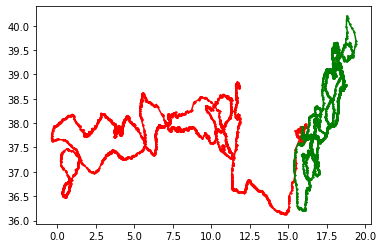

In [14]:
# see dfs of No gps data
displayNoGpsDf(turtlesData)

# get name for each No gps DF turtleData
createNoGpsDfCsvNameForEachInstance(turtlesData)

# SAVE THE NO GPS DATAFRAME in the Results Folder
checkIfNoGpsDfHasBeenSaved(turtlesData)

# build dfs of all gps
getAllGpsDataframes(turtlesData)

# see dfs of all gps
displayAllGpsDf(turtlesData)

# get name for each ALL GPS DF turtleData
createAllGpsDfCsvNameForEachInstance(turtlesData)

# SAVE THE ALL GPS DATAFRAME in the Results Folder
checkIfAllGpsDfHasBeenSaved(turtlesData)

assignTagDayDatetimeToEachInstance(turtlesData)

# deleting duplicate rows and 2019 date
getAllCleanedGpsDataframes(turtlesData)

# get name for each ALL CLEANED GPS DF turtleData
createAllCleanedGpsDfCsvNameForEachInstance(turtlesData)

# SAVE THE ALL CLEANED GPS DATAFRAME in the Results Folder
checkIfAllCleanedGpsDfHasBeenSaved(turtlesData)

# Assign the CRS data
giveCoordinateReferenceSystemCrs(turtlesData)

# see dfs of reliable gps and no reliable gps (Remove GPS Errors by Angular velocity/Rotational speed)
getReliableAndNoReliableGpsDataframes(turtlesData)

# get name for each RELIABLE GPS DF turtleData
createReliableGpsDfCsvNameForEachInstance(turtlesData)

# SAVE THE RELIABLE GPS DATAFRAME in the Results Folder
checkIfReliableGpsDfHasBeenSaved(turtlesData)

# get name for each NO RELIABLE GPS DF turtleData
createNoReliableGpsDfCsvNameForEachInstance(turtlesData)

# SAVE THE NO RELIABLE GPS DATAFRAME in the Results Folder    
checkIfNoReliableGpsDfHasBeenSaved(turtlesData)

# then initiate with the depth data
getRemainingDataDataframes(turtlesData)

# get name for each Remaining Data DF turtleData
createRemainingDataDfCsvNameForEachInstance(turtlesData)

# SAVE THE REMAINING DATA DATAFRAME in the Results Folder 
checkIfRemainingDataDfHasBeenSaved(turtlesData)

# build dfs for Depth Data
getDepthDataDataframes(turtlesData)

# get name for each Depth Data DF turtleData
createdepthDataDfCsvNameForEachInstance(turtlesData)

# SAVE THE DEPTH DATA DATAFRAME in the Results Folder 
checkIfdepthDataDfHasBeenSaved(turtlesData)

#
# get plotlyLines from reliable gps
### USE WITH JUPYTER NOTEBOOK
#getLines(turtlesData) # just to see the map without projection

# get plotlyLines from reliable gps with map projection
### USE WITH JUPYTER NOTEBOOK
getProjLines(turtlesData)

# see the CRS
askCrs(turtlesData)

#just to see if the append arrays of the Gps data inside the empty object works
#askGpsArray(turtlesData) 

In [15]:
depthPointsFromAcquisitionTime(turtlesData)

---------------------END------------------------
CICLO 1
2020.07.10 01:30:00
2020.07.10 02:00:00
2020.07.10 03:30:00
2020.07.10 05:00:00
2020.07.10 05:30:00
2020.07.10 06:00:00
2020.07.10 07:30:00
2020.07.10 08:00:00
2020.07.10 09:30:00
2020.07.10 10:30:00
2020.07.10 11:30:00
2020.07.10 12:00:00
2020.07.10 12:00:00
2020.07.10 14:00:00
2020.07.10 15:30:00
2020.07.10 16:00:00
2020.07.10 17:30:00
2020.07.10 18:00:00
2020.07.10 19:30:00
2020.07.10 20:00:00
2020.07.10 21:00:00
2020.07.10 22:00:00
2020.07.10 23:30:00
2020.07.11 00:00:00
2020.07.11 01:30:00
2020.07.11 02:30:00
2020.07.11 03:00:00
2020.07.11 04:00:00
2020.07.11 04:00:00
2020.07.11 11:00:00
2020.07.11 04:00:00
2020.07.11 11:00:00
2020.07.11 04:00:00
2020.07.11 11:00:00
2020.07.11 11:30:00
2020.07.11 17:30:00
2020.07.11 11:30:00
2020.07.11 17:30:00
2020.07.11 11:30:00
2020.07.11 17:30:00
2020.07.11 17:30:00
2020.07.11 18:30:00
2020.07.11 19:30:00
2020.07.11 20:00:00
2020.07.11 21:30:00
2020.07.11 23:00:00
2020.07.11 23:30:00
202

2020.08.29 04:00:00
2020.08.29 09:00:00
2020.08.29 04:00:00
2020.08.29 09:00:00
2020.08.29 09:00:00
2020.08.29 12:00:00
2020.08.29 09:00:00
2020.08.29 12:00:00
2020.08.29 13:00:00
2020.08.29 14:00:00
2020.08.29 14:00:00
2020.08.29 16:00:00
2020.08.29 16:00:00
2020.08.29 18:00:00
2020.08.29 18:00:00
2020.08.29 21:00:00
2020.08.29 21:00:00
2020.08.29 22:00:00
2020.08.29 22:00:00
2020.08.30 04:00:00
2020.08.29 22:00:00
2020.08.30 04:00:00
2020.08.29 22:00:00
2020.08.30 04:00:00
2020.08.30 05:00:00
2020.08.30 08:00:00
2020.08.30 05:00:00
2020.08.30 08:00:00
2020.08.30 09:00:00
2020.08.30 10:00:00
2020.08.30 11:00:00
2020.08.30 12:00:00
2020.08.30 13:00:00
2020.08.30 16:00:00
2020.08.30 13:00:00
2020.08.30 16:00:00
2020.08.30 17:00:00
2020.08.30 18:00:00
2020.08.30 18:00:00
2020.08.30 20:00:00
2020.08.30 20:00:00
2020.08.30 22:00:00
2020.08.30 23:00:00
2020.08.31 03:00:00
2020.08.30 23:00:00
2020.08.31 03:00:00
2020.08.31 03:00:00
2020.08.31 06:00:00
2020.08.31 03:00:00
2020.08.31 06:00:00


2020.10.19 18:00:00
2020.10.20 01:00:00
2020.10.20 01:00:00
2020.10.20 05:00:00
2020.10.20 01:00:00
2020.10.20 05:00:00
2020.10.20 05:00:00
2020.10.20 07:00:00
2020.10.20 07:00:00
2020.10.20 08:00:00
2020.10.20 09:00:00
2020.10.20 10:00:00
2020.10.20 11:00:00
2020.10.20 13:00:00
2020.10.20 13:00:00
2020.10.20 14:00:00
2020.10.20 14:00:00
2020.10.20 18:00:00
2020.10.20 14:00:00
2020.10.20 18:00:00
2020.10.20 18:00:00
2020.10.20 20:00:00
2020.10.20 20:00:00
2020.10.20 22:00:00
2020.10.20 22:00:00
2020.10.21 02:00:00
2020.10.20 22:00:00
2020.10.21 02:00:00
2020.10.21 03:00:00
2020.10.21 04:00:00
2020.10.21 04:00:00
2020.10.21 06:00:00
2020.10.21 07:00:00
2020.10.21 09:00:00
2020.10.21 09:00:00
2020.10.21 10:00:00
2020.10.21 11:00:00
2020.10.21 15:00:00
2020.10.21 11:00:00
2020.10.21 15:00:00
2020.10.21 15:00:00
2020.10.21 16:00:00
2020.10.21 17:00:00
2020.10.21 18:00:00
2020.10.21 18:00:00
2020.10.21 23:00:00
2020.10.21 18:00:00
2020.10.21 23:00:00
2020.10.21 23:00:00
2020.10.22 03:00:00


2020.12.12 11:00:00
2020.12.12 13:00:00
2020.12.12 13:00:00
2020.12.12 14:00:00
2020.12.12 15:00:00
2020.12.12 17:00:00
2020.12.12 17:00:00
2020.12.12 23:00:00
2020.12.12 17:00:00
2020.12.12 23:00:00
2020.12.12 17:00:00
2020.12.12 23:00:00
2020.12.12 23:00:00
2020.12.13 02:00:00
2020.12.12 23:00:00
2020.12.13 02:00:00
2020.12.13 03:00:00
2020.12.13 05:00:00
2020.12.13 05:00:00
2020.12.13 06:00:00
2020.12.13 07:00:00
2020.12.13 08:00:00
2020.12.13 09:00:00
2020.12.13 12:00:00
2020.12.13 09:00:00
2020.12.13 12:00:00
2020.12.13 12:00:00
2020.12.13 14:00:00
2020.12.13 14:00:00
2020.12.13 16:00:00
2020.12.13 16:00:00
2020.12.13 20:00:00
2020.12.13 16:00:00
2020.12.13 20:00:00
2020.12.13 20:00:00
2020.12.13 22:00:00
2020.12.13 23:00:00
2020.12.14 01:00:00
2020.12.14 01:00:00
2020.12.14 03:00:00
2020.12.14 03:00:00
2020.12.14 07:00:00
2020.12.14 03:00:00
2020.12.14 07:00:00
2020.12.14 07:00:00
2020.12.14 08:00:00
2020.12.14 08:00:00
2020.12.14 12:00:00
2020.12.14 08:00:00
2020.12.14 12:00:00


2021.02.03 22:00:00
2021.02.04 00:00:00
2021.02.04 01:00:00
2021.02.04 02:00:00
2021.02.04 02:00:00
2021.02.04 06:00:00
2021.02.04 02:00:00
2021.02.04 06:00:00
2021.02.04 07:00:00
2021.02.04 09:00:00
2021.02.04 09:00:00
2021.02.04 10:00:00
2021.02.04 11:00:00
2021.02.04 12:00:00
2021.02.04 12:00:00
2021.02.04 14:00:00
2021.02.04 15:00:00
2021.02.04 17:00:00
2021.02.04 17:00:00
2021.02.04 19:00:00
2021.02.04 19:00:00
2021.02.04 21:00:00
2021.02.04 21:00:00
2021.02.04 22:00:00
2021.02.04 23:00:00
2021.02.05 00:00:00
2021.02.05 00:00:00
2021.02.05 02:00:00
2021.02.05 02:00:00
2021.02.05 04:00:00
2021.02.05 04:00:00
2021.02.05 07:00:00
2021.02.05 07:00:00
2021.02.05 08:00:00
2021.02.05 08:00:00
2021.02.05 10:00:00
2021.02.05 11:00:00
2021.02.05 12:00:00
2021.02.05 12:00:00
2021.02.05 16:00:00
2021.02.05 12:00:00
2021.02.05 16:00:00
2021.02.05 16:00:00
2021.02.05 18:00:00
2021.02.05 18:00:00
2021.02.05 20:00:00
2021.02.05 21:00:00
2021.02.05 23:00:00
2021.02.05 23:00:00
2021.02.06 01:00:00


2020.09.19 15:00:00
2020.09.19 16:00:00
2020.09.19 16:00:00
2020.09.19 20:00:00
2020.09.19 16:00:00
2020.09.19 20:00:00
2020.09.19 20:00:00
2020.09.19 23:00:00
2020.09.19 23:00:00
2020.09.20 00:00:00
2020.09.20 00:00:00
2020.09.20 03:00:00
2020.09.20 03:00:00
2020.09.20 05:00:00
2020.09.20 05:00:00
2020.09.20 06:00:00
2020.09.20 07:00:00
2020.09.20 08:00:00
2020.09.20 09:00:00
2020.09.20 11:00:00
2020.09.20 11:00:00
2020.09.20 12:00:00
2020.09.20 13:00:00
2020.09.20 14:00:00
2020.09.20 14:00:00
2020.09.20 16:00:00
2020.09.20 17:00:00
2020.09.20 19:00:00
2020.09.20 19:00:00
2020.09.20 20:00:00
2020.09.20 21:00:00
2020.09.20 22:00:00
2020.09.20 23:00:00
2020.09.21 00:00:00
2020.09.21 01:00:00
2020.09.21 03:00:00
2020.09.21 03:00:00
2020.09.21 05:00:00
2020.09.21 05:00:00
2020.09.21 06:00:00
2020.09.21 07:00:00
2020.09.21 09:00:00
2020.09.21 09:00:00
2020.09.21 10:00:00
2020.09.21 11:00:00
2020.09.21 12:00:00
2020.09.21 13:00:00
2020.09.21 14:00:00
2020.09.21 15:00:00
2020.09.21 16:00:00


2020.11.10 08:00:00
2020.11.10 10:00:00
2020.11.10 10:00:00
2020.11.10 12:00:00
2020.11.10 12:00:00
2020.11.10 14:00:00
2020.11.10 15:00:00
2020.11.10 17:00:00
2020.11.10 17:00:00
2020.11.10 20:00:00
2020.11.10 17:00:00
2020.11.10 20:00:00
2020.11.10 21:00:00
2020.11.10 22:00:00
2020.11.10 23:00:00
2020.11.11 00:00:00
2020.11.11 00:00:00
2020.11.11 02:00:00
2020.11.11 02:00:00
2020.11.11 04:00:00
2020.11.11 05:00:00
2020.11.11 06:00:00
2020.11.11 06:00:00
2020.11.11 08:00:00
2020.11.11 08:00:00
2020.11.11 10:00:00
2020.11.11 10:00:00
2020.11.11 12:00:00
2020.11.11 12:00:00
2020.11.11 14:00:00
2020.11.11 14:00:00
2020.11.11 17:00:00
2020.11.11 17:00:00
2020.11.11 19:00:00
2020.11.11 19:00:00
2020.11.11 20:00:00
2020.11.11 20:00:00
2020.11.11 22:00:00
2020.11.11 23:00:00
2020.11.12 00:00:00
2020.11.12 01:00:00
2020.11.12 02:00:00
2020.11.12 02:00:00
2020.11.12 04:00:00
2020.11.12 05:00:00
2020.11.12 07:00:00
2020.11.12 07:00:00
2020.11.12 10:00:00
2020.11.12 07:00:00
2020.11.12 10:00:00


2021.01.05 03:00:00
2021.01.04 22:00:00
2021.01.05 03:00:00
2021.01.05 03:00:00
2021.01.05 06:00:00
2021.01.05 03:00:00
2021.01.05 06:00:00
2021.01.05 06:00:00
2021.01.05 10:00:00
2021.01.05 06:00:00
2021.01.05 10:00:00
2021.01.05 10:00:00
2021.01.05 12:00:00
2021.01.05 12:00:00
2021.01.05 15:00:00
2021.01.05 15:00:00
2021.01.05 23:00:00
2021.01.05 15:00:00
2021.01.05 23:00:00
2021.01.05 15:00:00
2021.01.05 23:00:00
2021.01.05 15:00:00
2021.01.05 23:00:00
2021.01.05 23:00:00
2021.01.06 04:00:00
2021.01.05 23:00:00
2021.01.06 04:00:00
2021.01.05 23:00:00
2021.01.06 04:00:00
2021.01.06 04:00:00
2021.01.06 07:00:00
2021.01.06 07:00:00
2021.01.06 09:00:00
2021.01.06 09:00:00
2021.01.06 12:00:00
2021.01.06 09:00:00
2021.01.06 12:00:00
2021.01.06 12:00:00
2021.01.06 17:00:00
2021.01.06 12:00:00
2021.01.06 17:00:00
2021.01.06 17:00:00
2021.01.06 22:00:00
2021.01.06 17:00:00
2021.01.06 22:00:00
2021.01.06 17:00:00
2021.01.06 22:00:00
2021.01.06 22:00:00
2021.01.07 02:00:00
2021.01.06 22:00:00


In [16]:
getDepthDataDataframesWithApproxCoordinates(turtlesData)

Depth Df with Approx Coord Columns with String values
      Depth Data ID  No GPS Data ID     Acquisition Time  \
0                 1              47  2020.07.10 02:00:00   
1                 2              49  2020.07.10 04:00:00   
2                 3              53  2020.07.10 06:00:00   
3                 4              55  2020.07.10 08:00:00   
4                 5              57  2020.07.10 10:00:00   
...             ...             ...                  ...   
2587           2588            4870  2021.02.11 00:00:00   
2588           2589            4871  2021.02.11 02:00:00   
2589           2590            4873  2021.02.11 04:00:00   
2590           2591            4874  2021.02.11 06:00:00   
2591           2592            4875  2021.02.11 08:00:00   

     Acquisition Start Time Underwater Percentage  Dive Count  \
0       2020.07.10 00:00:00                7.422%        12.0   
1       2020.07.10 02:00:00               74.609%        55.0   
2       2020.07.10 04:00:00   

In [17]:
createdepthDataDfWithCoordCsvNameForEachInstance(turtlesData)

checkIfdepthDataDfWithCoordHasBeenSaved(turtlesData)

The Last Entry in the Dataframe for 710333a is from: 
2021_Feb
The Name for the depthDataDfWithApproxCoord CSV for the turtleData 710333a is: 
depthDataDfWithApproxCoord_floatValues_Tag_710333a_2021_Feb.csv
--------------
The Last Entry in the Dataframe for 710348a is from: 
2021_Feb
The Name for the depthDataDfWithApproxCoord CSV for the turtleData 710348a is: 
depthDataDfWithApproxCoord_floatValues_Tag_710348a_2021_Feb.csv
--------------
['.~lock.depthDataWithApprxCoordDfWithSkyIllumination_Tag_710333a_2021_Feb.csv#', '.~lock.reliableGpsDfWithSkyIllumination_Tag_710333a_2021_Feb.csv#', '.~lock.reliableGpsDfWithSkyIllumination_Tag_710348a_2021_Feb.csv#', '1_percentage_of_gps_data_across_qfp_position_categories__bar_chart.png', '2_percentage_of_gps_data_across_qfp_position_categories__bar_chart.png', 'allCleanedGpsDf_Tag_710333a_2021_Feb.csv', 'allCleanedGpsDf_Tag_710348a_2021_Feb.csv', 'allGpsDf_Tag_710333a_2021_Feb.csv', 'allGpsDf_Tag_710348a_2021_Feb.csv', 'depthDataDfWithApproxCoor

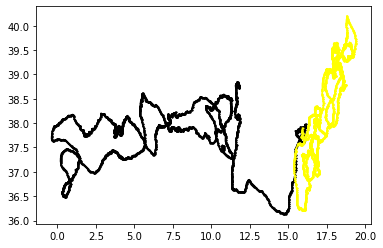

In [18]:
# get plotlyLines from depth data with approx coord with map projection
### USE WITH JUPYTER NOTEBOOK
getProjDepthLines(turtlesData)

#just to see if the append arrays of the Depth data inside the empty object works
#askDepthArray(turtlesData) 

In [19]:
dTypes(turtlesData)

Reliable Speed ID                   int64
All GPS's Track ID                  int64
Acquisition Time                   object
Acquisition Start Time             object
GPS Fix Time                       object
GPS Fix Attempt                    object
GPS Latitude                      float64
GPS Longitude                     float64
Distance (m)                      float64
Time (s)                          float64
Speed m/s                         float64
Time (h)                  timedelta64[ns]
dtype: object
Depth Data ID                       int64
No GPS Data ID                      int64
Acquisition Time                   object
Acquisition Start Time             object
Underwater Percentage              object
Dive Count                        float64
Average Dive Duration             float64
Maximum Dive Duration             float64
Maximum Dive Depth                float64
Layer 1 Percentage                 object
Layer 2 Percentage                 object
Layer 3 Percentage  

In [20]:
getJson(turtlesData)  

- gps dataframe file name = reliableGpsDf_bySpeed_Tag_710333a_2021_Feb.csv
- gps json file name = reliableGpsDf_bySpeed_Tag_710333a_2021_Feb.json
['.~lock.depthDataWithApprxCoordDfWithSkyIllumination_Tag_710333a_2021_Feb.csv#', '.~lock.reliableGpsDfWithSkyIllumination_Tag_710333a_2021_Feb.csv#', '.~lock.reliableGpsDfWithSkyIllumination_Tag_710348a_2021_Feb.csv#', '1_percentage_of_gps_data_across_qfp_position_categories__bar_chart.png', '2_percentage_of_gps_data_across_qfp_position_categories__bar_chart.png', 'allCleanedGpsDf_Tag_710333a_2021_Feb.csv', 'allCleanedGpsDf_Tag_710348a_2021_Feb.csv', 'allGpsDf_Tag_710333a_2021_Feb.csv', 'allGpsDf_Tag_710348a_2021_Feb.csv', 'depthDataDfWithApproxCoord_floatValues_Tag_710333a_2021_Feb.csv', 'depthDataDfWithApproxCoord_floatValues_Tag_710333a_2021_Feb.json', 'depthDataDfWithApproxCoord_floatValues_Tag_710348a_2021_Feb.csv', 'depthDataDfWithApproxCoord_floatValues_Tag_710348a_2021_Feb.json', 'depthDataDfWithApproxCoord_Tag_710333a_2021_Feb.csv',

In [21]:
#print(jsonGpsData_tag_710333a)
#print(jsonGpsData_tag_710348a)
#print(jsonDepthData_tag_710333a)
#print(jsonDepthData_tag_710348a)

In [22]:
getAmountOfDataObtained(turtlesData)

Quantity of ALL Fix Categories for the 710333a
GPS Fix Attempt
Resolved QFP                2840
Resolved QFP (Uncertain)     180
Succeeded                      6
Unresolved QFP               222
Name: GPS Fix Attempt, dtype: int64
{'Resolved QFP': 2840, 'Resolved QFP (Uncertain)': 180, 'Succeeded': 6, 'Unresolved QFP': 222}--------------allSentFixCategoriesDict dict
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Quantity of filtered Fix Categories for the 710333a
GPS Fix Attempt
Resolved QFP                 8
Resolved QFP (Uncertain)     7
Unresolved QFP              18
Name: GPS Fix Attempt, dtype: int64
{'Resolved QFP': 8, 'Resolved QFP (Uncertain)': 7, 'Unresolved QFP': 18}--------------deletedFixCategoriesDict dict
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Quantity of remaining Fix Categories for the 710333a
GPS Fix Attempt
Resolved QFP                2832
Resolved QFP (Uncertain)     173
Succeeded                      6
Unresolved QFP               204
Name: GPS Fix Attempt, dtype: int64
{'Resolved QFP': 2832

_gps_positions_recorded_by_710333a_transmitter_tag_graph
['1_percentage_of_gps_data_across_qfp_position_categories__bar_chart.png', '2_percentage_of_gps_data_across_qfp_position_categories__bar_chart.png', '_gps_positions_recorded_by_710333a_transmitter_tag_graph.png', '_gps_positions_recorded_by_710348a_transmitter_tag_graph.png']
The Graph _gps_positions_recorded_by_710333a_transmitter_tag_graph has already been saved in the results folder
--------------
Text(0.5, 1.0, ' Percentage of GPS Data across QFP Position Categories \n- 710333a Transmitter Tag Data')
['1_percentage_of_gps_data_across_qfp_position_categories__bar_chart.png', '2_percentage_of_gps_data_across_qfp_position_categories__bar_chart.png', '_gps_positions_recorded_by_710333a_transmitter_tag_graph.png', '_gps_positions_recorded_by_710348a_transmitter_tag_graph.png']
The Graph 1_percentage_of_gps_data_across_qfp_position_categories__bar_chart has already been saved in the results folder
--------------
_gps_positions_reco

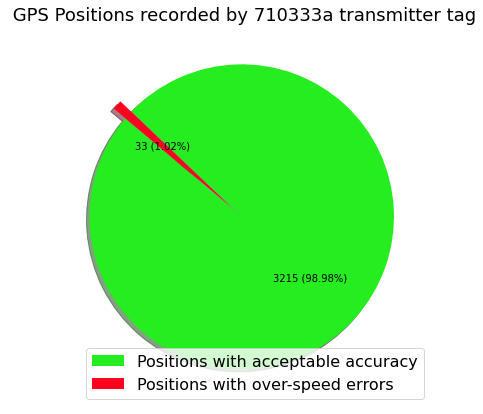

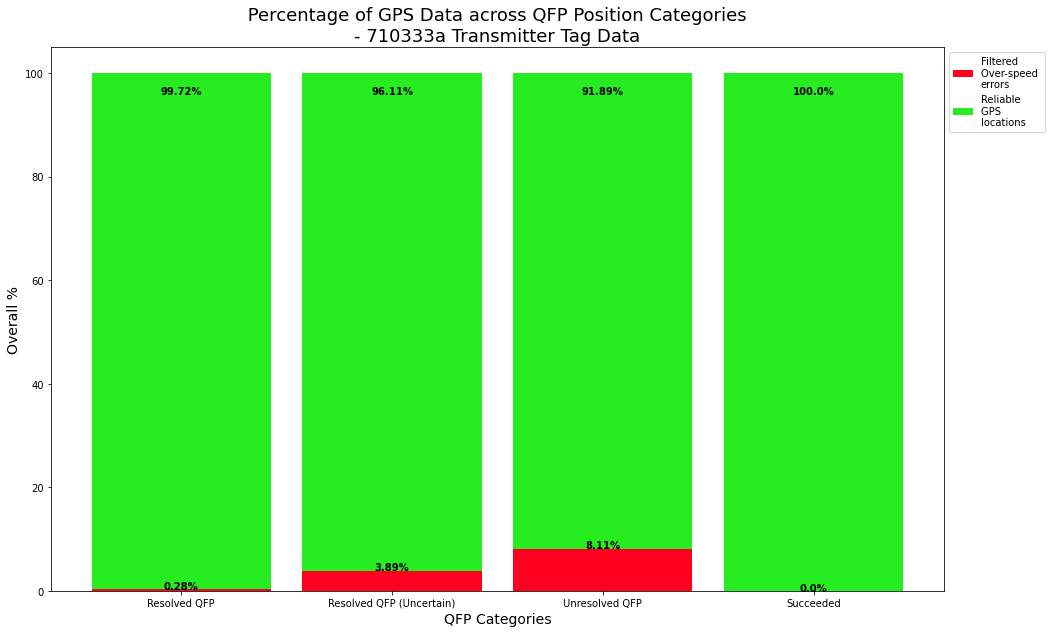

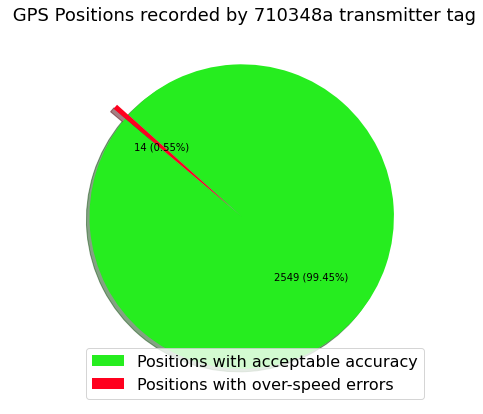

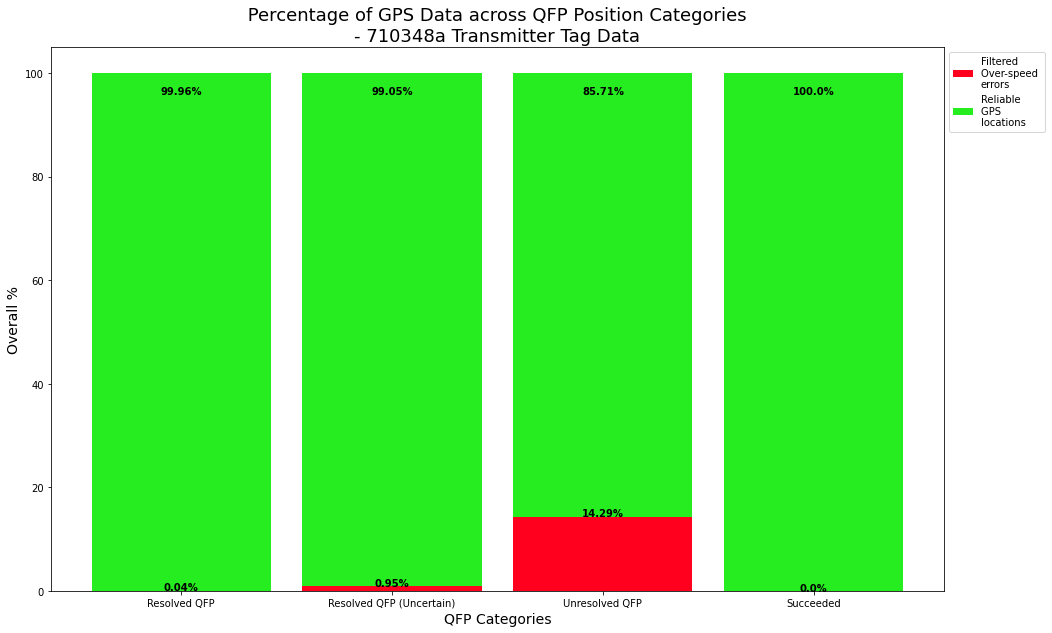

In [23]:
seeGraphs(turtlesData)

In [24]:
getDawnAndDuskTimesBasedOnCoordinates(turtlesData)

--------- There is lightness after: 
dawn      : 2020-07-09 03:10:20.485364+00:00
see dawn
2020-07-09 03:10:20.485364+00:00
--------- There is darkness after: 
dusk      : 2020-07-09 18:51:23.473037+00:00
see dusk
2020-07-09 18:51:23.473037+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-09 23:00:09+00:00
2020-07-09 03:10:20.485364+00:00
2020-07-09 18:51:23.473037+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-07-09 03:10:20.445827+00:00
see dawn
2020-07-09 03:10:20.445827+00:00
--------- There is darkness after: 
dusk      : 2020-07-09 18:51:23.493220+00:00
see dusk
2020-07-09 18:51:23.493220+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-09 23:30:12+00:00
2020-07-09 03:10:20.445827+00:00
2020-07-09 18:51:23.493220+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-07-10 03:11:01.436174+00:00
see dawn
2020-07-10 03:11:01.436174+00:00
--------- There is darkness after: 
dusk      : 2020-07-10 18:50:57.628461+00:00
see dusk
2020-07-10 18:

dawn      : 2020-07-14 03:16:26.073273+00:00
see dawn
2020-07-14 03:16:26.073273+00:00
--------- There is darkness after: 
dusk      : 2020-07-14 18:50:00.600183+00:00
see dusk
2020-07-14 18:50:00.600183+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-14 05:30:06+00:00
2020-07-14 03:16:26.073273+00:00
2020-07-14 18:50:00.600183+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-07-14 03:16:28.929560+00:00
see dawn
2020-07-14 03:16:28.929560+00:00
--------- There is darkness after: 
dusk      : 2020-07-14 18:50:03.302672+00:00
see dusk
2020-07-14 18:50:03.302672+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-14 06:45:01+00:00
2020-07-14 03:16:28.929560+00:00
2020-07-14 18:50:03.302672+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-07-14 03:16:29.557367+00:00
see dawn
2020-07-14 03:16:29.557367+00:00
--------- There is darkness after: 
dusk      : 2020-07-14 18:50:03.993312+00:00
see dusk
2020-07-14 18:50:03.993312+00:00
acqTimeDatetimeA

2020-07-20 18:44:53.570702+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-20 04:30:21+00:00
2020-07-20 03:18:52.894859+00:00
2020-07-20 18:44:53.570702+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-07-20 03:18:52.782406+00:00
see dawn
2020-07-20 03:18:52.782406+00:00
--------- There is darkness after: 
dusk      : 2020-07-20 18:44:53.415475+00:00
see dusk
2020-07-20 18:44:53.415475+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-20 05:05:48+00:00
2020-07-20 03:18:52.782406+00:00
2020-07-20 18:44:53.415475+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-07-20 03:18:52.891092+00:00
see dawn
2020-07-20 03:18:52.891092+00:00
--------- There is darkness after: 
dusk      : 2020-07-20 18:44:53.385096+00:00
see dusk
2020-07-20 18:44:53.385096+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-20 05:45:02+00:00
2020-07-20 03:18:52.891092+00:00
2020-07-20 18:44:53.385096+00:00
lightness
--------- There is lightness after: 
dawn      : 2020

2020-07-23 18:42:27.834423+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-23 23:00:59+00:00
2020-07-23 03:21:18.615018+00:00
2020-07-23 18:42:27.834423+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-07-23 03:21:18.560978+00:00
see dawn
2020-07-23 03:21:18.560978+00:00
--------- There is darkness after: 
dusk      : 2020-07-23 18:42:27.675310+00:00
see dusk
2020-07-23 18:42:27.675310+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-23 23:40:28+00:00
2020-07-23 03:21:18.560978+00:00
2020-07-23 18:42:27.675310+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-07-24 03:22:11.640763+00:00
see dawn
2020-07-24 03:22:11.640763+00:00
--------- There is darkness after: 
dusk      : 2020-07-24 18:41:35.868317+00:00
see dusk
2020-07-24 18:41:35.868317+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-24 00:03:11+00:00
2020-07-24 03:22:11.640763+00:00
2020-07-24 18:41:35.868317+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-07

2020-07-30 17:01:00+00:00
2020-07-30 03:36:05.921831+00:00
2020-07-30 18:35:52.285140+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-07-30 03:36:13.766643+00:00
see dawn
2020-07-30 03:36:13.766643+00:00
--------- There is darkness after: 
dusk      : 2020-07-30 18:35:46.005587+00:00
see dusk
2020-07-30 18:35:46.005587+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-30 19:35:07+00:00
2020-07-30 03:36:13.766643+00:00
2020-07-30 18:35:46.005587+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-07-30 03:36:25.250118+00:00
see dawn
2020-07-30 03:36:25.250118+00:00
--------- There is darkness after: 
dusk      : 2020-07-30 18:35:33.474862+00:00
see dusk
2020-07-30 18:35:33.474862+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-30 23:03:16+00:00
2020-07-30 03:36:25.250118+00:00
2020-07-30 18:35:33.474862+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-07-31 03:37:33.231242+00:00
see dawn
2020-07-31 03:37:33.231242+00:00
--

--------- There is lightness after: 
dawn      : 2020-08-06 03:51:23.544476+00:00
see dawn
2020-08-06 03:51:23.544476+00:00
--------- There is darkness after: 
dusk      : 2020-08-06 18:39:31.644688+00:00
see dusk
2020-08-06 18:39:31.644688+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-08-06 02:07:31+00:00
2020-08-06 03:51:23.544476+00:00
2020-08-06 18:39:31.644688+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-08-06 03:51:25.582546+00:00
see dawn
2020-08-06 03:51:25.582546+00:00
--------- There is darkness after: 
dusk      : 2020-08-06 18:39:35.854067+00:00
see dusk
2020-08-06 18:39:35.854067+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-08-06 03:19:04+00:00
2020-08-06 03:51:25.582546+00:00
2020-08-06 18:39:35.854067+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-08-06 03:51:28.094911+00:00
see dawn
2020-08-06 03:51:28.094911+00:00
--------- There is darkness after: 
dusk      : 2020-08-06 18:39:40.294185+00:00
see dusk
2020-08-06 18:

2020-08-12 04:30:16+00:00
2020-08-12 04:01:15.337296+00:00
2020-08-12 18:37:26.428685+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-08-12 04:01:13.727483+00:00
see dawn
2020-08-12 04:01:13.727483+00:00
--------- There is darkness after: 
dusk      : 2020-08-12 18:37:27.545393+00:00
see dusk
2020-08-12 18:37:27.545393+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-08-12 05:31:18+00:00
2020-08-12 04:01:13.727483+00:00
2020-08-12 18:37:27.545393+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-08-12 04:00:57.796475+00:00
see dawn
2020-08-12 04:00:57.796475+00:00
--------- There is darkness after: 
dusk      : 2020-08-12 18:37:33.569713+00:00
see dusk
2020-08-12 18:37:33.569713+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-08-12 12:01:18+00:00
2020-08-12 04:00:57.796475+00:00
2020-08-12 18:37:33.569713+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-08-12 04:00:56.627548+00:00
see dawn
2020-08-12 04:00:56.627548+00:00


--------- There is lightness after: 
dawn      : 2020-08-19 04:08:32.452085+00:00
see dawn
2020-08-19 04:08:32.452085+00:00
--------- There is darkness after: 
dusk      : 2020-08-19 18:33:26.414044+00:00
see dusk
2020-08-19 18:33:26.414044+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-08-19 12:07:29+00:00
2020-08-19 04:08:32.452085+00:00
2020-08-19 18:33:26.414044+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-08-19 04:08:31.462358+00:00
see dawn
2020-08-19 04:08:31.462358+00:00
--------- There is darkness after: 
dusk      : 2020-08-19 18:33:26.476650+00:00
see dusk
2020-08-19 18:33:26.476650+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-08-19 13:16:16+00:00
2020-08-19 04:08:31.462358+00:00
2020-08-19 18:33:26.476650+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-08-19 04:08:30.814321+00:00
see dawn
2020-08-19 04:08:30.814321+00:00
--------- There is darkness after: 
dusk      : 2020-08-19 18:33:26.922403+00:00
see dusk
2020-08-19 1

dusk      : 2020-09-01 18:27:16.777793+00:00
see dusk
2020-09-01 18:27:16.777793+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-01 20:00:08+00:00
2020-09-01 04:33:43.720403+00:00
2020-09-01 18:27:16.777793+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-09-01 04:33:43.654873+00:00
see dawn
2020-09-01 04:33:43.654873+00:00
--------- There is darkness after: 
dusk      : 2020-09-01 18:27:16.134315+00:00
see dusk
2020-09-01 18:27:16.134315+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-01 21:06:44+00:00
2020-09-01 04:33:43.654873+00:00
2020-09-01 18:27:16.134315+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-09-01 04:33:44.321829+00:00
see dawn
2020-09-01 04:33:44.321829+00:00
--------- There is darkness after: 
dusk      : 2020-09-01 18:27:16.320338+00:00
see dusk
2020-09-01 18:27:16.320338+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-01 23:20:39+00:00
2020-09-01 04:33:44.321829+00:00
2020-09-01 18:27:16.320338+00:00
darkness
--

2020-09-10 02:22:17+00:00
2020-09-10 04:44:29.061244+00:00
2020-09-10 18:15:32.734072+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-09-10 04:44:28.988467+00:00
see dawn
2020-09-10 04:44:28.988467+00:00
--------- There is darkness after: 
dusk      : 2020-09-10 18:15:32.893795+00:00
see dusk
2020-09-10 18:15:32.893795+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-10 03:09:57+00:00
2020-09-10 04:44:28.988467+00:00
2020-09-10 18:15:32.893795+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-09-10 04:44:29.124027+00:00
see dawn
2020-09-10 04:44:29.124027+00:00
--------- There is darkness after: 
dusk      : 2020-09-10 18:15:33.272127+00:00
see dusk
2020-09-10 18:15:33.272127+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-10 04:08:02+00:00
2020-09-10 04:44:29.124027+00:00
2020-09-10 18:15:33.272127+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-09-10 04:44:29.806943+00:00
see dawn
2020-09-10 04:44:29.806943+00:00
---

lightness
--------- There is lightness after: 
dawn      : 2020-09-19 05:00:18.796382+00:00
see dawn
2020-09-19 05:00:18.796382+00:00
--------- There is darkness after: 
dusk      : 2020-09-19 18:09:22.060203+00:00
see dusk
2020-09-19 18:09:22.060203+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-19 08:07:52+00:00
2020-09-19 05:00:18.796382+00:00
2020-09-19 18:09:22.060203+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-09-19 05:00:23.102077+00:00
see dawn
2020-09-19 05:00:23.102077+00:00
--------- There is darkness after: 
dusk      : 2020-09-19 18:09:26.662354+00:00
see dusk
2020-09-19 18:09:26.662354+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-19 09:14:39+00:00
2020-09-19 05:00:23.102077+00:00
2020-09-19 18:09:26.662354+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-09-19 05:00:25.475531+00:00
see dawn
2020-09-19 05:00:25.475531+00:00
--------- There is darkness after: 
dusk      : 2020-09-19 18:09:29.540194+00:00
see dusk
20

dusk      : 2020-09-26 18:00:16.551096+00:00
see dusk
2020-09-26 18:00:16.551096+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-26 23:00:36+00:00
2020-09-26 05:08:33.646942+00:00
2020-09-26 18:00:16.551096+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-09-27 05:09:29.093689+00:00
see dawn
2020-09-27 05:09:29.093689+00:00
--------- There is darkness after: 
dusk      : 2020-09-27 17:58:46.348699+00:00
see dusk
2020-09-27 17:58:46.348699+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-27 01:06:02+00:00
2020-09-27 05:09:29.093689+00:00
2020-09-27 17:58:46.348699+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-09-27 05:09:30.175742+00:00
see dawn
2020-09-27 05:09:30.175742+00:00
--------- There is darkness after: 
dusk      : 2020-09-27 17:58:47.453487+00:00
see dusk
2020-09-27 17:58:47.453487+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-27 02:00:36+00:00
2020-09-27 05:09:30.175742+00:00
2020-09-27 17:58:47.453487+00:00
darkness
--

acqTimeDatetimeAware, dawn and dusk =
2020-10-09 20:25:27+00:00
2020-10-09 05:22:08.504896+00:00
2020-10-09 17:42:43.044833+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-10-09 05:22:08.740614+00:00
see dawn
2020-10-09 05:22:08.740614+00:00
--------- There is darkness after: 
dusk      : 2020-10-09 17:42:43.261020+00:00
see dusk
2020-10-09 17:42:43.261020+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-09 22:02:20+00:00
2020-10-09 05:22:08.740614+00:00
2020-10-09 17:42:43.261020+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-10-10 05:23:03.982446+00:00
see dawn
2020-10-10 05:23:03.982446+00:00
--------- There is darkness after: 
dusk      : 2020-10-10 17:41:17.932718+00:00
see dusk
2020-10-10 17:41:17.932718+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-10 00:28:09+00:00
2020-10-10 05:23:03.982446+00:00
2020-10-10 17:41:17.932718+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-10-10 05:23:04.688780+00:00
see daw

acqTimeDatetimeAware, dawn and dusk =
2020-10-17 17:23:43+00:00
2020-10-17 05:36:31.664574+00:00
2020-10-17 17:38:54.813802+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-10-17 05:36:31.333539+00:00
see dawn
2020-10-17 05:36:31.333539+00:00
--------- There is darkness after: 
dusk      : 2020-10-17 17:38:54.587286+00:00
see dusk
2020-10-17 17:38:54.587286+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-17 18:02:07+00:00
2020-10-17 05:36:31.333539+00:00
2020-10-17 17:38:54.587286+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-10-17 05:36:30.651343+00:00
see dawn
2020-10-17 05:36:30.651343+00:00
--------- There is darkness after: 
dusk      : 2020-10-17 17:38:54.313370+00:00
see dusk
2020-10-17 17:38:54.313370+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-17 19:15:05+00:00
2020-10-17 05:36:30.651343+00:00
2020-10-17 17:38:54.313370+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-10-17 05:36:30.905857+00:00
see da

--------- There is darkness after: 
dusk      : 2020-10-28 17:28:15.082062+00:00
see dusk
2020-10-28 17:28:15.082062+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-28 00:36:03+00:00
2020-10-28 05:49:05.163273+00:00
2020-10-28 17:28:15.082062+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-10-28 05:48:57.145890+00:00
see dawn
2020-10-28 05:48:57.145890+00:00
--------- There is darkness after: 
dusk      : 2020-10-28 17:28:08.943344+00:00
see dusk
2020-10-28 17:28:08.943344+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-28 02:05:27+00:00
2020-10-28 05:48:57.145890+00:00
2020-10-28 17:28:08.943344+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-10-28 05:48:48.305045+00:00
see dawn
2020-10-28 05:48:48.305045+00:00
--------- There is darkness after: 
dusk      : 2020-10-28 17:28:02.942575+00:00
see dusk
2020-10-28 17:28:02.942575+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-28 04:00:09+00:00
2020-10-28 05:48:48.305045+00:00
2020-10-

dawn      : 2020-11-04 05:57:55.570755+00:00
see dawn
2020-11-04 05:57:55.570755+00:00
--------- There is darkness after: 
dusk      : 2020-11-04 17:25:40.165064+00:00
see dusk
2020-11-04 17:25:40.165064+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-11-04 20:17:12+00:00
2020-11-04 05:57:55.570755+00:00
2020-11-04 17:25:40.165064+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-11-04 05:57:53.303087+00:00
see dawn
2020-11-04 05:57:53.303087+00:00
--------- There is darkness after: 
dusk      : 2020-11-04 17:25:38.942804+00:00
see dusk
2020-11-04 17:25:38.942804+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-11-04 22:13:50+00:00
2020-11-04 05:57:53.303087+00:00
2020-11-04 17:25:38.942804+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-11-05 05:58:48.363021+00:00
see dawn
2020-11-05 05:58:48.363021+00:00
--------- There is darkness after: 
dusk      : 2020-11-05 17:24:44.062464+00:00
see dusk
2020-11-05 17:24:44.062464+00:00
acqTimeDatetimeAwa

dusk      : 2020-11-14 17:09:34.911183+00:00
see dusk
2020-11-14 17:09:34.911183+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-11-14 07:18:00+00:00
2020-11-14 06:00:44.719558+00:00
2020-11-14 17:09:34.911183+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-11-14 06:00:36.248298+00:00
see dawn
2020-11-14 06:00:36.248298+00:00
--------- There is darkness after: 
dusk      : 2020-11-14 17:09:26.828662+00:00
see dusk
2020-11-14 17:09:26.828662+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-11-14 08:18:41+00:00
2020-11-14 06:00:36.248298+00:00
2020-11-14 17:09:26.828662+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-11-14 06:00:30.083109+00:00
see dawn
2020-11-14 06:00:30.083109+00:00
--------- There is darkness after: 
dusk      : 2020-11-14 17:09:21.126670+00:00
see dusk
2020-11-14 17:09:21.126670+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-11-14 09:04:31+00:00
2020-11-14 06:00:30.083109+00:00
2020-11-14 17:09:21.126670+00:00
lightness

acqTimeDatetimeAware, dawn and dusk =
2020-11-26 09:22:07+00:00
2020-11-26 06:05:16.590953+00:00
2020-11-26 16:55:46.981656+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-11-26 06:05:13.798302+00:00
see dawn
2020-11-26 06:05:13.798302+00:00
--------- There is darkness after: 
dusk      : 2020-11-26 16:55:46.021072+00:00
see dusk
2020-11-26 16:55:46.021072+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-11-26 11:07:09+00:00
2020-11-26 06:05:13.798302+00:00
2020-11-26 16:55:46.021072+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-11-26 06:05:07.166829+00:00
see dawn
2020-11-26 06:05:07.166829+00:00
--------- There is darkness after: 
dusk      : 2020-11-26 16:55:43.037395+00:00
see dusk
2020-11-26 16:55:43.037395+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-11-26 14:00:07+00:00
2020-11-26 06:05:07.166829+00:00
2020-11-26 16:55:43.037395+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-11-26 06:05:04.064098+00:00
see 

darkness
--------- There is lightness after: 
dawn      : 2020-12-07 06:12:16.078836+00:00
see dawn
2020-12-07 06:12:16.078836+00:00
--------- There is darkness after: 
dusk      : 2020-12-07 16:46:05.294591+00:00
see dusk
2020-12-07 16:46:05.294591+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-12-07 21:09:47+00:00
2020-12-07 06:12:16.078836+00:00
2020-12-07 16:46:05.294591+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-12-07 06:12:11.950866+00:00
see dawn
2020-12-07 06:12:11.950866+00:00
--------- There is darkness after: 
dusk      : 2020-12-07 16:46:03.777625+00:00
see dusk
2020-12-07 16:46:03.777625+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-12-07 22:19:06+00:00
2020-12-07 06:12:11.950866+00:00
2020-12-07 16:46:03.777625+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-12-08 06:12:55.244958+00:00
see dawn
2020-12-08 06:12:55.244958+00:00
--------- There is darkness after: 
dusk      : 2020-12-08 16:46:08.994789+00:00
see dusk
2020-

dawn      : 2020-12-18 06:09:31.207706+00:00
see dawn
2020-12-18 06:09:31.207706+00:00
--------- There is darkness after: 
dusk      : 2020-12-18 16:41:49.948067+00:00
see dusk
2020-12-18 16:41:49.948067+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-12-18 20:22:44+00:00
2020-12-18 06:09:31.207706+00:00
2020-12-18 16:41:49.948067+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-12-18 06:09:31.661951+00:00
see dawn
2020-12-18 06:09:31.661951+00:00
--------- There is darkness after: 
dusk      : 2020-12-18 16:41:50.413341+00:00
see dusk
2020-12-18 16:41:50.413341+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-12-18 21:23:10+00:00
2020-12-18 06:09:31.661951+00:00
2020-12-18 16:41:50.413341+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-12-18 06:09:31.517268+00:00
see dawn
2020-12-18 06:09:31.517268+00:00
--------- There is darkness after: 
dusk      : 2020-12-18 16:41:50.675763+00:00
see dusk
2020-12-18 16:41:50.675763+00:00
acqTimeDatetimeAwa

--------- There is lightness after: 
dawn      : 2020-12-26 06:12:11.613226+00:00
see dawn
2020-12-26 06:12:11.613226+00:00
--------- There is darkness after: 
dusk      : 2020-12-26 16:44:57.066227+00:00
see dusk
2020-12-26 16:44:57.066227+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-12-26 19:15:55+00:00
2020-12-26 06:12:11.613226+00:00
2020-12-26 16:44:57.066227+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-12-26 06:12:12.064367+00:00
see dawn
2020-12-26 06:12:12.064367+00:00
--------- There is darkness after: 
dusk      : 2020-12-26 16:44:58.641400+00:00
see dusk
2020-12-26 16:44:58.641400+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-12-26 20:32:03+00:00
2020-12-26 06:12:12.064367+00:00
2020-12-26 16:44:58.641400+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-12-26 06:12:13.468557+00:00
see dawn
2020-12-26 06:12:13.468557+00:00
--------- There is darkness after: 
dusk      : 2020-12-26 16:45:00.131615+00:00
see dusk
2020-12-26 16:

--------- There is lightness after: 
dawn      : 2021-01-03 06:05:16.463446+00:00
see dawn
2021-01-03 06:05:16.463446+00:00
--------- There is darkness after: 
dusk      : 2021-01-03 16:42:02.536678+00:00
see dusk
2021-01-03 16:42:02.536678+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-03 17:45:32+00:00
2021-01-03 06:05:16.463446+00:00
2021-01-03 16:42:02.536678+00:00
darkness
--------- There is lightness after: 
dawn      : 2021-01-03 06:05:15.934036+00:00
see dawn
2021-01-03 06:05:15.934036+00:00
--------- There is darkness after: 
dusk      : 2021-01-03 16:42:00.703715+00:00
see dusk
2021-01-03 16:42:00.703715+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-03 18:25:28+00:00
2021-01-03 06:05:15.934036+00:00
2021-01-03 16:42:00.703715+00:00
darkness
--------- There is lightness after: 
dawn      : 2021-01-03 06:05:14.609796+00:00
see dawn
2021-01-03 06:05:14.609796+00:00
--------- There is darkness after: 
dusk      : 2021-01-03 16:41:57.935262+00:00
see dusk
2021-01-03 16:

--------- There is lightness after: 
dawn      : 2021-01-16 06:05:10.332672+00:00
see dawn
2021-01-16 06:05:10.332672+00:00
--------- There is darkness after: 
dusk      : 2021-01-16 16:52:35.122942+00:00
see dusk
2021-01-16 16:52:35.122942+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-16 08:00:09+00:00
2021-01-16 06:05:10.332672+00:00
2021-01-16 16:52:35.122942+00:00
lightness
--------- There is lightness after: 
dawn      : 2021-01-16 06:05:09.580265+00:00
see dawn
2021-01-16 06:05:09.580265+00:00
--------- There is darkness after: 
dusk      : 2021-01-16 16:52:37.052488+00:00
see dusk
2021-01-16 16:52:37.052488+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-16 10:00:20+00:00
2021-01-16 06:05:09.580265+00:00
2021-01-16 16:52:37.052488+00:00
lightness
--------- There is lightness after: 
dawn      : 2021-01-16 06:05:10.748439+00:00
see dawn
2021-01-16 06:05:10.748439+00:00
--------- There is darkness after: 
dusk      : 2021-01-16 16:52:45.930244+00:00
see dusk
2021-01-16 1

2021-01-29 17:01:15.592866+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-29 13:21:29+00:00
2021-01-29 05:51:34.532167+00:00
2021-01-29 17:01:15.592866+00:00
lightness
--------- There is lightness after: 
dawn      : 2021-01-29 05:51:30.629809+00:00
see dawn
2021-01-29 05:51:30.629809+00:00
--------- There is darkness after: 
dusk      : 2021-01-29 17:01:08.327698+00:00
see dusk
2021-01-29 17:01:08.327698+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-29 15:20:07+00:00
2021-01-29 05:51:30.629809+00:00
2021-01-29 17:01:08.327698+00:00
lightness
--------- There is lightness after: 
dawn      : 2021-01-29 05:51:27.429745+00:00
see dawn
2021-01-29 05:51:27.429745+00:00
--------- There is darkness after: 
dusk      : 2021-01-29 17:01:02.835758+00:00
see dusk
2021-01-29 17:01:02.835758+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-29 17:23:07+00:00
2021-01-29 05:51:27.429745+00:00
2021-01-29 17:01:02.835758+00:00
darkness
--------- There is lightness after: 
dawn      : 2021-

--------- There is lightness after: 
dawn      : 2021-02-10 05:42:02.746248+00:00
see dawn
2021-02-10 05:42:02.746248+00:00
--------- There is darkness after: 
dusk      : 2021-02-10 17:12:54.321991+00:00
see dusk
2021-02-10 17:12:54.321991+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-02-10 09:55:09+00:00
2021-02-10 05:42:02.746248+00:00
2021-02-10 17:12:54.321991+00:00
lightness
--------- There is lightness after: 
dawn      : 2021-02-10 05:42:02.650238+00:00
see dawn
2021-02-10 05:42:02.650238+00:00
--------- There is darkness after: 
dusk      : 2021-02-10 17:12:54.163080+00:00
see dusk
2021-02-10 17:12:54.163080+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-02-10 10:00:13+00:00
2021-02-10 05:42:02.650238+00:00
2021-02-10 17:12:54.163080+00:00
lightness
--------- There is lightness after: 
dawn      : 2021-02-10 05:41:54.073819+00:00
see dawn
2021-02-10 05:41:54.073819+00:00
--------- There is darkness after: 
dusk      : 2021-02-10 17:12:46.116037+00:00
see dusk
2021-02-10 1

dawn      : 2020-07-19 03:18:01.331976+00:00
see dawn
2020-07-19 03:18:01.331976+00:00
--------- There is darkness after: 
dusk      : 2020-07-19 18:45:38.800283+00:00
see dusk
2020-07-19 18:45:38.800283+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-19 00:00:00+00:00
2020-07-19 03:18:01.331976+00:00
2020-07-19 18:45:38.800283+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-07-19 03:18:01.681796+00:00
see dawn
2020-07-19 03:18:01.681796+00:00
--------- There is darkness after: 
dusk      : 2020-07-19 18:45:38.704850+00:00
see dusk
2020-07-19 18:45:38.704850+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-19 02:00:00+00:00
2020-07-19 03:18:01.681796+00:00
2020-07-19 18:45:38.704850+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-07-19 03:18:02.275882+00:00
see dawn
2020-07-19 03:18:02.275882+00:00
--------- There is darkness after: 
dusk      : 2020-07-19 18:45:38.813928+00:00
see dusk
2020-07-19 18:45:38.813928+00:00
acqTimeDatetimeAwa

dawn      : 2020-07-30 03:35:57.884576+00:00
see dawn
2020-07-30 03:35:57.884576+00:00
--------- There is darkness after: 
dusk      : 2020-07-30 18:36:02.063779+00:00
see dusk
2020-07-30 18:36:02.063779+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-30 14:00:00+00:00
2020-07-30 03:35:57.884576+00:00
2020-07-30 18:36:02.063779+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-07-30 03:36:03.055515+00:00
see dawn
2020-07-30 03:36:03.055515+00:00
--------- There is darkness after: 
dusk      : 2020-07-30 18:35:54.764031+00:00
see dusk
2020-07-30 18:35:54.764031+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-07-30 16:00:00+00:00
2020-07-30 03:36:03.055515+00:00
2020-07-30 18:35:54.764031+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-07-30 03:36:09.061210+00:00
see dawn
2020-07-30 03:36:09.061210+00:00
--------- There is darkness after: 
dusk      : 2020-07-30 18:35:49.771928+00:00
see dusk
2020-07-30 18:35:49.771928+00:00
acqTimeDatetimeA

--------- There is lightness after: 
dawn      : 2020-08-10 03:59:57.900923+00:00
see dawn
2020-08-10 03:59:57.900923+00:00
--------- There is darkness after: 
dusk      : 2020-08-10 18:39:11.916343+00:00
see dusk
2020-08-10 18:39:11.916343+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-08-10 02:00:00+00:00
2020-08-10 03:59:57.900923+00:00
2020-08-10 18:39:11.916343+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-08-10 03:59:55.519636+00:00
see dawn
2020-08-10 03:59:55.519636+00:00
--------- There is darkness after: 
dusk      : 2020-08-10 18:39:11.610135+00:00
see dusk
2020-08-10 18:39:11.610135+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-08-10 04:00:00+00:00
2020-08-10 03:59:55.519636+00:00
2020-08-10 18:39:11.610135+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-08-10 03:59:53.046462+00:00
see dawn
2020-08-10 03:59:53.046462+00:00
--------- There is darkness after: 
dusk      : 2020-08-10 18:39:12.907008+00:00
see dusk
2020-08-10 18

2020-08-21 04:00:00+00:00
2020-08-21 04:11:04.202784+00:00
2020-08-21 18:32:24.658629+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-08-21 04:11:08.300306+00:00
see dawn
2020-08-21 04:11:08.300306+00:00
--------- There is darkness after: 
dusk      : 2020-08-21 18:32:30.268725+00:00
see dusk
2020-08-21 18:32:30.268725+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-08-21 06:00:00+00:00
2020-08-21 04:11:08.300306+00:00
2020-08-21 18:32:30.268725+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-08-21 04:11:17.371413+00:00
see dawn
2020-08-21 04:11:17.371413+00:00
--------- There is darkness after: 
dusk      : 2020-08-21 18:32:41.671992+00:00
see dusk
2020-08-21 18:32:41.671992+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-08-21 08:00:00+00:00
2020-08-21 04:11:17.371413+00:00
2020-08-21 18:32:41.671992+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-08-21 04:11:26.442068+00:00
see dawn
2020-08-21 04:11:26.442068+00:00
-

2020-08-31 18:29:09.236028+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-08-31 22:00:00+00:00
2020-08-31 04:33:02.769244+00:00
2020-08-31 18:29:09.236028+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-09-01 04:33:59.744664+00:00
see dawn
2020-09-01 04:33:59.744664+00:00
--------- There is darkness after: 
dusk      : 2020-09-01 18:27:36.745314+00:00
see dusk
2020-09-01 18:27:36.745314+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-01 00:00:00+00:00
2020-09-01 04:33:59.744664+00:00
2020-09-01 18:27:36.745314+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-09-01 04:33:57.895305+00:00
see dawn
2020-09-01 04:33:57.895305+00:00
--------- There is darkness after: 
dusk      : 2020-09-01 18:27:34.123403+00:00
see dusk
2020-09-01 18:27:34.123403+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-01 02:00:00+00:00
2020-09-01 04:33:57.895305+00:00
2020-09-01 18:27:34.123403+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-09

dusk      : 2020-09-11 18:14:40.330839+00:00
see dusk
2020-09-11 18:14:40.330839+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-11 20:00:00+00:00
2020-09-11 04:46:19.469474+00:00
2020-09-11 18:14:40.330839+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-09-11 04:46:21.887066+00:00
see dawn
2020-09-11 04:46:21.887066+00:00
--------- There is darkness after: 
dusk      : 2020-09-11 18:14:41.259209+00:00
see dusk
2020-09-11 18:14:41.259209+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-11 22:00:00+00:00
2020-09-11 04:46:21.887066+00:00
2020-09-11 18:14:41.259209+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-09-12 04:47:16.317904+00:00
see dawn
2020-09-12 04:47:16.317904+00:00
--------- There is darkness after: 
dusk      : 2020-09-12 18:13:07.705732+00:00
see dusk
2020-09-12 18:13:07.705732+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-12 00:00:00+00:00
2020-09-12 04:47:16.317904+00:00
2020-09-12 18:13:07.705732+00:00
darkness
--

dawn      : 2020-09-23 05:05:38.522767+00:00
see dawn
2020-09-23 05:05:38.522767+00:00
--------- There is darkness after: 
dusk      : 2020-09-23 18:04:37.181331+00:00
see dusk
2020-09-23 18:04:37.181331+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-23 08:00:00+00:00
2020-09-23 05:05:38.522767+00:00
2020-09-23 18:04:37.181331+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-09-23 05:05:38.313551+00:00
see dawn
2020-09-23 05:05:38.313551+00:00
--------- There is darkness after: 
dusk      : 2020-09-23 18:04:36.605043+00:00
see dusk
2020-09-23 18:04:36.605043+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-09-23 10:00:00+00:00
2020-09-23 05:05:38.313551+00:00
2020-09-23 18:04:36.605043+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-09-23 05:05:38.997988+00:00
see dawn
2020-09-23 05:05:38.997988+00:00
--------- There is darkness after: 
dusk      : 2020-09-23 18:04:37.132063+00:00
see dusk
2020-09-23 18:04:37.132063+00:00
acqTimeDatetimeA

--------- There is lightness after: 
dawn      : 2020-10-04 05:16:52.442023+00:00
see dawn
2020-10-04 05:16:52.442023+00:00
--------- There is darkness after: 
dusk      : 2020-10-04 17:49:22.037705+00:00
see dusk
2020-10-04 17:49:22.037705+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-04 20:00:00+00:00
2020-10-04 05:16:52.442023+00:00
2020-10-04 17:49:22.037705+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-10-04 05:16:47.870727+00:00
see dawn
2020-10-04 05:16:47.870727+00:00
--------- There is darkness after: 
dusk      : 2020-10-04 17:49:17.335432+00:00
see dusk
2020-10-04 17:49:17.335432+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-04 22:00:00+00:00
2020-10-04 05:16:47.870727+00:00
2020-10-04 17:49:17.335432+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-10-05 05:17:36.240992+00:00
see dawn
2020-10-05 05:17:36.240992+00:00
--------- There is darkness after: 
dusk      : 2020-10-05 17:47:43.624024+00:00
see dusk
2020-10-05 17:

see dawn
2020-10-16 05:34:37.169055+00:00
--------- There is darkness after: 
dusk      : 2020-10-16 17:39:14.572015+00:00
see dusk
2020-10-16 17:39:14.572015+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-16 08:00:00+00:00
2020-10-16 05:34:37.169055+00:00
2020-10-16 17:39:14.572015+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-10-16 05:34:42.749658+00:00
see dawn
2020-10-16 05:34:42.749658+00:00
--------- There is darkness after: 
dusk      : 2020-10-16 17:39:21.396448+00:00
see dusk
2020-10-16 17:39:21.396448+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-16 10:00:00+00:00
2020-10-16 05:34:42.749658+00:00
2020-10-16 17:39:21.396448+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-10-16 05:34:51.917424+00:00
see dawn
2020-10-16 05:34:51.917424+00:00
--------- There is darkness after: 
dusk      : 2020-10-16 17:39:31.079865+00:00
see dusk
2020-10-16 17:39:31.079865+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-16 12:00:00+00:

acqTimeDatetimeAware, dawn and dusk =
2020-10-27 14:00:00+00:00
2020-10-27 05:49:04.468423+00:00
2020-10-27 17:30:12.255455+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-10-27 05:48:49.975687+00:00
see dawn
2020-10-27 05:48:49.975687+00:00
--------- There is darkness after: 
dusk      : 2020-10-27 17:29:59.466091+00:00
see dusk
2020-10-27 17:29:59.466091+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-27 16:00:00+00:00
2020-10-27 05:48:49.975687+00:00
2020-10-27 17:29:59.466091+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-10-27 05:48:40.812948+00:00
see dawn
2020-10-27 05:48:40.812948+00:00
--------- There is darkness after: 
dusk      : 2020-10-27 17:29:51.403980+00:00
see dusk
2020-10-27 17:29:51.403980+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-10-27 18:00:00+00:00
2020-10-27 05:48:40.812948+00:00
2020-10-27 17:29:51.403980+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-10-27 05:48:30.547990+00:00
see d

--------- There is lightness after: 
dawn      : 2020-11-08 06:00:38.236262+00:00
see dawn
2020-11-08 06:00:38.236262+00:00
--------- There is darkness after: 
dusk      : 2020-11-08 17:20:11.151520+00:00
see dusk
2020-11-08 17:20:11.151520+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-11-08 04:00:00+00:00
2020-11-08 06:00:38.236262+00:00
2020-11-08 17:20:11.151520+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-11-08 06:00:43.049699+00:00
see dawn
2020-11-08 06:00:43.049699+00:00
--------- There is darkness after: 
dusk      : 2020-11-08 17:20:15.171558+00:00
see dusk
2020-11-08 17:20:15.171558+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-11-08 06:00:00+00:00
2020-11-08 06:00:43.049699+00:00
2020-11-08 17:20:15.171558+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-11-08 06:00:48.754082+00:00
see dawn
2020-11-08 06:00:48.754082+00:00
--------- There is darkness after: 
dusk      : 2020-11-08 17:20:18.457474+00:00
see dusk
2020-11-08 17:

acqTimeDatetimeAware, dawn and dusk =
2020-11-19 02:00:00+00:00
2020-11-19 06:01:43.001437+00:00
2020-11-19 17:01:19.724260+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-11-19 06:01:40.641322+00:00
see dawn
2020-11-19 06:01:40.641322+00:00
--------- There is darkness after: 
dusk      : 2020-11-19 17:01:18.652008+00:00
see dusk
2020-11-19 17:01:18.652008+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-11-19 04:00:00+00:00
2020-11-19 06:01:40.641322+00:00
2020-11-19 17:01:18.652008+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-11-19 06:01:39.185906+00:00
see dawn
2020-11-19 06:01:39.185906+00:00
--------- There is darkness after: 
dusk      : 2020-11-19 17:01:18.067328+00:00
see dusk
2020-11-19 17:01:18.067328+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-11-19 06:00:00+00:00
2020-11-19 06:01:39.185906+00:00
2020-11-19 17:01:18.067328+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-11-19 06:01:35.630859+00:00
see daw

dawn      : 2020-11-30 06:03:46.423572+00:00
see dawn
2020-11-30 06:03:46.423572+00:00
--------- There is darkness after: 
dusk      : 2020-11-30 16:49:03.302108+00:00
see dusk
2020-11-30 16:49:03.302108+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-11-30 22:00:00+00:00
2020-11-30 06:03:46.423572+00:00
2020-11-30 16:49:03.302108+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-12-01 06:04:39.314986+00:00
see dawn
2020-12-01 06:04:39.314986+00:00
--------- There is darkness after: 
dusk      : 2020-12-01 16:48:50.966140+00:00
see dusk
2020-12-01 16:48:50.966140+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-12-01 00:00:00+00:00
2020-12-01 06:04:39.314986+00:00
2020-12-01 16:48:50.966140+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-12-01 06:04:38.499763+00:00
see dawn
2020-12-01 06:04:38.499763+00:00
--------- There is darkness after: 
dusk      : 2020-12-01 16:48:45.425507+00:00
see dusk
2020-12-01 16:48:45.425507+00:00
acqTimeDatetimeAwa

2020-12-12 16:43:14.477738+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-12-12 08:00:00+00:00
2020-12-12 06:10:45.474175+00:00
2020-12-12 16:43:14.477738+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-12-12 06:10:34.775422+00:00
see dawn
2020-12-12 06:10:34.775422+00:00
--------- There is darkness after: 
dusk      : 2020-12-12 16:43:09.253558+00:00
see dusk
2020-12-12 16:43:09.253558+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-12-12 10:00:00+00:00
2020-12-12 06:10:34.775422+00:00
2020-12-12 16:43:09.253558+00:00
lightness
--------- There is lightness after: 
dawn      : 2020-12-12 06:10:23.730778+00:00
see dawn
2020-12-12 06:10:23.730778+00:00
--------- There is darkness after: 
dusk      : 2020-12-12 16:43:02.595241+00:00
see dusk
2020-12-12 16:43:02.595241+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-12-12 12:00:00+00:00
2020-12-12 06:10:23.730778+00:00
2020-12-12 16:43:02.595241+00:00
lightness
--------- There is lightness after: 
dawn      : 2020

dawn      : 2020-12-24 06:12:34.369035+00:00
see dawn
2020-12-24 06:12:34.369035+00:00
--------- There is darkness after: 
dusk      : 2020-12-24 16:44:38.233833+00:00
see dusk
2020-12-24 16:44:38.233833+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-12-24 00:00:00+00:00
2020-12-24 06:12:34.369035+00:00
2020-12-24 16:44:38.233833+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-12-24 06:12:33.750828+00:00
see dawn
2020-12-24 06:12:33.750828+00:00
--------- There is darkness after: 
dusk      : 2020-12-24 16:44:35.533993+00:00
see dusk
2020-12-24 16:44:35.533993+00:00
acqTimeDatetimeAware, dawn and dusk =
2020-12-24 02:00:00+00:00
2020-12-24 06:12:33.750828+00:00
2020-12-24 16:44:35.533993+00:00
darkness
--------- There is lightness after: 
dawn      : 2020-12-24 06:12:30.943773+00:00
see dawn
2020-12-24 06:12:30.943773+00:00
--------- There is darkness after: 
dusk      : 2020-12-24 16:44:29.861948+00:00
see dusk
2020-12-24 16:44:29.861948+00:00
acqTimeDatetimeAwa

--------- There is lightness after: 
dawn      : 2021-01-04 06:05:02.674753+00:00
see dawn
2021-01-04 06:05:02.674753+00:00
--------- There is darkness after: 
dusk      : 2021-01-04 16:42:30.335920+00:00
see dusk
2021-01-04 16:42:30.335920+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-04 10:00:00+00:00
2021-01-04 06:05:02.674753+00:00
2021-01-04 16:42:30.335920+00:00
lightness
--------- There is lightness after: 
dawn      : 2021-01-04 06:05:00.456658+00:00
see dawn
2021-01-04 06:05:00.456658+00:00
--------- There is darkness after: 
dusk      : 2021-01-04 16:42:25.798943+00:00
see dusk
2021-01-04 16:42:25.798943+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-04 12:00:00+00:00
2021-01-04 06:05:00.456658+00:00
2021-01-04 16:42:25.798943+00:00
lightness
--------- There is lightness after: 
dawn      : 2021-01-04 06:04:54.006810+00:00
see dawn
2021-01-04 06:04:54.006810+00:00
--------- There is darkness after: 
dusk      : 2021-01-04 16:42:15.253778+00:00
see dusk
2021-01-04 1

dusk      : 2021-01-14 16:49:09.404259+00:00
see dusk
2021-01-14 16:49:09.404259+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-14 22:00:00+00:00
2021-01-14 06:04:47.361639+00:00
2021-01-14 16:49:09.404259+00:00
darkness
--------- There is lightness after: 
dawn      : 2021-01-15 06:04:31.893170+00:00
see dawn
2021-01-15 06:04:31.893170+00:00
--------- There is darkness after: 
dusk      : 2021-01-15 16:50:14.232971+00:00
see dusk
2021-01-15 16:50:14.232971+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-15 00:00:00+00:00
2021-01-15 06:04:31.893170+00:00
2021-01-15 16:50:14.232971+00:00
darkness
--------- There is lightness after: 
dawn      : 2021-01-15 06:04:38.054596+00:00
see dawn
2021-01-15 06:04:38.054596+00:00
--------- There is darkness after: 
dusk      : 2021-01-15 16:50:23.162418+00:00
see dusk
2021-01-15 16:50:23.162418+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-15 02:00:00+00:00
2021-01-15 06:04:38.054596+00:00
2021-01-15 16:50:23.162418+00:00
darkness
--

--------- There is lightness after: 
dawn      : 2021-01-25 05:56:49.239337+00:00
see dawn
2021-01-25 05:56:49.239337+00:00
--------- There is darkness after: 
dusk      : 2021-01-25 17:01:34.550619+00:00
see dusk
2021-01-25 17:01:34.550619+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-25 10:00:00+00:00
2021-01-25 05:56:49.239337+00:00
2021-01-25 17:01:34.550619+00:00
lightness
--------- There is lightness after: 
dawn      : 2021-01-25 05:56:38.621154+00:00
see dawn
2021-01-25 05:56:38.621154+00:00
--------- There is darkness after: 
dusk      : 2021-01-25 17:01:26.561701+00:00
see dusk
2021-01-25 17:01:26.561701+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-01-25 12:00:00+00:00
2021-01-25 05:56:38.621154+00:00
2021-01-25 17:01:26.561701+00:00
lightness
--------- There is lightness after: 
dawn      : 2021-01-25 05:56:34.395652+00:00
see dawn
2021-01-25 05:56:34.395652+00:00
--------- There is darkness after: 
dusk      : 2021-01-25 17:01:23.758495+00:00
see dusk
2021-01-25 1

--------- There is lightness after: 
dawn      : 2021-02-04 05:48:03.559784+00:00
see dawn
2021-02-04 05:48:03.559784+00:00
--------- There is darkness after: 
dusk      : 2021-02-04 17:07:11.427781+00:00
see dusk
2021-02-04 17:07:11.427781+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-02-04 22:00:00+00:00
2021-02-04 05:48:03.559784+00:00
2021-02-04 17:07:11.427781+00:00
darkness
--------- There is lightness after: 
dawn      : 2021-02-05 05:47:08.208599+00:00
see dawn
2021-02-05 05:47:08.208599+00:00
--------- There is darkness after: 
dusk      : 2021-02-05 17:08:14.914030+00:00
see dusk
2021-02-05 17:08:14.914030+00:00
acqTimeDatetimeAware, dawn and dusk =
2021-02-05 00:00:00+00:00
2021-02-05 05:47:08.208599+00:00
2021-02-05 17:08:14.914030+00:00
darkness
--------- There is lightness after: 
dawn      : 2021-02-05 05:47:08.652593+00:00
see dawn
2021-02-05 05:47:08.652593+00:00
--------- There is darkness after: 
dusk      : 2021-02-05 17:08:15.318087+00:00
see dusk
2021-02-05 17:

ValueError: cannot convert float NaN to integer

In [ ]:
getGPSDfSeparatedByMonth(turtlesData)